In [1]:
import mmcv
import matplotlib.pyplot as plt 


## Load The Finetuned Model

In [2]:
import cv2
import numpy as np
import mmcv
from mmengine import Config
from PIL import Image

from mmagic.registry import MODELS
from mmagic.utils import register_all_modules
from mmengine.runner import load_checkpoint

register_all_modules()

#cfg = Config.fromfile('configs/controlnet/controlnet-1xb1-fill50k_lora_inference.py')
checkpoint_file = '/data/yanan/output/yanan-dreambooth-dota-trainset-200-crops-per-class-full-finetune-lr3e-4/iter_100000_revised.pth'
cfg = Config.fromfile('configs/dreambooth/dreambooth-lora-dota-200crops-per-class-finetune-inference.py')
dreambooth_model = MODELS.build(cfg.model)
ckpt = load_checkpoint(dreambooth_model, checkpoint_file, map_location='cpu')

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


08/25 21:54:43 - mmengine - INFO - Creating runwayml/stable-diffusion-v1-5 by 'HuggingFace'


/work/mmagic/mmagic/models/archs/wrapper.py:129: FutureWarning: Accessing config attribute `block_out_channels` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'block_out_channels' over 'AutoencoderKL's config object instead, e.g. 'unet.config.block_out_channels'.
  return getattr(self.model, name)


08/25 21:54:45 - mmengine - INFO - Enable Xformers for HuggingFace Diffusers' module 'vae'.
08/25 21:54:45 - mmengine - INFO - Enable Xformers for HuggingFace Diffusers' module 'unet'.
08/25 21:54:45 - mmengine - INFO - Set VAE untrainable.
08/25 21:54:45 - mmengine - INFO - Move VAE to torch.float16.
08/25 21:54:45 - mmengine - INFO - Set Text Encoder untrainable.
08/25 21:54:45 - mmengine - INFO - Move Text Encoder to torch.float16.
08/25 21:54:45 - mmengine - INFO - Set Unet untrainable.
08/25 21:54:45 - mmengine - INFO - Set LoRA for 'model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q' with suffix match 'to_q'.
08/25 21:54:45 - mmengine - INFO - Set LoRA for 'model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k' with suffix match 'to_k'.
08/25 21:54:45 - mmengine - INFO - Set LoRA for 'model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v' with suffix match 'to_v'.
08/25 21:54:45 - mmengine - INFO - Set LoRA for 'model.down_blocks.0.attentions.0

08/25 21:54:45 - mmengine - INFO - Set LoRA for 'model.up_blocks.2.attentions.0.transformer_blocks.0.attn1.to_k' with suffix match 'to_k'.
08/25 21:54:45 - mmengine - INFO - Set LoRA for 'model.up_blocks.2.attentions.0.transformer_blocks.0.attn1.to_v' with suffix match 'to_v'.
08/25 21:54:45 - mmengine - INFO - Set LoRA for 'model.up_blocks.2.attentions.0.transformer_blocks.0.attn2.to_q' with suffix match 'to_q'.
08/25 21:54:45 - mmengine - INFO - Set LoRA for 'model.up_blocks.2.attentions.0.transformer_blocks.0.attn2.to_k' with suffix match 'to_k'.
08/25 21:54:45 - mmengine - INFO - Set LoRA for 'model.up_blocks.2.attentions.0.transformer_blocks.0.attn2.to_v' with suffix match 'to_v'.
08/25 21:54:45 - mmengine - INFO - Set LoRA for 'model.up_blocks.2.attentions.1.transformer_blocks.0.attn1.to_q' with suffix match 'to_q'.
08/25 21:54:45 - mmengine - INFO - Set LoRA for 'model.up_blocks.2.attentions.1.transformer_blocks.0.attn1.to_k' with suffix match 'to_k'.
08/25 21:54:45 - mmengine -

In [3]:
dreambooth_model.to('cuda:0')
dreambooth_model.eval()

DreamBooth(
  (data_preprocessor): DataPreprocessor()
  (vae): Wrapped Module Class: <class 'diffusers.models.autoencoder_kl.AutoencoderKL'>
  Wrapped Module Name: AutoencoderKL
  From Pretrained: runwayml/stable-diffusion-v1-5
  AutoencoderKL(
    (model): AutoencoderKL(
      (encoder): Encoder(
        (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (down_blocks): ModuleList(
          (0): DownEncoderBlock2D(
            (resnets): ModuleList(
              (0): ResnetBlock2D(
                (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
                (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (nonlinearity): SiLU()
              )
              (1): ResnetBlock2D(
         

## Load Original DOTA Annotations

In [5]:
import os
import json
from collections import defaultdict

# Path to the DOTA dataset annotations folder
annotations_folder = '/data/DOTA_split/annotations/'

# Create a defaultdict to store the number of objects and object class for each image
image_info = defaultdict(lambda: defaultdict(int))

# Loop through each annotation file in the annotations folder
for filename in os.listdir(annotations_folder):
    if filename.endswith('train_fixed.json'):
        # Load the annotation file
        with open(os.path.join(annotations_folder, filename), 'r') as f:
            annotation = json.load(f)
            tmp = annotation['categories']
            catid2name = {}
            for item in tmp:
                catid2name[item['id']] = item['name']

        # Update the defaultdict with the number of objects and object class for each image in the annotation data
        for obj in annotation['annotations']:
            image_id = obj['image_id']
            class_name = catid2name[obj['category_id']]
            image_info[image_id][class_name] += 1

In [6]:
fg_imgids = set(image_info.keys())
all_imgids = set([x['id'] for x in annotation['images']])
bg_imgids = all_imgids - fg_imgids

print (len(bg_imgids), len(fg_imgids), len(all_imgids))

P1437__512__0___4056.jpg
1
103461 49148 152609


In [7]:
imgid2fname = {anno['id']:anno['file_name'] for anno in annotation['images']}

## Generate Foreground Instances To Be Composed Onto Sampled Background Images

In [ ]:
# Define SEED range to generate instances per category, the more the generated instances, the more diversity the composition can be.
# Here we only use seed 19 and 20, generate 10 instances for each seed. But if time permits, you can try 10 seeds, 10 images per seed, to get more diversed results.
SEED_START = 19
SEED_END = 21 # actual seeds are from SEED_START to SEED_END-1, not including SEED_END. 

In [7]:
save_path = '/data/DOTA_generated_crops_3e-4-1/'
samples = {}

for catid,catname in catid2name.items():
    prompt = 'birdview of ' + catname
    samples[catid] = []
    for seed in range(SEED_START, SEED_END):
        output_dict = dreambooth_model.infer(prompt, negative_prompt='cartoon, toy', seed=seed, num_images_per_prompt=10)
        for i, sample in enumerate(output_dict['samples']):
            sample.save(os.path.join(save_path,str(catid)+'_'+str(seed)+'_'+str(i)+'.jpg'))
        samples[catid].extend(output_dict['samples'])
        

/work/mmagic/mmagic/models/archs/wrapper.py:129: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  return getattr(self.model, name)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

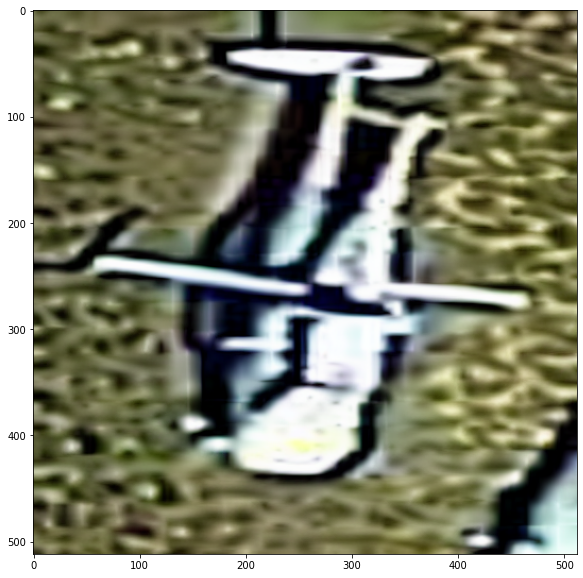

In [8]:
# Show an example instance generated.
plt.figure(figsize=(10,10))
plt.imshow(samples[11][0])

In [12]:
min_max_resize_dict = {}
min_max_aspect_ratio_dict = {}
for obj in annotation['annotations']:
    bbox_w, bbox_h = obj['bbox'][2], obj['bbox'][3]
    catid = obj['category_id']
    aspect_ratio = bbox_w / bbox_h
    if min_max_resize_dict.get(catid)is None:
        
        min_max_resize_dict[catid] = (min(bbox_w, bbox_h), max(bbox_w, bbox_h))
        min_max_aspect_ratio_dict[catid] = (aspect_ratio, aspect_ratio+0.1)
    else:
        new_min = min(min(bbox_w, bbox_h), min_max_resize_dict[catid][0])
        new_max = max(max(bbox_w, bbox_h), min_max_resize_dict[catid][1])
        min_max_resize_dict[catid] = (new_min, new_max)
        min_max_aspect_ratio_dict[catid] = (min(aspect_ratio, min_max_aspect_ratio_dict[catid][0]),
                                                         max(aspect_ratio, min_max_aspect_ratio_dict[catid][1]))


In [54]:
for x in range(18):
    print (x, ': ', catid2name[x])

0 :  plane
1 :  ship
2 :  storage-tank
3 :  baseball-diamond
4 :  tennis-court
5 :  basketball-court
6 :  ground-track-field
7 :  harbor
8 :  bridge
9 :  large-vehicle
10 :  small-vehicle
11 :  helicopter
12 :  roundabout
13 :  soccer-ball-field
14 :  swimming-pool
15 :  container-crane
16 :  airport
17 :  helipad


In [14]:
print (min_max_resize_dict)
print (min_max_aspect_ratio_dict)

{0: (5, 656), 9: (3, 480), 10: (2, 207), 7: (4, 723), 1: (2, 690), 3: (10, 531), 4: (9, 378), 14: (4, 414), 11: (9, 509), 8: (3, 675), 12: (4, 495), 17: (11, 78), 2: (3, 476), 5: (16, 445), 16: (14, 730), 6: (12, 701), 13: (6, 667), 15: (11, 207)}
{0: (0.3106796116504854, 2.4285714285714284), 9: (0.11904761904761904, 8.7), 10: (0.16666666666666666, 7.0), 7: (0.034578146611341634, 16.32), 1: (0.13227513227513227, 9.636363636363637), 3: (0.631578947368421, 1.6790123456790123), 4: (0.32954545454545453, 2.4615384615384617), 14: (0.34444444444444444, 4.4222222222222225), 11: (0.1724137931034483, 3.3076923076923075), 8: (0.06521739130434782, 21.533333333333335), 12: (0.5135135135135135, 2.1777777777777776), 17: (0.6842105263157895, 1.3888888888888888), 2: (0.15853658536585366, 5.071428571428571), 5: (0.4444444444444444, 2.3125), 16: (0.07509157509157509, 28.071428571428573), 6: (0.4294117647058823, 3.3333333333333335), 13: (0.44166666666666665, 3.375), 15: (0.2702702702702703, 5.142857142857

In [72]:
from PIL import Image, ImageDraw
import random

def calculate_overlap(bbox1, bbox2):
    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2
    
    overlap_x = max(0, min(x2_1, x2_2) - max(x1_1, x1_2))
    overlap_y = max(0, min(y2_1, y2_2) - max(y1_1, y1_2))
    
    return (overlap_x * overlap_y) / ((x2_1 - x1_1) * (y2_1 - y1_1))

def random_resize(input_image, size_range, aspect_ratio_range):
    # Open the input image
    image = input_image
    
    # Get the aspect ratio of the original image
    original_aspect_ratio = image.width / image.height
    
    # Generate a random aspect ratio within the given range
    target_aspect_ratio = random.uniform(*aspect_ratio_range)
    
    # Calculate the width and height based on the target aspect ratio
    if target_aspect_ratio >= original_aspect_ratio:
        new_width = random.randint(size_range[0], size_range[1])
        new_height = int(new_width / target_aspect_ratio)
    else:
        new_height = random.randint(size_range[0], size_range[1])
        new_width = int(new_height * target_aspect_ratio)
    if new_height < 10:
        new_height = 10
    if new_width < 10:
        new_width = 10
    if new_height > 320:
        new_height = 320
    if new_width > 320:
        new_width = 320
    
    # Resize the image
    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)
    
    return resized_image


def random_rotate(input_image, degree_range):
    image = input_image
    
    # Generate a random rotation degree within the given range
    rotation_degree = random.uniform(*degree_range)
    
    # Rotate the image
    rotated_image = image.rotate(rotation_degree, resample=Image.BICUBIC, expand=True)
    
    return rotated_image


def paste_images(source_images, source_labels, destination_image, min_max_resize_dict, min_max_aspect_ratio_dict, min_objects=10):
    bboxes = []  # To store the bounding boxes of pasted images
    labels = []
    assert len(source_images) == len(source_labels)
    dest_width, dest_height = destination_image.size
    attempts = 0
    
    while len(bboxes) < min_objects and attempts < 100:
        attempts += 1
        selected_index = random.randint(0, len(source_images) - 1)
        source_image = source_images[selected_index]
        source_label = source_labels[selected_index]
        min_max_resize = min_max_resize_dict[source_label]
        avg_aspect_ratio = (min_max_aspect_ratio_dict[source_label][0] + min_max_aspect_ratio_dict[source_label][1])/2.0
        min_max_aspect_ratio = (avg_aspect_ratio-0.2, avg_aspect_ratio+0.2)
        
        # Random transformations
        source_image = random_resize(source_image, min_max_resize, min_max_aspect_ratio)

        degree = (0, 90)
        #source_image = random_rotate(source_image, degree)
       
        source_width, source_height = source_image.size

        # Calculate the maximum allowed translation to keep the image within bounds
        max_translate_x = dest_width - source_width
        max_translate_y = dest_height - source_height
        
        #print (max_translate_x, max_translate_y)
        
        translate_x = random.randint(0, max_translate_x)
        translate_y = random.randint(0, max_translate_y)
        
        # No affine transformations
        
        dest_x = translate_x
        dest_y = translate_y
        dest_x_end = dest_x + source_width
        dest_y_end = dest_y + source_height
        
        # Check overlap with existing bboxes
        new_bbox = (dest_x, dest_y, dest_x_end, dest_y_end)
        
        _source_image = source_image.resize((dest_x_end-dest_x, dest_y_end-dest_y))
        overlap = False
        for existing_bbox in bboxes:
            if calculate_overlap(existing_bbox, new_bbox) > 0.1:
                overlap = True
                break
        
        if not overlap:
            # Paste the source image onto the destination image
            destination_image.paste(_source_image, (dest_x, dest_y))
        
            # Record the bounding box
            bboxes.append(new_bbox)
            labels.append(source_label)
    
    return bboxes, labels

## Compose Generated Foreground Instances Onto Background Images

In [82]:
def generate_one_image(sample_catids, bg_imgids, new_imgid, starting_new_annoid):
    # Load the source images and destination image
    bg_img_fname_root = '/data/DOTA_split/train/images/'
    
    bg_imgid = random.choice(bg_imgids)
    bg_filename = imgid2fname[bg_imgid]
    dest_image = Image.open(bg_img_fname_root+bg_filename)  # Add your destination image path here
    #dest_image = Image.new("RGB", (512, 512), (0, 0, 0))

    source_images = []
    source_labels = []

    #random select 10 catids
    for i in range(10):
        sample_catid_idx = random.randint(0, len(sample_catids)-1)
        sample_catid = sample_catids[sample_catid_idx]
        source_images.append(random.choice(samples[sample_catid]))
        source_labels.append(sample_catid)
    

    # Paste the source images onto the destination image and get bounding boxes
    resulting_bboxes, resulting_labels = paste_images(source_images, source_labels, dest_image, min_max_resize_dict, min_max_aspect_ratio_dict)
    
    # Display the resulting image with bounding boxes
    #draw = ImageDraw.Draw(dest_image)
    #for bbox in resulting_bboxes:
    #    draw.rectangle(bbox, outline="red")
    #dest_image.show()
    dest_annos = []
    new_annoid = starting_new_annoid
    for resulting_bbox, result_label in zip(resulting_bboxes, resulting_labels):
        new_bbox = [resulting_bbox[0], resulting_bbox[1], resulting_bbox[2]-resulting_bbox[0], resulting_bbox[3]-resulting_bbox[1]]
        new_area = new_bbox[2]*new_bbox[3]
        anno = {'category_id':result_label, 'image_id':new_imgid, 'id':new_annoid, 'bbox':new_bbox, 'area':new_area}
        dest_annos.append(anno)
        new_annoid += 1

    return dest_image, dest_annos

In [75]:
annotation['images'][0]

{'file_name': 'P1437__512__0___4056.jpg', 'id': 1, 'width': 512, 'height': 512}

In [76]:
len(fg_imgids)

49148

In [77]:
len(bg_imgids)

103461

In [89]:
import copy

# Define number of total images that you want to compose with the previously generated instances, to be added to original training set.
NUM_COMPOSED_IMGS = 10000

if type(all_imgids) == set:
    all_imgids = list(all_imgids)
starting_new_imgid = max(all_imgids)
print (starting_new_imgid)

anno_ids = [x['id'] for x in annotation['annotations']]
starting_new_annoid = max(anno_ids)+1

sample_catids = [*samples.keys()]

new_annotations_annos = []
new_annotations_images = []

all_concated_annotations = copy.deepcopy(annotation)

# Location to save the composed images
new_img_root = '/data/DOTA_split/train/fake_allcat_images/'

starting_new_imgid = max(all_imgids)

for i in range(NUM_COMPOSED_IMGS):
    print (i)
    new_imgid = starting_new_imgid + i + 1
    
    new_fname = 'fake_'+str(i)+'.jpg'
    new_img, new_annos = generate_one_image(sample_catids, bg_imgids, new_imgid, starting_new_annoid)
    w,h = new_img.size
    new_annotations_annos.extend(new_annos)
    starting_new_annoid = new_annos[-1]['id']+1
    new_annotations_images.append({'file_name':new_fname, 'id':new_imgid, 'width':w, 'height':h})

    new_img.save(new_img_root+new_fname)

all_concated_annotations['images'].extend(new_annotations_images)
all_concated_annotations['annotations'].extend(new_annotations_annos)


# Save composed image annotations as a json file.
with open('/data/DOTA_split/annotations/annotations_train_fixed_allcat_enhanced_%s.json'%str(NUM_COMPOSED_IMGS), 'w') as fp:
    json.dump(all_concated_annotations, fp)

152609
0
['bridge', 'swimming-pool', 'plane', 'airport', 'bridge', 'bridge', 'container-crane', 'container-crane', 'bridge', 'airport']
1
['basketball-court', 'helipad', 'swimming-pool', 'bridge', 'helipad', 'helicopter', 'swimming-pool', 'swimming-pool', 'airport', 'swimming-pool']
2
['roundabout', 'soccer-ball-field', 'roundabout', 'large-vehicle', 'container-crane', 'large-vehicle', 'container-crane', 'container-crane', 'roundabout', 'container-crane']
3
['large-vehicle', 'basketball-court', 'large-vehicle', 'ship', 'ship', 'small-vehicle', 'helipad', 'storage-tank', 'plane', 'small-vehicle']
4
['small-vehicle', 'small-vehicle', 'baseball-diamond', 'small-vehicle', 'small-vehicle', 'airport', 'small-vehicle', 'baseball-diamond', 'airport', 'small-vehicle']
5
['airport', 'ship', 'roundabout', 'basketball-court', 'storage-tank', 'ship', 'container-crane', 'small-vehicle', 'small-vehicle', 'roundabout']
6
['plane', 'harbor', 'harbor', 'airport', 'airport', 'airport', 'harbor', 'airport

['airport', 'airport', 'helipad', 'roundabout', 'bridge', 'helipad', 'airport', 'helipad', 'storage-tank', 'airport']
57
['ground-track-field', 'helicopter', 'helipad', 'helipad', 'helipad', 'ground-track-field', 'swimming-pool', 'swimming-pool', 'ground-track-field', 'helipad']
58
['small-vehicle', 'small-vehicle', 'small-vehicle', 'helicopter', 'helicopter', 'baseball-diamond', 'small-vehicle', 'roundabout', 'harbor', 'small-vehicle']
59
['container-crane', 'harbor', 'harbor', 'roundabout', 'small-vehicle', 'plane', 'small-vehicle', 'ship', 'container-crane', 'harbor']
60
['soccer-ball-field', 'basketball-court', 'container-crane', 'helipad', 'harbor', 'helipad', 'helipad', 'container-crane', 'basketball-court', 'helipad']
61
['ground-track-field', 'helipad', 'small-vehicle', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'small-vehicle', 'soccer-ball-field', 'small-vehicle']
62
['small-vehicle', 'airport', 'small-vehicle', 'small-vehicle', 'plane', 'plan

['bridge', 'ship', 'helipad', 'roundabout', 'bridge', 'helipad', 'roundabout', 'airport', 'helipad', 'helipad']
111
['swimming-pool', 'container-crane', 'large-vehicle', 'swimming-pool', 'roundabout', 'harbor', 'swimming-pool', 'ground-track-field', 'swimming-pool', 'basketball-court']
112
['container-crane', 'container-crane', 'tennis-court', 'small-vehicle', 'small-vehicle', 'basketball-court', 'helipad', 'small-vehicle', 'helipad', 'helipad']
113
['soccer-ball-field', 'roundabout', 'soccer-ball-field', 'soccer-ball-field', 'roundabout', 'baseball-diamond', 'helicopter', 'harbor', 'tennis-court', 'small-vehicle']
114
['swimming-pool', 'swimming-pool', 'helipad', 'helipad', 'baseball-diamond', 'helipad', 'baseball-diamond', 'ground-track-field', 'swimming-pool', 'storage-tank']
115
['container-crane', 'swimming-pool', 'helipad', 'tennis-court', 'helipad', 'container-crane', 'helipad', 'swimming-pool', 'swimming-pool', 'helipad']
116
['roundabout', 'large-vehicle', 'soccer-ball-field',

['roundabout', 'bridge', 'bridge', 'roundabout', 'basketball-court', 'harbor', 'swimming-pool', 'bridge', 'bridge', 'container-crane']
166
['harbor', 'large-vehicle', 'roundabout', 'ground-track-field', 'roundabout', 'roundabout', 'roundabout', 'container-crane', 'ground-track-field', 'roundabout']
167
['soccer-ball-field', 'swimming-pool', 'ground-track-field', 'baseball-diamond', 'baseball-diamond', 'helipad', 'ground-track-field', 'swimming-pool', 'roundabout', 'ground-track-field']
168
['swimming-pool', 'bridge', 'roundabout', 'ship', 'airport', 'swimming-pool', 'large-vehicle', 'airport', 'swimming-pool', 'ship']
169
['baseball-diamond', 'ship', 'helipad', 'roundabout', 'helipad', 'helipad', 'bridge', 'helipad', 'ship', 'soccer-ball-field']
170
['soccer-ball-field', 'swimming-pool', 'small-vehicle', 'swimming-pool', 'container-crane', 'container-crane', 'soccer-ball-field', 'container-crane', 'container-crane', 'swimming-pool']
171
['soccer-ball-field', 'bridge', 'airport', 'bridg

['ship', 'plane', 'bridge', 'ship', 'soccer-ball-field', 'bridge', 'plane', 'bridge', 'ship', 'plane']
222
['soccer-ball-field', 'basketball-court', 'airport', 'airport', 'airport', 'ship', 'basketball-court', 'basketball-court', 'basketball-court', 'ship']
223
['plane', 'large-vehicle', 'small-vehicle', 'harbor', 'small-vehicle', 'harbor', 'harbor', 'small-vehicle', 'tennis-court', 'helicopter']
224
['ground-track-field', 'plane', 'tennis-court', 'roundabout', 'airport', 'tennis-court', 'swimming-pool', 'roundabout', 'tennis-court', 'swimming-pool']
225
['container-crane', 'swimming-pool', 'ship', 'swimming-pool', 'harbor', 'small-vehicle', 'container-crane', 'container-crane', 'storage-tank', 'bridge']
226
['ground-track-field', 'plane', 'plane', 'helipad', 'ground-track-field', 'storage-tank', 'helipad', 'helipad', 'helipad', 'helipad']
227
['plane', 'helipad', 'storage-tank', 'harbor', 'roundabout', 'helipad', 'roundabout', 'harbor', 'helipad', 'plane']
228
['helicopter', 'helipad'

['container-crane', 'basketball-court', 'basketball-court', 'container-crane', 'large-vehicle', 'airport', 'small-vehicle', 'ship', 'small-vehicle', 'container-crane']
278
['storage-tank', 'container-crane', 'container-crane', 'bridge', 'storage-tank', 'bridge', 'baseball-diamond', 'bridge', 'bridge', 'ground-track-field']
279
['container-crane', 'plane', 'container-crane', 'tennis-court', 'container-crane', 'container-crane', 'tennis-court', 'small-vehicle', 'tennis-court', 'small-vehicle']
280
['harbor', 'basketball-court', 'plane', 'basketball-court', 'storage-tank', 'plane', 'storage-tank', 'helipad', 'helipad', 'storage-tank']
281
['ground-track-field', 'ground-track-field', 'small-vehicle', 'small-vehicle', 'baseball-diamond', 'airport', 'large-vehicle', 'small-vehicle', 'airport', 'small-vehicle']
282
['roundabout', 'container-crane', 'ship', 'helipad', 'helipad', 'airport', 'container-crane', 'helipad', 'airport', 'airport']
283
['helicopter', 'helicopter', 'basketball-court', 

332
['basketball-court', 'plane', 'large-vehicle', 'soccer-ball-field', 'large-vehicle', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'small-vehicle', 'large-vehicle']
333
['bridge', 'bridge', 'container-crane', 'ground-track-field', 'helipad', 'helipad', 'helipad', 'helipad', 'large-vehicle', 'large-vehicle']
334
['baseball-diamond', 'harbor', 'roundabout', 'soccer-ball-field', 'plane', 'swimming-pool', 'harbor', 'swimming-pool', 'roundabout', 'plane']
335
['ground-track-field', 'helipad', 'tennis-court', 'airport', 'ship', 'airport', 'ground-track-field', 'ship', 'soccer-ball-field', 'bridge']
336
['soccer-ball-field', 'harbor', 'container-crane', 'tennis-court', 'container-crane', 'container-crane', 'tennis-court', 'helicopter', 'harbor', 'container-crane']
337
['container-crane', 'small-vehicle', 'small-vehicle', 'airport', 'storage-tank', 'airport', 'airport', 'swimming-pool', 'airport', 'airport']
338
['helicopter', 'swimming-pool', 'helipad', 'roundabout', 'roundabout', 'b

388
['large-vehicle', 'storage-tank', 'storage-tank', 'container-crane', 'storage-tank', 'large-vehicle', 'small-vehicle', 'helipad', 'storage-tank', 'helipad']
389
['soccer-ball-field', 'storage-tank', 'airport', 'large-vehicle', 'airport', 'ship', 'harbor', 'storage-tank', 'storage-tank', 'swimming-pool']
390
['ship', 'helipad', 'tennis-court', 'ship', 'container-crane', 'helipad', 'swimming-pool', 'ship', 'helicopter', 'helicopter']
391
['harbor', 'airport', 'harbor', 'swimming-pool', 'basketball-court', 'airport', 'plane', 'roundabout', 'small-vehicle', 'basketball-court']
392
['large-vehicle', 'container-crane', 'harbor', 'helicopter', 'container-crane', 'airport', 'helipad', 'helipad', 'airport', 'helicopter']
393
['soccer-ball-field', 'airport', 'roundabout', 'small-vehicle', 'soccer-ball-field', 'small-vehicle', 'harbor', 'baseball-diamond', 'roundabout', 'small-vehicle']
394
['large-vehicle', 'harbor', 'small-vehicle', 'small-vehicle', 'baseball-diamond', 'helipad', 'large-veh

['large-vehicle', 'small-vehicle', 'large-vehicle', 'roundabout', 'small-vehicle', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'ground-track-field', 'small-vehicle']
443
['helicopter', 'container-crane', 'container-crane', 'airport', 'harbor', 'plane', 'container-crane', 'harbor', 'airport', 'airport']
444
['soccer-ball-field', 'tennis-court', 'helipad', 'harbor', 'airport', 'container-crane', 'tennis-court', 'container-crane', 'helipad', 'airport']
445
['container-crane', 'storage-tank', 'helipad', 'helicopter', 'helipad', 'helipad', 'plane', 'harbor', 'harbor', 'container-crane']
446
['ship', 'helicopter', 'swimming-pool', 'swimming-pool', 'plane', 'helipad', 'soccer-ball-field', 'plane', 'harbor', 'helipad']
447
['soccer-ball-field', 'tennis-court', 'large-vehicle', 'large-vehicle', 'tennis-court', 'storage-tank', 'basketball-court', 'tennis-court', 'basketball-court', 'large-vehicle']
448
['ship', 'ship', 'small-vehicle', 'large-vehicle', 'basketball-court', 'helicopter', 's

['helipad', 'airport', 'helipad', 'helipad', 'bridge', 'container-crane', 'airport', 'bridge', 'airport', 'airport']
497
['tennis-court', 'ship', 'container-crane', 'ship', 'airport', 'airport', 'ship', 'ship', 'ship', 'container-crane']
498
['airport', 'harbor', 'harbor', 'harbor', 'airport', 'harbor', 'soccer-ball-field', 'harbor', 'airport', 'airport']
499
['helicopter', 'tennis-court', 'helipad', 'roundabout', 'basketball-court', 'basketball-court', 'large-vehicle', 'roundabout', 'harbor', 'baseball-diamond']
500
['airport', 'harbor', 'roundabout', 'storage-tank', 'harbor', 'harbor', 'storage-tank', 'small-vehicle', 'container-crane', 'airport']
501
['baseball-diamond', 'small-vehicle', 'basketball-court', 'small-vehicle', 'ship', 'small-vehicle', 'baseball-diamond', 'container-crane', 'plane', 'swimming-pool']
502
['bridge', 'large-vehicle', 'helicopter', 'helicopter', 'soccer-ball-field', 'bridge', 'large-vehicle', 'baseball-diamond', 'large-vehicle', 'bridge']
503
['container-cr

['basketball-court', 'bridge', 'tennis-court', 'baseball-diamond', 'roundabout', 'roundabout', 'tennis-court', 'bridge', 'roundabout', 'storage-tank']
551
['plane', 'storage-tank', 'plane', 'small-vehicle', 'harbor', 'storage-tank', 'storage-tank', 'soccer-ball-field', 'airport', 'plane']
552
['airport', 'bridge', 'helicopter', 'bridge', 'harbor', 'bridge', 'swimming-pool', 'airport', 'helicopter', 'tennis-court']
553
['swimming-pool', 'helipad', 'airport', 'airport', 'small-vehicle', 'helipad', 'helipad', 'airport', 'airport', 'helipad']
554
['container-crane', 'basketball-court', 'bridge', 'soccer-ball-field', 'helicopter', 'large-vehicle', 'bridge', 'bridge', 'soccer-ball-field', 'container-crane']
555
['small-vehicle', 'plane', 'storage-tank', 'helipad', 'helipad', 'harbor', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle']
556
['helicopter', 'ship', 'airport', 'ship', 'airport', 'airport', 'airport', 'ground-track-field', 'container-crane', 'airport']
557
['harbo

['soccer-ball-field', 'container-crane', 'tennis-court', 'soccer-ball-field', 'tennis-court', 'tennis-court', 'roundabout', 'container-crane', 'roundabout', 'tennis-court']
608
['harbor', 'ship', 'helicopter', 'helicopter', 'helicopter', 'swimming-pool', 'container-crane', 'ship', 'swimming-pool', 'swimming-pool']
609
['large-vehicle', 'large-vehicle', 'helipad', 'large-vehicle', 'helipad', 'container-crane', 'large-vehicle', 'large-vehicle', 'basketball-court', 'large-vehicle']
610
['small-vehicle', 'small-vehicle', 'helicopter', 'bridge', 'small-vehicle', 'soccer-ball-field', 'small-vehicle', 'bridge', 'helicopter', 'bridge']
611
['container-crane', 'airport', 'helicopter', 'small-vehicle', 'container-crane', 'helipad', 'helipad', 'bridge', 'container-crane', 'helipad']
612
['soccer-ball-field', 'basketball-court', 'container-crane', 'storage-tank', 'storage-tank', 'soccer-ball-field', 'storage-tank', 'storage-tank', 'plane', 'storage-tank']
613
['tennis-court', 'bridge', 'large-vehi

['bridge', 'bridge', 'helipad', 'helicopter', 'helicopter', 'helicopter', 'bridge', 'plane', 'small-vehicle', 'bridge']
663
['helicopter', 'container-crane', 'harbor', 'container-crane', 'container-crane', 'container-crane', 'small-vehicle', 'helicopter', 'harbor', 'harbor']
664
['tennis-court', 'small-vehicle', 'swimming-pool', 'helipad', 'tennis-court', 'small-vehicle', 'helipad', 'tennis-court', 'helicopter', 'small-vehicle']
665
['bridge', 'harbor', 'bridge', 'harbor', 'small-vehicle', 'small-vehicle', 'swimming-pool', 'helicopter', 'bridge', 'small-vehicle']
666
['baseball-diamond', 'helipad', 'bridge', 'large-vehicle', 'tennis-court', 'helipad', 'helipad', 'helipad', 'helipad', 'storage-tank']
667
['bridge', 'harbor', 'bridge', 'tennis-court', 'storage-tank', 'harbor', 'harbor', 'harbor', 'bridge', 'ship']
668
['helicopter', 'helicopter', 'baseball-diamond', 'tennis-court', 'container-crane', 'small-vehicle', 'container-crane', 'bridge', 'helicopter', 'harbor']
669
['ground-track

['storage-tank', 'baseball-diamond', 'harbor', 'harbor', 'airport', 'small-vehicle', 'ship', 'storage-tank', 'small-vehicle', 'ship']
717
['harbor', 'baseball-diamond', 'plane', 'harbor', 'harbor', 'large-vehicle', 'large-vehicle', 'swimming-pool', 'plane', 'tennis-court']
718
['basketball-court', 'bridge', 'storage-tank', 'large-vehicle', 'swimming-pool', 'small-vehicle', 'small-vehicle', 'large-vehicle', 'basketball-court', 'bridge']
719
['ship', 'large-vehicle', 'soccer-ball-field', 'airport', 'soccer-ball-field', 'airport', 'baseball-diamond', 'large-vehicle', 'airport', 'ship']
720
['ground-track-field', 'container-crane', 'tennis-court', 'airport', 'airport', 'baseball-diamond', 'ground-track-field', 'airport', 'airport', 'tennis-court']
721
['ground-track-field', 'ground-track-field', 'harbor', 'container-crane', 'helipad', 'helipad', 'helicopter', 'helipad', 'helipad', 'helipad']
722
['airport', 'ground-track-field', 'ship', 'soccer-ball-field', 'small-vehicle', 'small-vehicle'

['large-vehicle', 'roundabout', 'harbor', 'basketball-court', 'container-crane', 'large-vehicle', 'harbor', 'container-crane', 'harbor', 'bridge']
774
['helipad', 'swimming-pool', 'basketball-court', 'small-vehicle', 'large-vehicle', 'helipad', 'airport', 'large-vehicle', 'helipad', 'helipad']
775
['ship', 'ground-track-field', 'ground-track-field', 'swimming-pool', 'helipad', 'ground-track-field', 'helipad', 'helipad', 'helipad', 'airport']
776
['ship', 'harbor', 'helipad', 'helipad', 'helipad', 'harbor', 'harbor', 'helicopter', 'storage-tank', 'helipad']
777
['swimming-pool', 'helipad', 'helipad', 'bridge', 'bridge', 'helipad', 'bridge', 'helipad', 'baseball-diamond', 'storage-tank']
778
['tennis-court', 'large-vehicle', 'small-vehicle', 'ground-track-field', 'airport', 'large-vehicle', 'airport', 'small-vehicle', 'airport', 'airport']
779
['storage-tank', 'swimming-pool', 'container-crane', 'small-vehicle', 'harbor', 'soccer-ball-field', 'small-vehicle', 'storage-tank', 'ship', 'con

['storage-tank', 'airport', 'airport', 'airport', 'airport', 'airport', 'storage-tank', 'storage-tank', 'storage-tank', 'airport']
828
['roundabout', 'plane', 'container-crane', 'large-vehicle', 'container-crane', 'ship', 'plane', 'harbor', 'helipad', 'helipad']
829
['helipad', 'helipad', 'baseball-diamond', 'helipad', 'swimming-pool', 'helipad', 'small-vehicle', 'roundabout', 'ship', 'helipad']
830
['plane', 'helipad', 'ground-track-field', 'helipad', 'tennis-court', 'helipad', 'storage-tank', 'tennis-court', 'tennis-court', 'ground-track-field']
831
['helipad', 'large-vehicle', 'airport', 'harbor', 'large-vehicle', 'bridge', 'helipad', 'airport', 'harbor', 'helipad']
832
['baseball-diamond', 'large-vehicle', 'bridge', 'container-crane', 'small-vehicle', 'ship', 'roundabout', 'container-crane', 'large-vehicle', 'container-crane']
833
['ground-track-field', 'helipad', 'tennis-court', 'plane', 'helipad', 'small-vehicle', 'storage-tank', 'tennis-court', 'bridge', 'airport']
834
['bridge'

['baseball-diamond', 'ship', 'ship', 'helicopter', 'helicopter', 'roundabout', 'small-vehicle', 'helicopter', 'small-vehicle', 'baseball-diamond']
883
['airport', 'container-crane', 'helipad', 'ship', 'helipad', 'harbor', 'helipad', 'airport', 'container-crane', 'helipad']
884
['storage-tank', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'basketball-court', 'tennis-court', 'basketball-court', 'small-vehicle', 'small-vehicle', 'basketball-court']
885
['soccer-ball-field', 'large-vehicle', 'ship', 'ship', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'ground-track-field', 'basketball-court', 'tennis-court']
886
['roundabout', 'container-crane', 'swimming-pool', 'container-crane', 'roundabout', 'ship', 'helicopter', 'helicopter', 'roundabout', 'helicopter']
887
['ship', 'ship', 'large-vehicle', 'harbor', 'storage-tank', 'harbor', 'large-vehicle', 'small-vehicle', 'ship', 'large-vehicle']
888
['small-vehicle', 'airport', 'airport', 'tennis-court', 'container-crane', 'small-vehic

['container-crane', 'roundabout', 'container-crane', 'basketball-court', 'soccer-ball-field', 'basketball-court', 'ship', 'ship', 'basketball-court', 'ship']
937
['harbor', 'swimming-pool', 'basketball-court', 'large-vehicle', 'swimming-pool', 'plane', 'large-vehicle', 'swimming-pool', 'ship', 'plane']
938
['swimming-pool', 'harbor', 'container-crane', 'harbor', 'swimming-pool', 'harbor', 'container-crane', 'airport', 'container-crane', 'harbor']
939
['baseball-diamond', 'baseball-diamond', 'container-crane', 'ship', 'ship', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'ship', 'swimming-pool']
940
['ground-track-field', 'bridge', 'roundabout', 'small-vehicle', 'small-vehicle', 'baseball-diamond', 'bridge', 'small-vehicle', 'bridge', 'swimming-pool']
941
['plane', 'large-vehicle', 'airport', 'airport', 'soccer-ball-field', 'storage-tank', 'large-vehicle', 'tennis-court', 'large-vehicle', 'soccer-ball-field']
942
['plane', 'small-vehicle', 'container-crane', 'container-crane', 'hel

['swimming-pool', 'baseball-diamond', 'bridge', 'tennis-court', 'airport', 'baseball-diamond', 'bridge', 'swimming-pool', 'helicopter', 'tennis-court']
992
['airport', 'roundabout', 'roundabout', 'small-vehicle', 'airport', 'soccer-ball-field', 'helipad', 'swimming-pool', 'helipad', 'small-vehicle']
993
['bridge', 'ground-track-field', 'large-vehicle', 'large-vehicle', 'bridge', 'bridge', 'swimming-pool', 'large-vehicle', 'bridge', 'ground-track-field']
994
['bridge', 'bridge', 'bridge', 'soccer-ball-field', 'container-crane', 'bridge', 'bridge', 'bridge', 'small-vehicle', 'harbor']
995
['ground-track-field', 'ground-track-field', 'container-crane', 'container-crane', 'container-crane', 'tennis-court', 'container-crane', 'helipad', 'bridge', 'bridge']
996
['airport', 'small-vehicle', 'airport', 'helicopter', 'small-vehicle', 'tennis-court', 'helipad', 'plane', 'roundabout', 'helipad']
997
['basketball-court', 'tennis-court', 'helipad', 'basketball-court', 'helicopter', 'helicopter', 's

['large-vehicle', 'large-vehicle', 'container-crane', 'large-vehicle', 'container-crane', 'airport', 'large-vehicle', 'container-crane', 'large-vehicle', 'container-crane']
1048
['swimming-pool', 'ground-track-field', 'swimming-pool', 'ground-track-field', 'ground-track-field', 'bridge', 'tennis-court', 'bridge', 'baseball-diamond', 'swimming-pool']
1049
['container-crane', 'container-crane', 'harbor', 'tennis-court', 'harbor', 'storage-tank', 'harbor', 'swimming-pool', 'container-crane', 'basketball-court']
1050
['helicopter', 'helicopter', 'helipad', 'helipad', 'roundabout', 'ship', 'swimming-pool', 'bridge', 'roundabout', 'helipad']
1051
['plane', 'helipad', 'helipad', 'tennis-court', 'helipad', 'small-vehicle', 'tennis-court', 'helipad', 'baseball-diamond', 'tennis-court']
1052
['baseball-diamond', 'baseball-diamond', 'helipad', 'helipad', 'helipad', 'ground-track-field', 'swimming-pool', 'helipad', 'baseball-diamond', 'container-crane']
1053
['tennis-court', 'harbor', 'helicopter'

['soccer-ball-field', 'soccer-ball-field', 'airport', 'ship', 'roundabout', 'bridge', 'soccer-ball-field', 'bridge', 'soccer-ball-field', 'baseball-diamond']
1102
['tennis-court', 'bridge', 'basketball-court', 'bridge', 'ground-track-field', 'container-crane', 'swimming-pool', 'bridge', 'container-crane', 'container-crane']
1103
['bridge', 'small-vehicle', 'small-vehicle', 'airport', 'tennis-court', 'bridge', 'container-crane', 'bridge', 'bridge', 'small-vehicle']
1104
['container-crane', 'swimming-pool', 'container-crane', 'container-crane', 'airport', 'roundabout', 'storage-tank', 'tennis-court', 'container-crane', 'container-crane']
1105
['airport', 'harbor', 'airport', 'small-vehicle', 'airport', 'airport', 'plane', 'storage-tank', 'harbor', 'airport']
1106
['helipad', 'helipad', 'large-vehicle', 'container-crane', 'helipad', 'ship', 'helipad', 'helipad', 'helipad', 'helipad']
1107
['helipad', 'bridge', 'helipad', 'helipad', 'bridge', 'helipad', 'helipad', 'helipad', 'helipad', 'br

['ground-track-field', 'plane', 'small-vehicle', 'harbor', 'swimming-pool', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'harbor']
1157
['roundabout', 'basketball-court', 'plane', 'container-crane', 'container-crane', 'large-vehicle', 'roundabout', 'large-vehicle', 'helipad', 'helipad']
1158
['harbor', 'plane', 'small-vehicle', 'helipad', 'harbor', 'harbor', 'ship', 'bridge', 'small-vehicle', 'helipad']
1159
['storage-tank', 'small-vehicle', 'small-vehicle', 'storage-tank', 'storage-tank', 'container-crane', 'baseball-diamond', 'airport', 'baseball-diamond', 'storage-tank']
1160
['basketball-court', 'bridge', 'harbor', 'bridge', 'roundabout', 'small-vehicle', 'basketball-court', 'small-vehicle', 'soccer-ball-field', 'roundabout']
1161
['ground-track-field', 'small-vehicle', 'soccer-ball-field', 'small-vehicle', 'container-crane', 'airport', 'ship', 'container-crane', 'airport', 'container-crane']
1162
['roundabout', 'small-vehicle', 'container-crane', 'helipad', 

['storage-tank', 'storage-tank', 'ground-track-field', 'swimming-pool', 'soccer-ball-field', 'helicopter', 'harbor', 'storage-tank', 'container-crane', 'harbor']
1211
['ship', 'baseball-diamond', 'small-vehicle', 'roundabout', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'small-vehicle']
1212
['container-crane', 'soccer-ball-field', 'container-crane', 'bridge', 'large-vehicle', 'airport', 'bridge', 'container-crane', 'bridge', 'roundabout']
1213
['basketball-court', 'container-crane', 'storage-tank', 'container-crane', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'container-crane', 'small-vehicle', 'small-vehicle']
1214
['helicopter', 'container-crane', 'tennis-court', 'basketball-court', 'soccer-ball-field', 'helicopter', 'storage-tank', 'swimming-pool', 'tennis-court', 'storage-tank']
1215
['airport', 'storage-tank', 'tennis-court', 'swimming-pool', 'baseball-diamond', 'airport', 'small-vehicle', 'small-vehicle', 'baseball-diamond', 'base

['plane', 'swimming-pool', 'tennis-court', 'helicopter', 'tennis-court', 'swimming-pool', 'ground-track-field', 'swimming-pool', 'ground-track-field', 'tennis-court']
1267
['baseball-diamond', 'tennis-court', 'soccer-ball-field', 'tennis-court', 'baseball-diamond', 'plane', 'baseball-diamond', 'swimming-pool', 'container-crane', 'plane']
1268
['plane', 'harbor', 'ship', 'swimming-pool', 'airport', 'harbor', 'ship', 'soccer-ball-field', 'container-crane', 'harbor']
1269
['storage-tank', 'helicopter', 'helicopter', 'helicopter', 'helicopter', 'storage-tank', 'large-vehicle', 'ship', 'helicopter', 'ship']
1270
['tennis-court', 'tennis-court', 'harbor', 'container-crane', 'harbor', 'basketball-court', 'bridge', 'bridge', 'helicopter', 'bridge']
1271
['harbor', 'swimming-pool', 'ground-track-field', 'airport', 'tennis-court', 'harbor', 'swimming-pool', 'harbor', 'airport', 'ground-track-field']
1272
['swimming-pool', 'airport', 'airport', 'small-vehicle', 'small-vehicle', 'ground-track-fiel

['basketball-court', 'swimming-pool', 'large-vehicle', 'small-vehicle', 'swimming-pool', 'small-vehicle', 'small-vehicle', 'large-vehicle', 'large-vehicle', 'large-vehicle']
1320
['ground-track-field', 'soccer-ball-field', 'large-vehicle', 'soccer-ball-field', 'helicopter', 'large-vehicle', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'airport']
1321
['basketball-court', 'basketball-court', 'airport', 'bridge', 'bridge', 'bridge', 'bridge', 'swimming-pool', 'large-vehicle', 'large-vehicle']
1322
['helicopter', 'helipad', 'tennis-court', 'soccer-ball-field', 'tennis-court', 'harbor', 'helipad', 'helipad', 'helicopter', 'helipad']
1323
['swimming-pool', 'airport', 'large-vehicle', 'large-vehicle', 'airport', 'storage-tank', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'large-vehicle']
1324
['ground-track-field', 'large-vehicle', 'ground-track-field', 'large-vehicle', 'airport', 'tennis-court', 'large-vehicle', 'basketball-court', 'large-vehicle', 'airport']
1325
['baseball-di

['storage-tank', 'storage-tank', 'bridge', 'ground-track-field', 'large-vehicle', 'soccer-ball-field', 'helipad', 'ground-track-field', 'helipad', 'ground-track-field']
1374
['helipad', 'airport', 'container-crane', 'airport', 'tennis-court', 'small-vehicle', 'bridge', 'small-vehicle', 'airport', 'small-vehicle']
1375
['large-vehicle', 'container-crane', 'large-vehicle', 'soccer-ball-field', 'baseball-diamond', 'soccer-ball-field', 'helicopter', 'harbor', 'helipad', 'large-vehicle']
1376
['soccer-ball-field', 'helicopter', 'harbor', 'harbor', 'storage-tank', 'tennis-court', 'helicopter', 'harbor', 'helicopter', 'storage-tank']
1377
['storage-tank', 'storage-tank', 'helicopter', 'plane', 'helicopter', 'roundabout', 'roundabout', 'storage-tank', 'bridge', 'storage-tank']
1378
['soccer-ball-field', 'ship', 'basketball-court', 'ship', 'tennis-court', 'basketball-court', 'airport', 'ship', 'airport', 'tennis-court']
1379
['helipad', 'plane', 'helipad', 'small-vehicle', 'helipad', 'helipad',

['large-vehicle', 'large-vehicle', 'large-vehicle', 'ground-track-field', 'large-vehicle', 'basketball-court', 'basketball-court', 'helicopter', 'storage-tank', 'large-vehicle']
1429
['airport', 'swimming-pool', 'airport', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'storage-tank', 'ship', 'storage-tank', 'small-vehicle']
1430
['helicopter', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'ground-track-field', 'helicopter', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'small-vehicle']
1431
['baseball-diamond', 'small-vehicle', 'large-vehicle', 'airport', 'bridge', 'container-crane', 'bridge', 'tennis-court', 'airport', 'baseball-diamond']
1432
['bridge', 'container-crane', 'container-crane', 'container-crane', 'tennis-court', 'bridge', 'container-crane', 'plane', 'container-crane', 'bridge']
1433
['small-vehicle', 'soccer-ball-field', 'helipad', 'helipad', 'helipad', 'container-crane', 'helipad', 'harbor', 'helipad', 'harbor']
1434
['small-vehicle', 'ground-track-field'

['soccer-ball-field', 'basketball-court', 'storage-tank', 'container-crane', 'basketball-court', 'airport', 'airport', 'container-crane', 'large-vehicle', 'tennis-court']
1483
['baseball-diamond', 'airport', 'small-vehicle', 'harbor', 'storage-tank', 'swimming-pool', 'ship', 'swimming-pool', 'baseball-diamond', 'ship']
1484
['soccer-ball-field', 'small-vehicle', 'helipad', 'helipad', 'container-crane', 'plane', 'basketball-court', 'basketball-court', 'small-vehicle', 'soccer-ball-field']
1485
['harbor', 'baseball-diamond', 'soccer-ball-field', 'harbor', 'harbor', 'harbor', 'soccer-ball-field', 'baseball-diamond', 'harbor', 'soccer-ball-field']
1486
['ground-track-field', 'container-crane', 'roundabout', 'airport', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'plane', 'airport']
1487
['bridge', 'harbor', 'helipad', 'helipad', 'tennis-court', 'harbor', 'storage-tank', 'harbor', 'airport', 'helipad']
1488
['helipad', 'plane', 'soccer-ball-field', 'helipad', 'plane',

['helipad', 'plane', 'harbor', 'small-vehicle', 'harbor', 'small-vehicle', 'bridge', 'helipad', 'harbor', 'small-vehicle']
1539
['harbor', 'large-vehicle', 'basketball-court', 'large-vehicle', 'large-vehicle', 'basketball-court', 'container-crane', 'container-crane', 'swimming-pool', 'container-crane']
1540
['swimming-pool', 'storage-tank', 'container-crane', 'basketball-court', 'soccer-ball-field', 'bridge', 'large-vehicle', 'container-crane', 'harbor', 'tennis-court']
1541
['ship', 'ground-track-field', 'tennis-court', 'tennis-court', 'tennis-court', 'plane', 'plane', 'bridge', 'plane', 'harbor']
1542
['tennis-court', 'tennis-court', 'helipad', 'ship', 'large-vehicle', 'large-vehicle', 'helipad', 'large-vehicle', 'ship', 'helipad']
1543
['soccer-ball-field', 'baseball-diamond', 'small-vehicle', 'baseball-diamond', 'airport', 'helipad', 'helipad', 'plane', 'small-vehicle', 'helipad']
1544
['bridge', 'swimming-pool', 'tennis-court', 'basketball-court', 'bridge', 'tennis-court', 'contai

['large-vehicle', 'container-crane', 'container-crane', 'container-crane', 'large-vehicle', 'ship', 'harbor', 'ship', 'roundabout', 'container-crane']
1596
['roundabout', 'airport', 'bridge', 'helicopter', 'bridge', 'large-vehicle', 'ship', 'airport', 'bridge', 'soccer-ball-field']
1597
['helipad', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'helipad', 'helipad', 'helipad']
1598
['airport', 'large-vehicle', 'helipad', 'helipad', 'bridge', 'helipad', 'large-vehicle', 'bridge', 'large-vehicle', 'container-crane']
1599
['harbor', 'harbor', 'tennis-court', 'helipad', 'bridge', 'plane', 'harbor', 'plane', 'bridge', 'bridge']
1600
['plane', 'plane', 'soccer-ball-field', 'baseball-diamond', 'ship', 'large-vehicle', 'storage-tank', 'ship', 'large-vehicle', 'helicopter']
1601
['harbor', 'helipad', 'ship', 'airport', 'airport', 'container-crane', 'container-crane', 'large-vehicle', 'large-vehicle', 'container-crane']
1602
['sh

['container-crane', 'tennis-court', 'soccer-ball-field', 'harbor', 'helipad', 'helipad', 'container-crane', 'helipad', 'container-crane', 'tennis-court']
1651
['roundabout', 'small-vehicle', 'helipad', 'helipad', 'soccer-ball-field', 'basketball-court', 'helipad', 'airport', 'roundabout', 'airport']
1652
['helipad', 'helipad', 'helipad', 'helipad', 'storage-tank', 'helipad', 'small-vehicle', 'helipad', 'large-vehicle', 'small-vehicle']
1653
['helipad', 'bridge', 'roundabout', 'container-crane', 'helipad', 'tennis-court', 'helipad', 'tennis-court', 'container-crane', 'container-crane']
1654
['basketball-court', 'bridge', 'bridge', 'bridge', 'bridge', 'swimming-pool', 'bridge', 'helipad', 'tennis-court', 'helipad']
1655
['ship', 'soccer-ball-field', 'small-vehicle', 'storage-tank', 'ship', 'roundabout', 'storage-tank', 'large-vehicle', 'small-vehicle', 'small-vehicle']
1656
['harbor', 'tennis-court', 'swimming-pool', 'tennis-court', 'basketball-court', 'harbor', 'baseball-diamond', 'bask

['large-vehicle', 'bridge', 'bridge', 'large-vehicle', 'bridge', 'bridge', 'ship', 'bridge', 'baseball-diamond', 'helipad']
1704
['ship', 'container-crane', 'ship', 'container-crane', 'large-vehicle', 'container-crane', 'airport', 'harbor', 'harbor', 'airport']
1705
['ground-track-field', 'roundabout', 'bridge', 'harbor', 'baseball-diamond', 'helipad', 'swimming-pool', 'swimming-pool', 'small-vehicle', 'tennis-court']
1706
['container-crane', 'ship', 'airport', 'airport', 'helicopter', 'large-vehicle', 'container-crane', 'ship', 'container-crane', 'baseball-diamond']
1707
['large-vehicle', 'storage-tank', 'tennis-court', 'helicopter', 'helipad', 'helipad', 'storage-tank', 'tennis-court', 'storage-tank', 'harbor']
1708
['small-vehicle', 'tennis-court', 'bridge', 'tennis-court', 'soccer-ball-field', 'bridge', 'small-vehicle', 'tennis-court', 'soccer-ball-field', 'tennis-court']
1709
['airport', 'ship', 'airport', 'helipad', 'container-crane', 'harbor', 'ship', 'container-crane', 'harbor'

['basketball-court', 'storage-tank', 'helipad', 'helipad', 'helipad', 'basketball-court', 'harbor', 'helipad', 'container-crane', 'helipad']
1760
['ship', 'airport', 'helipad', 'swimming-pool', 'basketball-court', 'helipad', 'swimming-pool', 'airport', 'tennis-court', 'airport']
1761
['plane', 'plane', 'small-vehicle', 'basketball-court', 'plane', 'basketball-court', 'storage-tank', 'storage-tank', 'helicopter', 'baseball-diamond']
1762
['airport', 'bridge', 'airport', 'container-crane', 'airport', 'helicopter', 'airport', 'helicopter', 'plane', 'airport']
1763
['ship', 'harbor', 'ship', 'large-vehicle', 'ship', 'harbor', 'large-vehicle', 'swimming-pool', 'bridge', 'swimming-pool']
1764
['plane', 'harbor', 'large-vehicle', 'large-vehicle', 'container-crane', 'baseball-diamond', 'small-vehicle', 'storage-tank', 'harbor', 'container-crane']
1765
['ground-track-field', 'harbor', 'ground-track-field', 'small-vehicle', 'harbor', 'small-vehicle', 'small-vehicle', 'harbor', 'small-vehicle', '

['soccer-ball-field', 'roundabout', 'airport', 'ground-track-field', 'roundabout', 'airport', 'storage-tank', 'storage-tank', 'swimming-pool', 'airport']
1815
['ground-track-field', 'helipad', 'helipad', 'helipad', 'bridge', 'helipad', 'helipad', 'tennis-court', 'tennis-court', 'roundabout']
1816
['basketball-court', 'basketball-court', 'soccer-ball-field', 'bridge', 'bridge', 'bridge', 'basketball-court', 'basketball-court', 'helipad', 'bridge']
1817
['plane', 'ship', 'helipad', 'container-crane', 'container-crane', 'container-crane', 'helipad', 'roundabout', 'tennis-court', 'ship']
1818
['small-vehicle', 'large-vehicle', 'small-vehicle', 'storage-tank', 'storage-tank', 'small-vehicle', 'small-vehicle', 'storage-tank', 'airport', 'airport']
1819
['harbor', 'airport', 'airport', 'small-vehicle', 'harbor', 'bridge', 'bridge', 'swimming-pool', 'tennis-court', 'airport']
1820
['bridge', 'helicopter', 'swimming-pool', 'harbor', 'small-vehicle', 'ship', 'helipad', 'baseball-diamond', 'swimm

['ground-track-field', 'baseball-diamond', 'helipad', 'helipad', 'basketball-court', 'ship', 'helicopter', 'helicopter', 'helipad', 'soccer-ball-field']
1872
['harbor', 'soccer-ball-field', 'airport', 'airport', 'roundabout', 'airport', 'swimming-pool', 'airport', 'plane', 'soccer-ball-field']
1873
['helicopter', 'large-vehicle', 'storage-tank', 'large-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'ground-track-field', 'large-vehicle', 'soccer-ball-field']
1874
['storage-tank', 'ship', 'ship', 'storage-tank', 'baseball-diamond', 'baseball-diamond', 'basketball-court', 'tennis-court', 'storage-tank', 'basketball-court']
1875
['small-vehicle', 'harbor', 'harbor', 'container-crane', 'helipad', 'helipad', 'harbor', 'airport', 'small-vehicle', 'helipad']
1876
['large-vehicle', 'ground-track-field', 'helicopter', 'bridge', 'harbor', 'ground-track-field', 'harbor', 'ground-track-field', 'large-vehicle', 'large-vehicle']
1877
['storage-tank', 'helipad', 'helipad', 'ship', 'helip

['ship', 'bridge', 'ship', 'container-crane', 'helicopter', 'bridge', 'helicopter', 'container-crane', 'container-crane', 'container-crane']
1928
['small-vehicle', 'small-vehicle', 'ground-track-field', 'baseball-diamond', 'container-crane', 'ground-track-field', 'baseball-diamond', 'small-vehicle', 'helipad', 'container-crane']
1929
['basketball-court', 'storage-tank', 'roundabout', 'container-crane', 'roundabout', 'roundabout', 'container-crane', 'storage-tank', 'container-crane', 'container-crane']
1930
['plane', 'storage-tank', 'storage-tank', 'harbor', 'storage-tank', 'storage-tank', 'harbor', 'soccer-ball-field', 'storage-tank', 'harbor']
1931
['roundabout', 'storage-tank', 'roundabout', 'helipad', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'soccer-ball-field', 'storage-tank', 'plane']
1932
['helicopter', 'ship', 'helicopter', 'tennis-court', 'airport', 'container-crane', 'bridge', 'roundabout', 'ship', 'bridge']
1933
['swimming-pool', 'roundabout', 'tennis-court', 'round

['airport', 'ground-track-field', 'ship', 'helicopter', 'ground-track-field', 'storage-tank', 'helipad', 'airport', 'storage-tank', 'harbor']
1984
['roundabout', 'airport', 'basketball-court', 'airport', 'ground-track-field', 'storage-tank', 'container-crane', 'roundabout', 'harbor', 'airport']
1985
['tennis-court', 'soccer-ball-field', 'small-vehicle', 'tennis-court', 'basketball-court', 'airport', 'ship', 'small-vehicle', 'tennis-court', 'airport']
1986
['harbor', 'ship', 'container-crane', 'container-crane', 'ground-track-field', 'container-crane', 'harbor', 'container-crane', 'storage-tank', 'airport']
1987
['helicopter', 'ship', 'helicopter', 'basketball-court', 'swimming-pool', 'swimming-pool', 'basketball-court', 'swimming-pool', 'ship', 'airport']
1988
['storage-tank', 'storage-tank', 'tennis-court', 'airport', 'container-crane', 'airport', 'airport', 'airport', 'helipad', 'airport']
1989
['ground-track-field', 'bridge', 'harbor', 'bridge', 'harbor', 'ship', 'basketball-court',

['ground-track-field', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'plane', 'baseball-diamond', 'storage-tank', 'small-vehicle', 'storage-tank', 'airport']
2039
['swimming-pool', 'baseball-diamond', 'plane', 'swimming-pool', 'swimming-pool', 'large-vehicle', 'swimming-pool', 'plane', 'helipad', 'swimming-pool']
2040
['helicopter', 'soccer-ball-field', 'helicopter', 'soccer-ball-field', 'helicopter', 'small-vehicle', 'small-vehicle', 'ship', 'large-vehicle', 'large-vehicle']
2041
['helicopter', 'helicopter', 'tennis-court', 'airport', 'ground-track-field', 'large-vehicle', 'ship', 'ship', 'storage-tank', 'airport']
2042
['container-crane', 'basketball-court', 'basketball-court', 'soccer-ball-field', 'ship', 'swimming-pool', 'basketball-court', 'tennis-court', 'container-crane', 'swimming-pool']
2043
['tennis-court', 'container-crane', 'baseball-diamond', 'storage-tank', 'helipad', 'storage-tank', 'airport', 'plane', 'small-vehicle', 'plane']
2044
['swimming-pool', 'airport', 'air

2092
['roundabout', 'roundabout', 'basketball-court', 'ship', 'tennis-court', 'bridge', 'bridge', 'tennis-court', 'tennis-court', 'bridge']
2093
['swimming-pool', 'soccer-ball-field', 'bridge', 'ship', 'swimming-pool', 'soccer-ball-field', 'ship', 'swimming-pool', 'tennis-court', 'ship']
2094
['helipad', 'soccer-ball-field', 'large-vehicle', 'swimming-pool', 'airport', 'small-vehicle', 'soccer-ball-field', 'soccer-ball-field', 'soccer-ball-field', 'small-vehicle']
2095
['basketball-court', 'plane', 'bridge', 'swimming-pool', 'small-vehicle', 'swimming-pool', 'bridge', 'bridge', 'bridge', 'swimming-pool']
2096
['plane', 'helipad', 'plane', 'small-vehicle', 'small-vehicle', 'helipad', 'container-crane', 'container-crane', 'helipad', 'helipad']
2097
['container-crane', 'harbor', 'bridge', 'storage-tank', 'container-crane', 'harbor', 'container-crane', 'bridge', 'harbor', 'bridge']
2098
['small-vehicle', 'bridge', 'bridge', 'plane', 'small-vehicle', 'bridge', 'bridge', 'small-vehicle', 'la

['baseball-diamond', 'soccer-ball-field', 'bridge', 'helipad', 'storage-tank', 'bridge', 'soccer-ball-field', 'basketball-court', 'soccer-ball-field', 'bridge']
2149
['tennis-court', 'soccer-ball-field', 'swimming-pool', 'bridge', 'tennis-court', 'tennis-court', 'soccer-ball-field', 'small-vehicle', 'swimming-pool', 'bridge']
2150
['ground-track-field', 'ground-track-field', 'airport', 'airport', 'container-crane', 'bridge', 'airport', 'roundabout', 'helicopter', 'bridge']
2151
['tennis-court', 'tennis-court', 'small-vehicle', 'large-vehicle', 'bridge', 'large-vehicle', 'large-vehicle', 'small-vehicle', 'large-vehicle', 'bridge']
2152
['storage-tank', 'container-crane', 'storage-tank', 'large-vehicle', 'container-crane', 'small-vehicle', 'harbor', 'container-crane', 'container-crane', 'container-crane']
2153
['helicopter', 'small-vehicle', 'small-vehicle', 'tennis-court', 'small-vehicle', 'helicopter', 'tennis-court', 'small-vehicle', 'ground-track-field', 'small-vehicle']
2154
['airpo

['bridge', 'container-crane', 'harbor', 'swimming-pool', 'bridge', 'bridge', 'airport', 'bridge', 'swimming-pool', 'airport']
2203
['plane', 'small-vehicle', 'plane', 'soccer-ball-field', 'large-vehicle', 'large-vehicle', 'plane', 'small-vehicle', 'soccer-ball-field', 'large-vehicle']
2204
['storage-tank', 'helicopter', 'small-vehicle', 'small-vehicle', 'container-crane', 'bridge', 'container-crane', 'small-vehicle', 'roundabout', 'container-crane']
2205
['helicopter', 'bridge', 'large-vehicle', 'bridge', 'airport', 'airport', 'container-crane', 'container-crane', 'airport', 'airport']
2206
['airport', 'container-crane', 'container-crane', 'storage-tank', 'storage-tank', 'container-crane', 'container-crane', 'container-crane', 'airport', 'ground-track-field']
2207
['helipad', 'soccer-ball-field', 'storage-tank', 'ground-track-field', 'storage-tank', 'ground-track-field', 'storage-tank', 'storage-tank', 'helipad', 'storage-tank']
2208
['swimming-pool', 'large-vehicle', 'small-vehicle', 

['harbor', 'bridge', 'helicopter', 'small-vehicle', 'harbor', 'small-vehicle', 'bridge', 'helipad', 'helicopter', 'small-vehicle']
2260
['container-crane', 'swimming-pool', 'airport', 'swimming-pool', 'container-crane', 'airport', 'basketball-court', 'plane', 'airport', 'swimming-pool']
2261
['ground-track-field', 'helipad', 'bridge', 'bridge', 'helipad', 'small-vehicle', 'harbor', 'helipad', 'small-vehicle', 'small-vehicle']
2262
['roundabout', 'ground-track-field', 'helipad', 'helipad', 'helicopter', 'helipad', 'ship', 'roundabout', 'ship', 'ship']
2263
['basketball-court', 'tennis-court', 'large-vehicle', 'small-vehicle', 'large-vehicle', 'soccer-ball-field', 'roundabout', 'small-vehicle', 'soccer-ball-field', 'small-vehicle']
2264
['swimming-pool', 'bridge', 'small-vehicle', 'large-vehicle', 'large-vehicle', 'bridge', 'swimming-pool', 'bridge', 'ship', 'large-vehicle']
2265
['container-crane', 'roundabout', 'helipad', 'harbor', 'roundabout', 'plane', 'container-crane', 'roundabout'

['ship', 'ship', 'ground-track-field', 'large-vehicle', 'baseball-diamond', 'tennis-court', 'harbor', 'helipad', 'ship', 'large-vehicle']
2315
['helipad', 'tennis-court', 'soccer-ball-field', 'helipad', 'harbor', 'helipad', 'soccer-ball-field', 'container-crane', 'basketball-court', 'helipad']
2316
['basketball-court', 'basketball-court', 'harbor', 'harbor', 'basketball-court', 'baseball-diamond', 'small-vehicle', 'small-vehicle', 'harbor', 'small-vehicle']
2317
['tennis-court', 'tennis-court', 'bridge', 'bridge', 'tennis-court', 'bridge', 'tennis-court', 'harbor', 'swimming-pool', 'roundabout']
2318
['airport', 'large-vehicle', 'large-vehicle', 'tennis-court', 'tennis-court', 'airport', 'baseball-diamond', 'large-vehicle', 'large-vehicle', 'large-vehicle']
2319
['baseball-diamond', 'airport', 'helipad', 'airport', 'helipad', 'baseball-diamond', 'helipad', 'airport', 'helipad', 'airport']
2320
['basketball-court', 'large-vehicle', 'harbor', 'basketball-court', 'large-vehicle', 'basketb

['ground-track-field', 'soccer-ball-field', 'storage-tank', 'airport', 'tennis-court', 'tennis-court', 'storage-tank', 'airport', 'bridge', 'storage-tank']
2370
['airport', 'helicopter', 'helicopter', 'tennis-court', 'airport', 'helipad', 'helicopter', 'airport', 'container-crane', 'helipad']
2371
['bridge', 'bridge', 'bridge', 'storage-tank', 'storage-tank', 'large-vehicle', 'large-vehicle', 'storage-tank', 'bridge', 'basketball-court']
2372
['container-crane', 'bridge', 'helicopter', 'bridge', 'helicopter', 'helicopter', 'helicopter', 'airport', 'helicopter', 'airport']
2373
['harbor', 'plane', 'tennis-court', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'ground-track-field']
2374
['bridge', 'bridge', 'small-vehicle', 'container-crane', 'helipad', 'swimming-pool', 'airport', 'helipad', 'small-vehicle', 'small-vehicle']
2375
['baseball-diamond', 'helipad', 'helipad', 'helipad', 'ship', 'helipad', 'ship', 'helipad', 'helipad', 'r

['roundabout', 'helipad', 'helipad', 'helipad', 'container-crane', 'container-crane', 'container-crane', 'helipad', 'roundabout', 'roundabout']
2425
['soccer-ball-field', 'harbor', 'helipad', 'helipad', 'roundabout', 'storage-tank', 'tennis-court', 'helipad', 'helipad', 'helipad']
2426
['soccer-ball-field', 'soccer-ball-field', 'plane', 'tennis-court', 'bridge', 'tennis-court', 'soccer-ball-field', 'soccer-ball-field', 'bridge', 'bridge']
2427
['soccer-ball-field', 'large-vehicle', 'helipad', 'tennis-court', 'helipad', 'helipad', 'bridge', 'soccer-ball-field', 'storage-tank', 'helipad']
2428
['airport', 'small-vehicle', 'ground-track-field', 'helipad', 'airport', 'small-vehicle', 'storage-tank', 'small-vehicle', 'helipad', 'helipad']
2429
['ground-track-field', 'helicopter', 'container-crane', 'helipad', 'tennis-court', 'ground-track-field', 'helipad', 'tennis-court', 'container-crane', 'helipad']
2430
['storage-tank', 'soccer-ball-field', 'plane', 'helipad', 'storage-tank', 'helipad',

['large-vehicle', 'baseball-diamond', 'helipad', 'bridge', 'bridge', 'helipad', 'helipad', 'helicopter', 'large-vehicle', 'ground-track-field']
2479
['container-crane', 'basketball-court', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'large-vehicle', 'container-crane', 'container-crane', 'baseball-diamond']
2480
['ship', 'harbor', 'bridge', 'airport', 'harbor', 'airport', 'airport', 'harbor', 'airport', 'ship']
2481
['large-vehicle', 'large-vehicle', 'airport', 'harbor', 'airport', 'small-vehicle', 'airport', 'swimming-pool', 'helipad', 'airport']
2482
['basketball-court', 'basketball-court', 'helicopter', 'soccer-ball-field', 'container-crane', 'container-crane', 'helicopter', 'container-crane', 'basketball-court', 'basketball-court']
2483
['small-vehicle', 'container-crane', 'small-vehicle', 'basketball-court', 'container-crane', 'large-vehicle', 'swimming-pool', 'container-crane', 'container-crane', 'basketball-court']
2484
['ground-track-field', 'heli

['airport', 'ship', 'large-vehicle', 'bridge', 'basketball-court', 'airport', 'container-crane', 'bridge', 'large-vehicle', 'container-crane']
2534
['container-crane', 'helipad', 'container-crane', 'swimming-pool', 'tennis-court', 'helipad', 'swimming-pool', 'helipad', 'container-crane', 'swimming-pool']
2535
['swimming-pool', 'swimming-pool', 'helicopter', 'container-crane', 'small-vehicle', 'tennis-court', 'swimming-pool', 'container-crane', 'large-vehicle', 'small-vehicle']
2536
['basketball-court', 'plane', 'bridge', 'ground-track-field', 'container-crane', 'bridge', 'tennis-court', 'helicopter', 'tennis-court', 'tennis-court']
2537
['ship', 'plane', 'ship', 'bridge', 'ship', 'plane', 'soccer-ball-field', 'bridge', 'ship', 'plane']
2538
['plane', 'ship', 'airport', 'airport', 'soccer-ball-field', 'storage-tank', 'harbor', 'airport', 'harbor', 'harbor']
2539
['plane', 'plane', 'container-crane', 'plane', 'swimming-pool', 'harbor', 'harbor', 'container-crane', 'large-vehicle', 'swimm

['large-vehicle', 'bridge', 'storage-tank', 'bridge', 'storage-tank', 'plane', 'airport', 'container-crane', 'harbor', 'soccer-ball-field']
2588
['bridge', 'container-crane', 'bridge', 'roundabout', 'bridge', 'container-crane', 'container-crane', 'bridge', 'bridge', 'container-crane']
2589
['tennis-court', 'airport', 'large-vehicle', 'airport', 'tennis-court', 'small-vehicle', 'small-vehicle', 'large-vehicle', 'helipad', 'helipad']
2590
['soccer-ball-field', 'container-crane', 'container-crane', 'harbor', 'tennis-court', 'bridge', 'soccer-ball-field', 'bridge', 'tennis-court', 'container-crane']
2591
['harbor', 'helipad', 'airport', 'basketball-court', 'large-vehicle', 'airport', 'small-vehicle', 'large-vehicle', 'helipad', 'soccer-ball-field']
2592
['harbor', 'harbor', 'airport', 'storage-tank', 'harbor', 'storage-tank', 'storage-tank', 'airport', 'swimming-pool', 'helipad']
2593
['helicopter', 'helicopter', 'airport', 'helicopter', 'tennis-court', 'bridge', 'helicopter', 'ship', 'shi

2644
['soccer-ball-field', 'swimming-pool', 'helipad', 'ground-track-field', 'swimming-pool', 'bridge', 'airport', 'ground-track-field', 'airport', 'helipad']
2645
['soccer-ball-field', 'soccer-ball-field', 'soccer-ball-field', 'ship', 'tennis-court', 'soccer-ball-field', 'helipad', 'soccer-ball-field', 'ship', 'ship']
2646
['harbor', 'helicopter', 'airport', 'harbor', 'airport', 'airport', 'harbor', 'harbor', 'ship', 'ship']
2647
['ground-track-field', 'baseball-diamond', 'small-vehicle', 'large-vehicle', 'swimming-pool', 'large-vehicle', 'large-vehicle', 'ground-track-field', 'small-vehicle', 'small-vehicle']
2648
['swimming-pool', 'bridge', 'airport', 'airport', 'airport', 'bridge', 'airport', 'container-crane', 'swimming-pool', 'bridge']
2649
['swimming-pool', 'soccer-ball-field', 'swimming-pool', 'soccer-ball-field', 'helipad', 'small-vehicle', 'small-vehicle', 'airport', 'swimming-pool', 'small-vehicle']
2650
['plane', 'harbor', 'roundabout', 'harbor', 'bridge', 'plane', 'plane',

['ship', 'bridge', 'roundabout', 'small-vehicle', 'ship', 'plane', 'ship', 'roundabout', 'tennis-court', 'small-vehicle']
2701
['large-vehicle', 'large-vehicle', 'roundabout', 'large-vehicle', 'baseball-diamond', 'large-vehicle', 'large-vehicle', 'roundabout', 'container-crane', 'roundabout']
2702
['swimming-pool', 'harbor', 'swimming-pool', 'bridge', 'ship', 'ship', 'helipad', 'helipad', 'container-crane', 'ship']
2703
['small-vehicle', 'ship', 'baseball-diamond', 'ship', 'helipad', 'baseball-diamond', 'helipad', 'helicopter', 'harbor', 'helipad']
2704
['basketball-court', 'bridge', 'bridge', 'helipad', 'container-crane', 'bridge', 'bridge', 'helicopter', 'small-vehicle', 'bridge']
2705
['large-vehicle', 'ground-track-field', 'helipad', 'plane', 'airport', 'airport', 'swimming-pool', 'helipad', 'swimming-pool', 'storage-tank']
2706
['swimming-pool', 'small-vehicle', 'swimming-pool', 'ship', 'tennis-court', 'tennis-court', 'tennis-court', 'tennis-court', 'swimming-pool', 'tennis-court'

['roundabout', 'container-crane', 'harbor', 'container-crane', 'large-vehicle', 'plane', 'harbor', 'container-crane', 'ground-track-field', 'small-vehicle']
2757
['storage-tank', 'storage-tank', 'bridge', 'container-crane', 'airport', 'basketball-court', 'bridge', 'helicopter', 'bridge', 'storage-tank']
2758
['tennis-court', 'large-vehicle', 'helicopter', 'ship', 'harbor', 'harbor', 'harbor', 'helipad', 'helicopter', 'swimming-pool']
2759
['soccer-ball-field', 'ground-track-field', 'small-vehicle', 'soccer-ball-field', 'small-vehicle', 'small-vehicle', 'swimming-pool', 'swimming-pool', 'basketball-court', 'small-vehicle']
2760
['helicopter', 'container-crane', 'ship', 'airport', 'airport', 'airport', 'small-vehicle', 'bridge', 'airport', 'baseball-diamond']
2761
['helicopter', 'storage-tank', 'container-crane', 'soccer-ball-field', 'ship', 'storage-tank', 'ship', 'soccer-ball-field', 'container-crane', 'storage-tank']
2762
['large-vehicle', 'large-vehicle', 'swimming-pool', 'large-vehi

['tennis-court', 'swimming-pool', 'bridge', 'bridge', 'ship', 'bridge', 'tennis-court', 'bridge', 'container-crane', 'bridge']
2813
['large-vehicle', 'tennis-court', 'tennis-court', 'helipad', 'helipad', 'helipad', 'large-vehicle', 'helipad', 'tennis-court', 'tennis-court']
2814
['soccer-ball-field', 'basketball-court', 'bridge', 'ship', 'basketball-court', 'container-crane', 'large-vehicle', 'container-crane', 'large-vehicle', 'container-crane']
2815
['harbor', 'baseball-diamond', 'large-vehicle', 'large-vehicle', 'tennis-court', 'ship', 'tennis-court', 'tennis-court', 'baseball-diamond', 'tennis-court']
2816
['small-vehicle', 'tennis-court', 'roundabout', 'harbor', 'helipad', 'small-vehicle', 'small-vehicle', 'helipad', 'small-vehicle', 'soccer-ball-field']
2817
['large-vehicle', 'airport', 'bridge', 'roundabout', 'harbor', 'large-vehicle', 'bridge', 'swimming-pool', 'swimming-pool', 'bridge']
2818
['swimming-pool', 'airport', 'storage-tank', 'small-vehicle', 'swimming-pool', 'basket

2868
['ship', 'large-vehicle', 'harbor', 'helicopter', 'ship', 'bridge', 'airport', 'container-crane', 'helicopter', 'ship']
2869
['ground-track-field', 'container-crane', 'plane', 'bridge', 'helipad', 'roundabout', 'helipad', 'harbor', 'helipad', 'harbor']
2870
['storage-tank', 'bridge', 'baseball-diamond', 'plane', 'small-vehicle', 'small-vehicle', 'storage-tank', 'helicopter', 'helicopter', 'storage-tank']
2871
['bridge', 'airport', 'harbor', 'bridge', 'helicopter', 'helipad', 'helicopter', 'helipad', 'helipad', 'airport']
2872
['basketball-court', 'helipad', 'large-vehicle', 'helipad', 'helipad', 'plane', 'tennis-court', 'helipad', 'helipad', 'helipad']
2873
['large-vehicle', 'container-crane', 'bridge', 'small-vehicle', 'airport', 'small-vehicle', 'small-vehicle', 'bridge', 'small-vehicle', 'small-vehicle']
2874
['harbor', 'roundabout', 'plane', 'plane', 'container-crane', 'harbor', 'harbor', 'airport', 'airport', 'container-crane']
2875
['harbor', 'plane', 'tennis-court', 'helico

['storage-tank', 'container-crane', 'harbor', 'harbor', 'container-crane', 'bridge', 'harbor', 'bridge', 'harbor', 'storage-tank']
2925
['ground-track-field', 'small-vehicle', 'small-vehicle', 'swimming-pool', 'storage-tank', 'ground-track-field', 'large-vehicle', 'swimming-pool', 'large-vehicle', 'small-vehicle']
2926
['basketball-court', 'harbor', 'basketball-court', 'basketball-court', 'tennis-court', 'storage-tank', 'large-vehicle', 'tennis-court', 'harbor', 'ship']
2927
['storage-tank', 'tennis-court', 'basketball-court', 'ship', 'airport', 'container-crane', 'airport', 'airport', 'container-crane', 'ship']
2928
['basketball-court', 'small-vehicle', 'ship', 'airport', 'small-vehicle', 'harbor', 'airport', 'airport', 'small-vehicle', 'airport']
2929
['soccer-ball-field', 'soccer-ball-field', 'storage-tank', 'storage-tank', 'large-vehicle', 'helipad', 'airport', 'helipad', 'helipad', 'helipad']
2930
['large-vehicle', 'bridge', 'small-vehicle', 'bridge', 'small-vehicle', 'harbor', 'b

['roundabout', 'baseball-diamond', 'storage-tank', 'storage-tank', 'helicopter', 'storage-tank', 'small-vehicle', 'plane', 'swimming-pool', 'small-vehicle']
2978
['storage-tank', 'container-crane', 'baseball-diamond', 'baseball-diamond', 'helipad', 'container-crane', 'baseball-diamond', 'storage-tank', 'large-vehicle', 'helipad']
2979
['helicopter', 'storage-tank', 'airport', 'ship', 'storage-tank', 'large-vehicle', 'helicopter', 'helicopter', 'helipad', 'roundabout']
2980
['ship', 'storage-tank', 'bridge', 'baseball-diamond', 'helipad', 'helipad', 'swimming-pool', 'container-crane', 'bridge', 'helipad']
2981
['container-crane', 'container-crane', 'swimming-pool', 'large-vehicle', 'swimming-pool', 'tennis-court', 'small-vehicle', 'airport', 'small-vehicle', 'small-vehicle']
2982
['ground-track-field', 'airport', 'harbor', 'airport', 'container-crane', 'helicopter', 'storage-tank', 'ground-track-field', 'container-crane', 'airport']
2983
['ground-track-field', 'container-crane', 'contai

['helicopter', 'storage-tank', 'storage-tank', 'plane', 'storage-tank', 'helicopter', 'ground-track-field', 'baseball-diamond', 'storage-tank', 'container-crane']
3034
['small-vehicle', 'storage-tank', 'bridge', 'helipad', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'large-vehicle', 'storage-tank', 'bridge']
3035
['ship', 'container-crane', 'container-crane', 'container-crane', 'harbor', 'basketball-court', 'helipad', 'ship', 'basketball-court', 'ground-track-field']
3036
['container-crane', 'tennis-court', 'tennis-court', 'small-vehicle', 'small-vehicle', 'container-crane', 'tennis-court', 'airport', 'plane', 'container-crane']
3037
['bridge', 'bridge', 'large-vehicle', 'bridge', 'bridge', 'ship', 'bridge', 'large-vehicle', 'harbor', 'small-vehicle']
3038
['airport', 'storage-tank', 'large-vehicle', 'baseball-diamond', 'bridge', 'helicopter', 'basketball-court', 'storage-tank', 'helicopter', 'baseball-diamond']
3039
['ship', 'helipad', 'helicopter', 'airport', 'bridge', 'helipa

['basketball-court', 'ship', 'ship', 'plane', 'ship', 'basketball-court', 'ship', 'plane', 'basketball-court', 'helicopter']
3088
['container-crane', 'tennis-court', 'container-crane', 'plane', 'container-crane', 'tennis-court', 'tennis-court', 'tennis-court', 'large-vehicle', 'basketball-court']
3089
['baseball-diamond', 'basketball-court', 'basketball-court', 'container-crane', 'swimming-pool', 'container-crane', 'soccer-ball-field', 'container-crane', 'basketball-court', 'swimming-pool']
3090
['helipad', 'baseball-diamond', 'helipad', 'soccer-ball-field', 'baseball-diamond', 'roundabout', 'baseball-diamond', 'helipad', 'helipad', 'baseball-diamond']
3091
['container-crane', 'airport', 'container-crane', 'ground-track-field', 'airport', 'container-crane', 'large-vehicle', 'basketball-court', 'container-crane', 'container-crane']
3092
['ground-track-field', 'storage-tank', 'tennis-court', 'storage-tank', 'container-crane', 'container-crane', 'helipad', 'container-crane', 'tennis-court

['bridge', 'bridge', 'small-vehicle', 'harbor', 'bridge', 'small-vehicle', 'swimming-pool', 'plane', 'tennis-court', 'small-vehicle']
3142
['small-vehicle', 'harbor', 'small-vehicle', 'bridge', 'ship', 'helipad', 'harbor', 'large-vehicle', 'helipad', 'small-vehicle']
3143
['small-vehicle', 'bridge', 'baseball-diamond', 'bridge', 'bridge', 'container-crane', 'container-crane', 'small-vehicle', 'bridge', 'swimming-pool']
3144
['roundabout', 'roundabout', 'small-vehicle', 'helipad', 'storage-tank', 'ship', 'storage-tank', 'helipad', 'helipad', 'helipad']
3145
['ship', 'ship', 'ship', 'roundabout', 'roundabout', 'ship', 'ship', 'plane', 'ship', 'ground-track-field']
3146
['roundabout', 'basketball-court', 'airport', 'swimming-pool', 'harbor', 'airport', 'airport', 'harbor', 'plane', 'swimming-pool']
3147
['small-vehicle', 'soccer-ball-field', 'bridge', 'helipad', 'airport', 'helipad', 'helipad', 'helipad', 'helipad', 'basketball-court']
3148
['storage-tank', 'tennis-court', 'basketball-cou

['ship', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'storage-tank', 'storage-tank', 'ground-track-field', 'ship', 'basketball-court', 'plane']
3196
['soccer-ball-field', 'helipad', 'helipad', 'plane', 'baseball-diamond', 'large-vehicle', 'helicopter', 'helipad', 'helicopter', 'helicopter']
3197
['basketball-court', 'airport', 'basketball-court', 'helipad', 'airport', 'airport', 'baseball-diamond', 'container-crane', 'baseball-diamond', 'airport']
3198
['large-vehicle', 'container-crane', 'ship', 'helipad', 'helipad', 'helipad', 'helipad', 'helipad', 'helipad', 'helipad']
3199
['small-vehicle', 'container-crane', 'container-crane', 'helipad', 'swimming-pool', 'harbor', 'container-crane', 'swimming-pool', 'container-crane', 'container-crane']
3200
['soccer-ball-field', 'baseball-diamond', 'helicopter', 'tennis-court', 'basketball-court', 'small-vehicle', 'small-vehicle', 'helicopter', 'helipad', 'small-vehicle']
3201
['small-vehicle', 'small-vehicle', 'small-vehicle', 'storage-ta

['large-vehicle', 'swimming-pool', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'helicopter', 'large-vehicle', 'ship', 'large-vehicle', 'swimming-pool']
3251
['swimming-pool', 'soccer-ball-field', 'container-crane', 'large-vehicle', 'harbor', 'swimming-pool', 'large-vehicle', 'helipad', 'harbor', 'harbor']
3252
['tennis-court', 'small-vehicle', 'airport', 'small-vehicle', 'harbor', 'soccer-ball-field', 'airport', 'helipad', 'soccer-ball-field', 'harbor']
3253
['storage-tank', 'small-vehicle', 'swimming-pool', 'helicopter', 'storage-tank', 'airport', 'airport', 'airport', 'airport', 'helipad']
3254
['bridge', 'basketball-court', 'ship', 'helipad', 'bridge', 'small-vehicle', 'helipad', 'small-vehicle', 'baseball-diamond', 'small-vehicle']
3255
['storage-tank', 'container-crane', 'airport', 'container-crane', 'helipad', 'container-crane', 'airport', 'storage-tank', 'container-crane', 'helipad']
3256
['plane', 'helicopter', 'ship', 'tennis-court', 'tennis-court', 'helicopter', 'airpo

['soccer-ball-field', 'container-crane', 'soccer-ball-field', 'container-crane', 'soccer-ball-field', 'ground-track-field', 'helipad', 'helipad', 'container-crane', 'soccer-ball-field']
3307
['large-vehicle', 'bridge', 'container-crane', 'container-crane', 'bridge', 'ship', 'helipad', 'helipad', 'small-vehicle', 'small-vehicle']
3308
['bridge', 'basketball-court', 'roundabout', 'bridge', 'container-crane', 'helicopter', 'helipad', 'bridge', 'baseball-diamond', 'container-crane']
3309
['small-vehicle', 'basketball-court', 'ground-track-field', 'ship', 'airport', 'airport', 'swimming-pool', 'ship', 'helicopter', 'airport']
3310
['helicopter', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'baseball-diamond', 'container-crane', 'ground-track-field', 'container-crane', 'baseball-diamond']
3311
['helipad', 'large-vehicle', 'large-vehicle', 'container-crane', 'helipad', 'container-crane', 'swimming-pool', 'large-vehicle', 'large-vehicle', 'helicopter']
3312
['con

['soccer-ball-field', 'container-crane', 'container-crane', 'basketball-court', 'container-crane', 'container-crane', 'container-crane', 'ship', 'small-vehicle', 'container-crane']
3363
['storage-tank', 'swimming-pool', 'small-vehicle', 'small-vehicle', 'bridge', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'soccer-ball-field', 'swimming-pool']
3364
['container-crane', 'helipad', 'large-vehicle', 'roundabout', 'helipad', 'roundabout', 'roundabout', 'airport', 'soccer-ball-field', 'roundabout']
3365
['baseball-diamond', 'container-crane', 'plane', 'container-crane', 'ship', 'ground-track-field', 'airport', 'bridge', 'basketball-court', 'airport']
3366
['ground-track-field', 'bridge', 'soccer-ball-field', 'bridge', 'bridge', 'large-vehicle', 'soccer-ball-field', 'soccer-ball-field', 'airport', 'soccer-ball-field']
3367
['bridge', 'tennis-court', 'large-vehicle', 'roundabout', 'large-vehicle', 'tennis-court', 'large-vehicle', 'plane', 'large-vehicle', 'large-vehicle']
3368
['small-v

['ground-track-field', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'baseball-diamond', 'small-vehicle', 'container-crane', 'container-crane']
3418
['ship', 'large-vehicle', 'ship', 'basketball-court', 'storage-tank', 'small-vehicle', 'small-vehicle', 'container-crane', 'roundabout', 'container-crane']
3419
['helicopter', 'storage-tank', 'helicopter', 'helipad', 'storage-tank', 'airport', 'large-vehicle', 'ship', 'ship', 'helicopter']
3420
['ship', 'ship', 'ground-track-field', 'baseball-diamond', 'ship', 'ground-track-field', 'large-vehicle', 'large-vehicle', 'harbor', 'ship']
3421
['storage-tank', 'ground-track-field', 'bridge', 'storage-tank', 'airport', 'storage-tank', 'plane', 'storage-tank', 'storage-tank', 'bridge']
3422
['large-vehicle', 'bridge', 'large-vehicle', 'soccer-ball-field', 'bridge', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'soccer-ball-field', 'plane']
3423
['ground-track-field', 'helicopter', 'ground-track

['airport', 'harbor', 'small-vehicle', 'storage-tank', 'ship', 'large-vehicle', 'basketball-court', 'storage-tank', 'bridge', 'storage-tank']
3473
['soccer-ball-field', 'helicopter', 'small-vehicle', 'small-vehicle', 'large-vehicle', 'container-crane', 'small-vehicle', 'small-vehicle', 'bridge', 'small-vehicle']
3474
['plane', 'ground-track-field', 'helicopter', 'bridge', 'small-vehicle', 'bridge', 'small-vehicle', 'small-vehicle', 'bridge', 'plane']
3475
['harbor', 'small-vehicle', 'harbor', 'small-vehicle', 'airport', 'basketball-court', 'harbor', 'basketball-court', 'helicopter', 'airport']
3476
['roundabout', 'bridge', 'bridge', 'ship', 'harbor', 'storage-tank', 'ship', 'bridge', 'plane', 'bridge']
3477
['basketball-court', 'harbor', 'bridge', 'harbor', 'harbor', 'harbor', 'harbor', 'harbor', 'harbor', 'baseball-diamond']
3478
['swimming-pool', 'storage-tank', 'storage-tank', 'swimming-pool', 'harbor', 'baseball-diamond', 'basketball-court', 'baseball-diamond', 'storage-tank', 'har

['roundabout', 'harbor', 'airport', 'roundabout', 'container-crane', 'airport', 'harbor', 'roundabout', 'airport', 'airport']
3528
['ship', 'swimming-pool', 'airport', 'airport', 'airport', 'storage-tank', 'ship', 'tennis-court', 'ship', 'baseball-diamond']
3529
['tennis-court', 'soccer-ball-field', 'bridge', 'bridge', 'soccer-ball-field', 'basketball-court', 'baseball-diamond', 'bridge', 'bridge', 'roundabout']
3530
['ground-track-field', 'helipad', 'small-vehicle', 'bridge', 'ground-track-field', 'helipad', 'tennis-court', 'storage-tank', 'storage-tank', 'helicopter']
3531
['baseball-diamond', 'container-crane', 'baseball-diamond', 'helicopter', 'small-vehicle', 'storage-tank', 'small-vehicle', 'baseball-diamond', 'swimming-pool', 'container-crane']
3532
['helipad', 'soccer-ball-field', 'swimming-pool', 'soccer-ball-field', 'small-vehicle', 'soccer-ball-field', 'small-vehicle', 'airport', 'helipad', 'airport']
3533
['ground-track-field', 'soccer-ball-field', 'soccer-ball-field', 'con

['bridge', 'container-crane', 'container-crane', 'large-vehicle', 'container-crane', 'helipad', 'helipad', 'helipad', 'helipad', 'helipad']
3586
['plane', 'airport', 'plane', 'tennis-court', 'airport', 'small-vehicle', 'plane', 'plane', 'container-crane', 'container-crane']
3587
['helicopter', 'small-vehicle', 'bridge', 'helipad', 'helipad', 'helipad', 'basketball-court', 'small-vehicle', 'helicopter', 'bridge']
3588
['swimming-pool', 'container-crane', 'baseball-diamond', 'harbor', 'container-crane', 'large-vehicle', 'large-vehicle', 'container-crane', 'container-crane', 'harbor']
3589
['bridge', 'helicopter', 'bridge', 'bridge', 'tennis-court', 'tennis-court', 'tennis-court', 'bridge', 'bridge', 'bridge']
3590
['small-vehicle', 'baseball-diamond', 'small-vehicle', 'ship', 'helipad', 'baseball-diamond', 'helipad', 'helicopter', 'helipad', 'small-vehicle']
3591
['baseball-diamond', 'bridge', 'airport', 'storage-tank', 'tennis-court', 'bridge', 'storage-tank', 'harbor', 'harbor', 'airpo

['plane', 'plane', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'helipad', 'small-vehicle', 'storage-tank']
3641
['helicopter', 'soccer-ball-field', 'swimming-pool', 'roundabout', 'soccer-ball-field', 'baseball-diamond', 'tennis-court', 'soccer-ball-field', 'helicopter', 'airport']
3642
['baseball-diamond', 'swimming-pool', 'swimming-pool', 'large-vehicle', 'harbor', 'bridge', 'swimming-pool', 'small-vehicle', 'bridge', 'swimming-pool']
3643
['small-vehicle', 'helipad', 'small-vehicle', 'helipad', 'helicopter', 'container-crane', 'bridge', 'small-vehicle', 'small-vehicle', 'small-vehicle']
3644
['large-vehicle', 'roundabout', 'soccer-ball-field', 'large-vehicle', 'soccer-ball-field', 'roundabout', 'large-vehicle', 'tennis-court', 'ship', 'roundabout']
3645
['ship', 'harbor', 'small-vehicle', 'harbor', 'container-crane', 'harbor', 'small-vehicle', 'small-vehicle', 'harbor', 'harbor']
3646
['helipad', 'airport', 'helicopter', 'small-vehicle', 'cont

['airport', 'helicopter', 'airport', 'airport', 'basketball-court', 'container-crane', 'helipad', 'airport', 'airport', 'airport']
3697
['small-vehicle', 'baseball-diamond', 'small-vehicle', 'basketball-court', 'tennis-court', 'helipad', 'container-crane', 'baseball-diamond', 'small-vehicle', 'small-vehicle']
3698
['large-vehicle', 'airport', 'small-vehicle', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'helipad']
3699
['plane', 'helicopter', 'harbor', 'harbor', 'basketball-court', 'small-vehicle', 'small-vehicle', 'harbor', 'helicopter', 'baseball-diamond']
3700
['basketball-court', 'harbor', 'bridge', 'airport', 'bridge', 'bridge', 'harbor', 'bridge', 'container-crane', 'container-crane']
3701
['soccer-ball-field', 'ground-track-field', 'helipad', 'basketball-court', 'bridge', 'bridge', 'bridge', 'storage-tank', 'helipad', 'ship']
3702
['bridge', 'large-vehicle', 'baseball-diamond', 'small-vehicle', 'large-vehicle', 'airport', 

['ground-track-field', 'ship', 'container-crane', 'bridge', 'roundabout', 'container-crane', 'ship', 'ground-track-field', 'small-vehicle', 'ground-track-field']
3751
['swimming-pool', 'helipad', 'swimming-pool', 'basketball-court', 'swimming-pool', 'helipad', 'soccer-ball-field', 'large-vehicle', 'soccer-ball-field', 'soccer-ball-field']
3752
['airport', 'large-vehicle', 'airport', 'harbor', 'helipad', 'tennis-court', 'ground-track-field', 'tennis-court', 'helipad', 'airport']
3753
['airport', 'harbor', 'bridge', 'airport', 'ship', 'bridge', 'airport', 'airport', 'ship', 'airport']
3754
['storage-tank', 'swimming-pool', 'large-vehicle', 'storage-tank', 'swimming-pool', 'large-vehicle', 'large-vehicle', 'storage-tank', 'storage-tank', 'large-vehicle']
3755
['storage-tank', 'helicopter', 'tennis-court', 'container-crane', 'baseball-diamond', 'storage-tank', 'storage-tank', 'small-vehicle', 'storage-tank', 'storage-tank']
3756
['small-vehicle', 'plane', 'bridge', 'airport', 'small-vehicl

['storage-tank', 'storage-tank', 'storage-tank', 'small-vehicle', 'storage-tank', 'small-vehicle', 'baseball-diamond', 'small-vehicle', 'storage-tank', 'small-vehicle']
3805
['tennis-court', 'helipad', 'tennis-court', 'tennis-court', 'helicopter', 'small-vehicle', 'bridge', 'small-vehicle', 'bridge', 'plane']
3806
['soccer-ball-field', 'soccer-ball-field', 'swimming-pool', 'soccer-ball-field', 'basketball-court', 'helicopter', 'soccer-ball-field', 'container-crane', 'container-crane', 'container-crane']
3807
['bridge', 'harbor', 'container-crane', 'bridge', 'large-vehicle', 'bridge', 'large-vehicle', 'harbor', 'container-crane', 'harbor']
3808
['swimming-pool', 'container-crane', 'container-crane', 'swimming-pool', 'harbor', 'basketball-court', 'small-vehicle', 'tennis-court', 'small-vehicle', 'harbor']
3809
['helipad', 'tennis-court', 'baseball-diamond', 'bridge', 'swimming-pool', 'helipad', 'helipad', 'roundabout', 'bridge', 'helipad']
3810
['baseball-diamond', 'roundabout', 'contain

['baseball-diamond', 'ground-track-field', 'ship', 'basketball-court', 'baseball-diamond', 'bridge', 'plane', 'baseball-diamond', 'ground-track-field', 'swimming-pool']
3858
['baseball-diamond', 'helipad', 'small-vehicle', 'plane', 'plane', 'helipad', 'ship', 'storage-tank', 'airport', 'bridge']
3859
['basketball-court', 'storage-tank', 'airport', 'harbor', 'container-crane', 'baseball-diamond', 'harbor', 'airport', 'container-crane', 'large-vehicle']
3860
['large-vehicle', 'small-vehicle', 'helipad', 'airport', 'ground-track-field', 'small-vehicle', 'helipad', 'airport', 'large-vehicle', 'small-vehicle']
3861
['bridge', 'airport', 'basketball-court', 'bridge', 'airport', 'storage-tank', 'baseball-diamond', 'bridge', 'airport', 'small-vehicle']
3862
['swimming-pool', 'baseball-diamond', 'bridge', 'bridge', 'swimming-pool', 'container-crane', 'bridge', 'airport', 'tennis-court', 'tennis-court']
3863
['helipad', 'helipad', 'helipad', 'airport', 'soccer-ball-field', 'helipad', 'roundabout

['basketball-court', 'harbor', 'small-vehicle', 'harbor', 'harbor', 'ship', 'large-vehicle', 'small-vehicle', 'basketball-court', 'small-vehicle']
3912
['tennis-court', 'small-vehicle', 'large-vehicle', 'large-vehicle', 'helipad', 'swimming-pool', 'airport', 'small-vehicle', 'helipad', 'roundabout']
3913
['large-vehicle', 'soccer-ball-field', 'large-vehicle', 'plane', 'plane', 'basketball-court', 'basketball-court', 'helipad', 'helipad', 'helipad']
3914
['helicopter', 'plane', 'roundabout', 'small-vehicle', 'plane', 'bridge', 'small-vehicle', 'small-vehicle', 'roundabout', 'ship']
3915
['small-vehicle', 'ground-track-field', 'small-vehicle', 'soccer-ball-field', 'small-vehicle', 'small-vehicle', 'helicopter', 'bridge', 'ship', 'small-vehicle']
3916
['swimming-pool', 'plane', 'container-crane', 'swimming-pool', 'container-crane', 'basketball-court', 'helicopter', 'ground-track-field', 'container-crane', 'container-crane']
3917
['plane', 'plane', 'plane', 'helicopter', 'helicopter', 'con

3968
['swimming-pool', 'soccer-ball-field', 'soccer-ball-field', 'storage-tank', 'soccer-ball-field', 'soccer-ball-field', 'ship', 'storage-tank', 'large-vehicle', 'helipad']
3969
['tennis-court', 'bridge', 'bridge', 'storage-tank', 'helicopter', 'soccer-ball-field', 'helicopter', 'helipad', 'swimming-pool', 'helipad']
3970
['container-crane', 'helipad', 'container-crane', 'basketball-court', 'baseball-diamond', 'soccer-ball-field', 'container-crane', 'tennis-court', 'basketball-court', 'small-vehicle']
3971
['ship', 'tennis-court', 'container-crane', 'ship', 'helicopter', 'container-crane', 'container-crane', 'helicopter', 'ship', 'swimming-pool']
3972
['large-vehicle', 'bridge', 'bridge', 'bridge', 'ship', 'roundabout', 'swimming-pool', 'swimming-pool', 'bridge', 'swimming-pool']
3973
['tennis-court', 'harbor', 'plane', 'roundabout', 'tennis-court', 'roundabout', 'ship', 'tennis-court', 'roundabout', 'tennis-court']
3974
['tennis-court', 'tennis-court', 'soccer-ball-field', 'bridge',

['swimming-pool', 'ground-track-field', 'ship', 'ground-track-field', 'ship', 'tennis-court', 'swimming-pool', 'tennis-court', 'ground-track-field', 'tennis-court']
4023
['helipad', 'ship', 'swimming-pool', 'helipad', 'ground-track-field', 'swimming-pool', 'ground-track-field', 'ship', 'roundabout', 'roundabout']
4024
['harbor', 'harbor', 'basketball-court', 'swimming-pool', 'helicopter', 'harbor', 'large-vehicle', 'large-vehicle', 'swimming-pool', 'swimming-pool']
4025
['bridge', 'plane', 'bridge', 'storage-tank', 'tennis-court', 'tennis-court', 'tennis-court', 'large-vehicle', 'tennis-court', 'storage-tank']
4026
['swimming-pool', 'helipad', 'helipad', 'swimming-pool', 'ship', 'airport', 'airport', 'small-vehicle', 'swimming-pool', 'roundabout']
4027
['plane', 'container-crane', 'small-vehicle', 'small-vehicle', 'large-vehicle', 'container-crane', 'ground-track-field', 'small-vehicle', 'small-vehicle', 'tennis-court']
4028
['helipad', 'container-crane', 'harbor', 'container-crane', '

['swimming-pool', 'helipad', 'container-crane', 'ship', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'helipad', 'helipad']
4079
['bridge', 'bridge', 'tennis-court', 'large-vehicle', 'helipad', 'harbor', 'helipad', 'large-vehicle', 'harbor', 'bridge']
4080
['roundabout', 'large-vehicle', 'helipad', 'airport', 'bridge', 'airport', 'helipad', 'helipad', 'airport', 'helipad']
4081
['helicopter', 'swimming-pool', 'ground-track-field', 'bridge', 'storage-tank', 'container-crane', 'basketball-court', 'swimming-pool', 'storage-tank', 'helipad']
4082
['helicopter', 'small-vehicle', 'airport', 'storage-tank', 'small-vehicle', 'airport', 'airport', 'basketball-court', 'ground-track-field', 'small-vehicle']
4083
['tennis-court', 'small-vehicle', 'container-crane', 'airport', 'baseball-diamond', 'small-vehicle', 'container-crane', 'plane', 'tennis-court', 'tennis-court']
4084
['bridge', 'basketball-court', 'bridge', 'bridge', 'large-vehicle', 'bridge', 'roundabout', 'tennis-c

['plane', 'ground-track-field', 'tennis-court', 'large-vehicle', 'tennis-court', 'swimming-pool', 'swimming-pool', 'large-vehicle', 'tennis-court', 'basketball-court']
4135
['bridge', 'soccer-ball-field', 'bridge', 'plane', 'airport', 'bridge', 'bridge', 'storage-tank', 'bridge', 'airport']
4136
['helicopter', 'roundabout', 'helicopter', 'large-vehicle', 'small-vehicle', 'large-vehicle', 'helicopter', 'soccer-ball-field', 'small-vehicle', 'small-vehicle']
4137
['storage-tank', 'soccer-ball-field', 'storage-tank', 'helipad', 'baseball-diamond', 'helipad', 'storage-tank', 'baseball-diamond', 'ship', 'ship']
4138
['baseball-diamond', 'plane', 'basketball-court', 'small-vehicle', 'small-vehicle', 'airport', 'airport', 'bridge', 'small-vehicle', 'bridge']
4139
['swimming-pool', 'bridge', 'large-vehicle', 'large-vehicle', 'bridge', 'tennis-court', 'large-vehicle', 'tennis-court', 'bridge', 'tennis-court']
4140
['airport', 'small-vehicle', 'airport', 'airport', 'small-vehicle', 'small-vehicle

['baseball-diamond', 'bridge', 'helipad', 'ground-track-field', 'tennis-court', 'baseball-diamond', 'large-vehicle', 'helipad', 'container-crane', 'helipad']
4189
['helipad', 'tennis-court', 'container-crane', 'helipad', 'baseball-diamond', 'helipad', 'container-crane', 'container-crane', 'helipad', 'helipad']
4190
['roundabout', 'soccer-ball-field', 'container-crane', 'storage-tank', 'container-crane', 'roundabout', 'large-vehicle', 'container-crane', 'bridge', 'ship']
4191
['ship', 'ship', 'roundabout', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'roundabout']
4192
['ground-track-field', 'plane', 'ground-track-field', 'container-crane', 'ground-track-field', 'harbor', 'harbor', 'container-crane', 'harbor', 'soccer-ball-field']
4193
['tennis-court', 'plane', 'tennis-court', 'ground-track-field', 'harbor', 'bridge', 'tennis-court', 'harbor', 'ground-track-field', 'harbor']
4194
['soccer-ball-field', 'swimming-pool', 

['swimming-pool', 'large-vehicle', 'roundabout', 'large-vehicle', 'airport', 'baseball-diamond', 'roundabout', 'helipad', 'helipad', 'baseball-diamond']
4244
['small-vehicle', 'baseball-diamond', 'small-vehicle', 'helipad', 'tennis-court', 'helipad', 'helipad', 'airport', 'small-vehicle', 'tennis-court']
4245
['roundabout', 'swimming-pool', 'ship', 'swimming-pool', 'airport', 'ground-track-field', 'swimming-pool', 'airport', 'ship', 'roundabout']
4246
['baseball-diamond', 'large-vehicle', 'container-crane', 'helipad', 'container-crane', 'helipad', 'helipad', 'helipad', 'helipad', 'helipad']
4247
['swimming-pool', 'container-crane', 'swimming-pool', 'swimming-pool', 'container-crane', 'bridge', 'bridge', 'container-crane', 'swimming-pool', 'container-crane']
4248
['plane', 'baseball-diamond', 'bridge', 'helipad', 'helipad', 'roundabout', 'ground-track-field', 'bridge', 'ground-track-field', 'bridge']
4249
['airport', 'airport', 'harbor', 'harbor', 'large-vehicle', 'airport', 'large-vehi

['ground-track-field', 'tennis-court', 'swimming-pool', 'swimming-pool', 'bridge', 'airport', 'ship', 'airport', 'harbor', 'bridge']
4298
['container-crane', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'ship', 'container-crane', 'helipad', 'container-crane', 'container-crane']
4299
['soccer-ball-field', 'soccer-ball-field', 'bridge', 'tennis-court', 'soccer-ball-field', 'small-vehicle', 'soccer-ball-field', 'airport', 'airport', 'soccer-ball-field']
4300
['container-crane', 'helicopter', 'container-crane', 'soccer-ball-field', 'helicopter', 'swimming-pool', 'swimming-pool', 'ship', 'container-crane', 'ground-track-field']
4301
['helicopter', 'harbor', 'container-crane', 'harbor', 'helipad', 'container-crane', 'swimming-pool', 'container-crane', 'swimming-pool', 'helipad']
4302
['helicopter', 'harbor', 'container-crane', 'container-crane', 'harbor', 'storage-tank', 'harbor', 'harbor', 'helicopter', 'soccer-ball-field']
4303
['storage-tank', 'roundabout', 

['bridge', 'large-vehicle', 'airport', 'roundabout', 'harbor', 'airport', 'bridge', 'harbor', 'airport', 'bridge']
4351
['helicopter', 'baseball-diamond', 'helicopter', 'container-crane', 'baseball-diamond', 'tennis-court', 'tennis-court', 'container-crane', 'helicopter', 'ship']
4352
['airport', 'tennis-court', 'storage-tank', 'soccer-ball-field', 'storage-tank', 'container-crane', 'small-vehicle', 'storage-tank', 'tennis-court', 'tennis-court']
4353
['container-crane', 'large-vehicle', 'soccer-ball-field', 'ship', 'baseball-diamond', 'basketball-court', 'ship', 'ship', 'bridge', 'basketball-court']
4354
['ground-track-field', 'small-vehicle', 'helicopter', 'ground-track-field', 'small-vehicle', 'small-vehicle', 'ground-track-field', 'large-vehicle', 'small-vehicle', 'helipad']
4355
['baseball-diamond', 'container-crane', 'helipad', 'ground-track-field', 'helipad', 'harbor', 'helicopter', 'harbor', 'bridge', 'ground-track-field']
4356
['bridge', 'tennis-court', 'bridge', 'airport', 'b

['ship', 'harbor', 'large-vehicle', 'ship', 'airport', 'large-vehicle', 'bridge', 'ship', 'large-vehicle', 'airport']
4407
['ground-track-field', 'helicopter', 'container-crane', 'helicopter', 'helicopter', 'container-crane', 'container-crane', 'plane', 'container-crane', 'large-vehicle']
4408
['soccer-ball-field', 'helicopter', 'swimming-pool', 'large-vehicle', 'large-vehicle', 'swimming-pool', 'large-vehicle', 'swimming-pool', 'tennis-court', 'baseball-diamond']
4409
['basketball-court', 'large-vehicle', 'small-vehicle', 'small-vehicle', 'basketball-court', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'airport', 'small-vehicle']
4410
['bridge', 'basketball-court', 'bridge', 'basketball-court', 'basketball-court', 'harbor', 'basketball-court', 'bridge', 'bridge', 'helipad']
4411
['bridge', 'harbor', 'soccer-ball-field', 'ship', 'ground-track-field', 'ground-track-field', 'small-vehicle', 'small-vehicle', 'roundabout', 'small-vehicle']
4412
['container-crane', 'container-crane', 

['small-vehicle', 'basketball-court', 'baseball-diamond', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'storage-tank']
4462
['swimming-pool', 'storage-tank', 'swimming-pool', 'helipad', 'harbor', 'large-vehicle', 'container-crane', 'helipad', 'ship', 'tennis-court']
4463
['ground-track-field', 'small-vehicle', 'container-crane', 'container-crane', 'storage-tank', 'storage-tank', 'small-vehicle', 'container-crane', 'container-crane', 'tennis-court']
4464
['soccer-ball-field', 'large-vehicle', 'large-vehicle', 'small-vehicle', 'airport', 'airport', 'large-vehicle', 'harbor', 'large-vehicle', 'large-vehicle']
4465
['ground-track-field', 'container-crane', 'ground-track-field', 'ground-track-field', 'ground-track-field', 'ground-track-field', 'large-vehicle', 'helipad', 'small-vehicle', 'harbor']
4466
['ship', 'tennis-court', 'airport', 'tennis-court', 'container-crane', 'helipad', 'airport', 'container-crane', 'airport', 'helipad']


['basketball-court', 'soccer-ball-field', 'plane', 'helicopter', 'ship', 'container-crane', 'baseball-diamond', 'roundabout', 'roundabout', 'container-crane']
4515
['roundabout', 'large-vehicle', 'airport', 'basketball-court', 'helipad', 'large-vehicle', 'roundabout', 'large-vehicle', 'basketball-court', 'roundabout']
4516
['ship', 'helicopter', 'helicopter', 'helicopter', 'airport', 'large-vehicle', 'ship', 'ground-track-field', 'airport', 'storage-tank']
4517
['ship', 'helicopter', 'helicopter', 'harbor', 'roundabout', 'harbor', 'soccer-ball-field', 'helicopter', 'roundabout', 'ship']
4518
['ground-track-field', 'soccer-ball-field', 'ground-track-field', 'harbor', 'harbor', 'harbor', 'soccer-ball-field', 'swimming-pool', 'large-vehicle', 'large-vehicle']
4519
['helipad', 'plane', 'helipad', 'bridge', 'helipad', 'container-crane', 'container-crane', 'container-crane', 'helipad', 'small-vehicle']
4520
['tennis-court', 'storage-tank', 'storage-tank', 'tennis-court', 'storage-tank', 'hel

['tennis-court', 'baseball-diamond', 'airport', 'small-vehicle', 'tennis-court', 'storage-tank', 'tennis-court', 'small-vehicle', 'small-vehicle', 'small-vehicle']
4570
['harbor', 'soccer-ball-field', 'bridge', 'harbor', 'storage-tank', 'container-crane', 'container-crane', 'container-crane', 'soccer-ball-field', 'swimming-pool']
4571
['swimming-pool', 'airport', 'harbor', 'large-vehicle', 'container-crane', 'large-vehicle', 'harbor', 'harbor', 'harbor', 'swimming-pool']
4572
['ground-track-field', 'harbor', 'ship', 'container-crane', 'container-crane', 'soccer-ball-field', 'container-crane', 'container-crane', 'basketball-court', 'large-vehicle']
4573
['container-crane', 'helipad', 'soccer-ball-field', 'ship', 'helipad', 'container-crane', 'ship', 'soccer-ball-field', 'container-crane', 'airport']
4574
['bridge', 'ship', 'small-vehicle', 'small-vehicle', 'bridge', 'baseball-diamond', 'airport', 'bridge', 'bridge', 'small-vehicle']
4575
['swimming-pool', 'helipad', 'swimming-pool', 'la

['container-crane', 'swimming-pool', 'helicopter', 'tennis-court', 'container-crane', 'ground-track-field', 'container-crane', 'tennis-court', 'plane', 'swimming-pool']
4625
['swimming-pool', 'swimming-pool', 'container-crane', 'swimming-pool', 'swimming-pool', 'container-crane', 'container-crane', 'small-vehicle', 'container-crane', 'ship']
4626
['harbor', 'small-vehicle', 'harbor', 'storage-tank', 'small-vehicle', 'harbor', 'ground-track-field', 'small-vehicle', 'small-vehicle', 'storage-tank']
4627
['soccer-ball-field', 'ship', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'soccer-ball-field', 'helipad', 'roundabout', 'helipad', 'small-vehicle']
4628
['soccer-ball-field', 'bridge', 'container-crane', 'bridge', 'helicopter', 'helipad', 'container-crane', 'ground-track-field', 'ground-track-field', 'airport']
4629
['airport', 'container-crane', 'harbor', 'airport', 'swimming-pool', 'bridge', 'basketball-court', 'basketball-court', 'container-crane', 'small-vehicle']
4630
['airpor

4678
['swimming-pool', 'swimming-pool', 'roundabout', 'ship', 'swimming-pool', 'swimming-pool', 'baseball-diamond', 'roundabout', 'roundabout', 'ship']
4679
['basketball-court', 'small-vehicle', 'harbor', 'harbor', 'tennis-court', 'helicopter', 'small-vehicle', 'tennis-court', 'tennis-court', 'basketball-court']
4680
['large-vehicle', 'basketball-court', 'small-vehicle', 'large-vehicle', 'basketball-court', 'large-vehicle', 'swimming-pool', 'small-vehicle', 'large-vehicle', 'bridge']
4681
['ground-track-field', 'large-vehicle', 'storage-tank', 'storage-tank', 'storage-tank', 'small-vehicle', 'ground-track-field', 'storage-tank', 'large-vehicle', 'ground-track-field']
4682
['airport', 'large-vehicle', 'large-vehicle', 'soccer-ball-field', 'tennis-court', 'helicopter', 'small-vehicle', 'container-crane', 'large-vehicle', 'container-crane']
4683
['basketball-court', 'baseball-diamond', 'baseball-diamond', 'harbor', 'swimming-pool', 'harbor', 'swimming-pool', 'baseball-diamond', 'harbor', 

['airport', 'harbor', 'harbor', 'airport', 'helicopter', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'swimming-pool']
4731
['harbor', 'basketball-court', 'large-vehicle', 'helicopter', 'harbor', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'harbor', 'basketball-court']
4732
['small-vehicle', 'soccer-ball-field', 'helipad', 'helipad', 'helipad', 'helipad', 'helipad', 'small-vehicle', 'harbor', 'small-vehicle']
4733
['airport', 'container-crane', 'tennis-court', 'container-crane', 'container-crane', 'small-vehicle', 'helipad', 'helipad', 'small-vehicle', 'container-crane']
4734
['storage-tank', 'bridge', 'harbor', 'bridge', 'harbor', 'large-vehicle', 'soccer-ball-field', 'helipad', 'bridge', 'large-vehicle']
4735
['helipad', 'small-vehicle', 'small-vehicle', 'tennis-court', 'airport', 'swimming-pool', 'small-vehicle', 'helipad', 'swimming-pool', 'small-vehicle']
4736
['plane', 'airport', 'harbor', 'ship', 'airport', 'large-vehicle', 'airport', 'soccer-ball-f

['large-vehicle', 'tennis-court', 'tennis-court', 'baseball-diamond', 'ground-track-field', 'small-vehicle', 'large-vehicle', 'plane', 'baseball-diamond', 'baseball-diamond']
4787
['tennis-court', 'basketball-court', 'airport', 'airport', 'basketball-court', 'airport', 'airport', 'airport', 'airport', 'tennis-court']
4788
['tennis-court', 'storage-tank', 'tennis-court', 'bridge', 'bridge', 'storage-tank', 'tennis-court', 'tennis-court', 'large-vehicle', 'large-vehicle']
4789
['tennis-court', 'tennis-court', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'bridge', 'swimming-pool', 'ship', 'bridge', 'harbor']
4790
['swimming-pool', 'helipad', 'harbor', 'airport', 'storage-tank', 'harbor', 'airport', 'swimming-pool', 'helipad', 'helipad']
4791
['tennis-court', 'helipad', 'airport', 'soccer-ball-field', 'container-crane', 'helipad', 'container-crane', 'tennis-court', 'container-crane', 'large-vehicle']
4792
['swimming-pool', 'harbor', 'roundabout', 'storage-tank', 'large-vehicle', 'rou

['swimming-pool', 'tennis-court', 'tennis-court', 'airport', 'helipad', 'small-vehicle', 'ship', 'airport', 'small-vehicle', 'swimming-pool']
4841
['swimming-pool', 'baseball-diamond', 'small-vehicle', 'bridge', 'bridge', 'small-vehicle', 'small-vehicle', 'baseball-diamond', 'helipad', 'helipad']
4842
['helicopter', 'container-crane', 'helipad', 'large-vehicle', 'large-vehicle', 'container-crane', 'container-crane', 'container-crane', 'helipad', 'soccer-ball-field']
4843
['bridge', 'roundabout', 'basketball-court', 'bridge', 'container-crane', 'bridge', 'bridge', 'storage-tank', 'bridge', 'bridge']
4844
['tennis-court', 'roundabout', 'small-vehicle', 'tennis-court', 'bridge', 'airport', 'ship', 'helicopter', 'ship', 'small-vehicle']
4845
['plane', 'ground-track-field', 'small-vehicle', 'harbor', 'swimming-pool', 'airport', 'container-crane', 'swimming-pool', 'helipad', 'small-vehicle']
4846
['ship', 'small-vehicle', 'ship', 'small-vehicle', 'helipad', 'storage-tank', 'helipad', 'helipa

['roundabout', 'small-vehicle', 'airport', 'roundabout', 'airport', 'roundabout', 'bridge', 'small-vehicle', 'ground-track-field', 'small-vehicle']
4895
['roundabout', 'tennis-court', 'helicopter', 'baseball-diamond', 'helipad', 'baseball-diamond', 'helipad', 'helicopter', 'baseball-diamond', 'helipad']
4896
['soccer-ball-field', 'container-crane', 'ship', 'airport', 'soccer-ball-field', 'harbor', 'container-crane', 'ship', 'swimming-pool', 'ground-track-field']
4897
['helicopter', 'container-crane', 'tennis-court', 'baseball-diamond', 'tennis-court', 'small-vehicle', 'small-vehicle', 'plane', 'soccer-ball-field', 'plane']
4898
['plane', 'small-vehicle', 'small-vehicle', 'helipad', 'plane', 'swimming-pool', 'helipad', 'helipad', 'helipad', 'bridge']
4899
['container-crane', 'roundabout', 'baseball-diamond', 'soccer-ball-field', 'bridge', 'roundabout', 'small-vehicle', 'small-vehicle', 'container-crane', 'bridge']
4900
['storage-tank', 'baseball-diamond', 'baseball-diamond', 'storage-ta

['airport', 'baseball-diamond', 'storage-tank', 'harbor', 'swimming-pool', 'airport', 'harbor', 'baseball-diamond', 'swimming-pool', 'swimming-pool']
4949
['ship', 'helipad', 'bridge', 'large-vehicle', 'airport', 'airport', 'helipad', 'ship', 'storage-tank', 'airport']
4950
['helipad', 'plane', 'harbor', 'basketball-court', 'helipad', 'plane', 'harbor', 'helipad', 'helipad', 'harbor']
4951
['plane', 'baseball-diamond', 'baseball-diamond', 'storage-tank', 'swimming-pool', 'helicopter', 'baseball-diamond', 'ship', 'storage-tank', 'soccer-ball-field']
4952
['helipad', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'bridge', 'large-vehicle', 'small-vehicle', 'small-vehicle', 'bridge']
4953
['container-crane', 'roundabout', 'helicopter', 'harbor', 'bridge', 'helipad', 'bridge', 'helipad', 'container-crane', 'helipad']
4954
['basketball-court', 'tennis-court', 'ship', 'tennis-court', 'ship', 'tennis-court', 'ground-track-field', 'large-vehicle', 'helipad', 'ground-track-

['baseball-diamond', 'ship', 'harbor', 'bridge', 'swimming-pool', 'ship', 'ship', 'plane', 'swimming-pool', 'bridge']
5002
['container-crane', 'airport', 'small-vehicle', 'ground-track-field', 'container-crane', 'storage-tank', 'harbor', 'small-vehicle', 'helicopter', 'small-vehicle']
5003
['soccer-ball-field', 'helipad', 'bridge', 'helipad', 'harbor', 'helipad', 'tennis-court', 'soccer-ball-field', 'container-crane', 'helipad']
5004
['soccer-ball-field', 'bridge', 'tennis-court', 'ship', 'soccer-ball-field', 'small-vehicle', 'small-vehicle', 'container-crane', 'bridge', 'small-vehicle']
5005
['bridge', 'helipad', 'bridge', 'harbor', 'bridge', 'helipad', 'harbor', 'harbor', 'storage-tank', 'bridge']
5006
['bridge', 'large-vehicle', 'soccer-ball-field', 'helicopter', 'large-vehicle', 'helipad', 'small-vehicle', 'helicopter', 'helipad', 'small-vehicle']
5007
['storage-tank', 'storage-tank', 'swimming-pool', 'bridge', 'bridge', 'storage-tank', 'soccer-ball-field', 'soccer-ball-field', 'te

['baseball-diamond', 'baseball-diamond', 'helipad', 'swimming-pool', 'bridge', 'storage-tank', 'swimming-pool', 'baseball-diamond', 'helipad', 'baseball-diamond']
5059
['small-vehicle', 'storage-tank', 'airport', 'airport', 'soccer-ball-field', 'airport', 'airport', 'plane', 'ground-track-field', 'small-vehicle']
5060
['basketball-court', 'storage-tank', 'small-vehicle', 'container-crane', 'soccer-ball-field', 'container-crane', 'container-crane', 'basketball-court', 'container-crane', 'container-crane']
5061
['small-vehicle', 'harbor', 'large-vehicle', 'large-vehicle', 'harbor', 'small-vehicle', 'harbor', 'small-vehicle', 'soccer-ball-field', 'baseball-diamond']
5062
['soccer-ball-field', 'ship', 'bridge', 'ship', 'bridge', 'helicopter', 'ship', 'bridge', 'harbor', 'ship']
5063
['large-vehicle', 'bridge', 'bridge', 'basketball-court', 'large-vehicle', 'plane', 'bridge', 'storage-tank', 'bridge', 'storage-tank']
5064
['harbor', 'bridge', 'swimming-pool', 'storage-tank', 'swimming-pool'

['baseball-diamond', 'baseball-diamond', 'basketball-court', 'baseball-diamond', 'baseball-diamond', 'baseball-diamond', 'swimming-pool', 'ship', 'large-vehicle', 'swimming-pool']
5115
['bridge', 'soccer-ball-field', 'large-vehicle', 'harbor', 'large-vehicle', 'bridge', 'helipad', 'bridge', 'helicopter', 'basketball-court']
5116
['helipad', 'helicopter', 'helipad', 'container-crane', 'container-crane', 'helipad', 'ship', 'helipad', 'helipad', 'helipad']
5117
['tennis-court', 'basketball-court', 'soccer-ball-field', 'helicopter', 'helicopter', 'airport', 'baseball-diamond', 'baseball-diamond', 'helicopter', 'ship']
5118
['helicopter', 'ship', 'ship', 'harbor', 'ship', 'airport', 'ship', 'ship', 'ship', 'ship']
5119
['large-vehicle', 'swimming-pool', 'large-vehicle', 'helipad', 'basketball-court', 'basketball-court', 'basketball-court', 'baseball-diamond', 'large-vehicle', 'helipad']
5120
['soccer-ball-field', 'container-crane', 'small-vehicle', 'swimming-pool', 'harbor', 'harbor', 'smal

['ground-track-field', 'container-crane', 'bridge', 'container-crane', 'basketball-court', 'plane', 'bridge', 'helipad', 'bridge', 'ground-track-field']
5169
['baseball-diamond', 'baseball-diamond', 'large-vehicle', 'roundabout', 'container-crane', 'container-crane', 'container-crane', 'roundabout', 'large-vehicle', 'container-crane']
5170
['storage-tank', 'helicopter', 'storage-tank', 'roundabout', 'helicopter', 'ground-track-field', 'ground-track-field', 'storage-tank', 'helipad', 'helicopter']
5171
['ship', 'basketball-court', 'container-crane', 'ship', 'ship', 'soccer-ball-field', 'container-crane', 'container-crane', 'helicopter', 'helicopter']
5172
['small-vehicle', 'small-vehicle', 'tennis-court', 'small-vehicle', 'bridge', 'bridge', 'soccer-ball-field', 'ground-track-field', 'tennis-court', 'large-vehicle']
5173
['helicopter', 'baseball-diamond', 'helicopter', 'bridge', 'helicopter', 'helicopter', 'baseball-diamond', 'baseball-diamond', 'container-crane', 'helicopter']
5174
['r

['storage-tank', 'storage-tank', 'large-vehicle', 'container-crane', 'helipad', 'helipad', 'storage-tank', 'harbor', 'helipad', 'storage-tank']
5224
['ground-track-field', 'airport', 'airport', 'basketball-court', 'roundabout', 'airport', 'airport', 'airport', 'ship', 'soccer-ball-field']
5225
['storage-tank', 'basketball-court', 'ship', 'ship', 'bridge', 'ship', 'bridge', 'swimming-pool', 'ship', 'ground-track-field']
5226
['ship', 'helicopter', 'baseball-diamond', 'ship', 'tennis-court', 'baseball-diamond', 'baseball-diamond', 'tennis-court', 'helicopter', 'ship']
5227
['airport', 'airport', 'helicopter', 'tennis-court', 'helicopter', 'airport', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'ground-track-field']
5228
['container-crane', 'swimming-pool', 'baseball-diamond', 'airport', 'storage-tank', 'container-crane', 'airport', 'large-vehicle', 'storage-tank', 'container-crane']
5229
['small-vehicle', 'harbor', 'harbor', 'plane', 'swimming-pool', 'harbor', 'harbor', 'plane', 's

['basketball-court', 'helipad', 'basketball-court', 'helipad', 'helipad', 'basketball-court', 'swimming-pool', 'helipad', 'helipad', 'basketball-court']
5279
['harbor', 'harbor', 'bridge', 'harbor', 'large-vehicle', 'airport', 'harbor', 'large-vehicle', 'airport', 'airport']
5280
['harbor', 'helipad', 'bridge', 'helicopter', 'harbor', 'large-vehicle', 'helipad', 'helipad', 'bridge', 'helipad']
5281
['airport', 'small-vehicle', 'harbor', 'large-vehicle', 'harbor', 'harbor', 'roundabout', 'airport', 'small-vehicle', 'harbor']
5282
['bridge', 'roundabout', 'small-vehicle', 'swimming-pool', 'bridge', 'bridge', 'harbor', 'harbor', 'bridge', 'harbor']
5283
['helicopter', 'ship', 'helipad', 'container-crane', 'container-crane', 'container-crane', 'helipad', 'helicopter', 'container-crane', 'helipad']
5284
['helicopter', 'airport', 'helicopter', 'storage-tank', 'container-crane', 'container-crane', 'helicopter', 'harbor', 'container-crane', 'small-vehicle']
5285
['helicopter', 'soccer-ball-fie

['harbor', 'harbor', 'bridge', 'soccer-ball-field', 'large-vehicle', 'large-vehicle', 'bridge', 'soccer-ball-field', 'bridge', 'ground-track-field']
5333
['swimming-pool', 'helicopter', 'swimming-pool', 'helicopter', 'bridge', 'helicopter', 'storage-tank', 'swimming-pool', 'container-crane', 'container-crane']
5334
['baseball-diamond', 'container-crane', 'bridge', 'small-vehicle', 'small-vehicle', 'ground-track-field', 'ground-track-field', 'large-vehicle', 'small-vehicle', 'small-vehicle']
5335
['helicopter', 'large-vehicle', 'large-vehicle', 'storage-tank', 'roundabout', 'soccer-ball-field', 'large-vehicle', 'storage-tank', 'soccer-ball-field', 'helicopter']
5336
['swimming-pool', 'swimming-pool', 'ground-track-field', 'storage-tank', 'ground-track-field', 'swimming-pool', 'airport', 'ship', 'airport', 'ground-track-field']
5337
['helipad', 'bridge', 'large-vehicle', 'large-vehicle', 'helipad', 'helipad', 'bridge', 'large-vehicle', 'large-vehicle', 'tennis-court']
5338
['soccer-ball-

['airport', 'container-crane', 'storage-tank', 'storage-tank', 'airport', 'airport', 'airport', 'airport', 'ship', 'container-crane']
5388
['roundabout', 'harbor', 'harbor', 'large-vehicle', 'harbor', 'large-vehicle', 'helicopter', 'harbor', 'helicopter', 'harbor']
5389
['baseball-diamond', 'container-crane', 'baseball-diamond', 'storage-tank', 'storage-tank', 'ship', 'baseball-diamond', 'container-crane', 'container-crane', 'harbor']
5390
['large-vehicle', 'harbor', 'harbor', 'harbor', 'large-vehicle', 'harbor', 'roundabout', 'harbor', 'harbor', 'harbor']
5391
['basketball-court', 'helipad', 'swimming-pool', 'helipad', 'small-vehicle', 'storage-tank', 'storage-tank', 'airport', 'storage-tank', 'small-vehicle']
5392
['large-vehicle', 'container-crane', 'container-crane', 'plane', 'ground-track-field', 'large-vehicle', 'container-crane', 'container-crane', 'plane', 'container-crane']
5393
['large-vehicle', 'swimming-pool', 'harbor', 'harbor', 'basketball-court', 'helipad', 'large-vehicl

['ground-track-field', 'ship', 'basketball-court', 'bridge', 'ground-track-field', 'basketball-court', 'ship', 'harbor', 'ground-track-field', 'tennis-court']
5442
['large-vehicle', 'container-crane', 'large-vehicle', 'swimming-pool', 'large-vehicle', 'container-crane', 'container-crane', 'container-crane', 'soccer-ball-field', 'container-crane']
5443
['baseball-diamond', 'harbor', 'soccer-ball-field', 'harbor', 'tennis-court', 'helipad', 'helipad', 'baseball-diamond', 'tennis-court', 'small-vehicle']
5444
['tennis-court', 'helipad', 'helipad', 'small-vehicle', 'tennis-court', 'helipad', 'small-vehicle', 'helipad', 'helipad', 'small-vehicle']
5445
['roundabout', 'helicopter', 'roundabout', 'harbor', 'harbor', 'helicopter', 'storage-tank', 'storage-tank', 'ship', 'harbor']
5446
['ground-track-field', 'baseball-diamond', 'roundabout', 'soccer-ball-field', 'container-crane', 'swimming-pool', 'swimming-pool', 'harbor', 'ground-track-field', 'container-crane']
5447
['roundabout', 'small-veh

['ship', 'harbor', 'ship', 'harbor', 'ship', 'harbor', 'basketball-court', 'helicopter', 'basketball-court', 'small-vehicle']
5498
['storage-tank', 'roundabout', 'soccer-ball-field', 'storage-tank', 'soccer-ball-field', 'soccer-ball-field', 'plane', 'soccer-ball-field', 'small-vehicle', 'soccer-ball-field']
5499
['swimming-pool', 'small-vehicle', 'airport', 'roundabout', 'ship', 'ship', 'airport', 'ship', 'airport', 'small-vehicle']
5500
['ground-track-field', 'storage-tank', 'harbor', 'storage-tank', 'storage-tank', 'storage-tank', 'storage-tank', 'harbor', 'harbor', 'harbor']
5501
['small-vehicle', 'airport', 'small-vehicle', 'container-crane', 'small-vehicle', 'container-crane', 'harbor', 'harbor', 'small-vehicle', 'bridge']
5502
['helipad', 'large-vehicle', 'tennis-court', 'helipad', 'helipad', 'tennis-court', 'large-vehicle', 'swimming-pool', 'helipad', 'container-crane']
5503
['bridge', 'plane', 'airport', 'plane', 'helicopter', 'ship', 'basketball-court', 'harbor', 'plane', 'air

['ground-track-field', 'helicopter', 'roundabout', 'storage-tank', 'large-vehicle', 'harbor', 'storage-tank', 'storage-tank', 'harbor', 'large-vehicle']
5554
['helicopter', 'large-vehicle', 'ship', 'container-crane', 'helicopter', 'container-crane', 'swimming-pool', 'roundabout', 'small-vehicle', 'small-vehicle']
5555
['soccer-ball-field', 'swimming-pool', 'tennis-court', 'ship', 'swimming-pool', 'swimming-pool', 'bridge', 'ground-track-field', 'swimming-pool', 'ship']
5556
['container-crane', 'airport', 'storage-tank', 'baseball-diamond', 'container-crane', 'container-crane', 'small-vehicle', 'airport', 'small-vehicle', 'storage-tank']
5557
['harbor', 'container-crane', 'tennis-court', 'harbor', 'ground-track-field', 'small-vehicle', 'small-vehicle', 'bridge', 'container-crane', 'harbor']
5558
['small-vehicle', 'roundabout', 'ship', 'small-vehicle', 'small-vehicle', 'bridge', 'large-vehicle', 'small-vehicle', 'soccer-ball-field', 'small-vehicle']
5559
['storage-tank', 'harbor', 'harbo

['harbor', 'swimming-pool', 'roundabout', 'airport', 'ship', 'airport', 'small-vehicle', 'helicopter', 'large-vehicle', 'large-vehicle']
5607
['ground-track-field', 'tennis-court', 'ground-track-field', 'airport', 'storage-tank', 'storage-tank', 'harbor', 'tennis-court', 'tennis-court', 'ground-track-field']
5608
['swimming-pool', 'large-vehicle', 'large-vehicle', 'airport', 'large-vehicle', 'large-vehicle', 'airport', 'large-vehicle', 'container-crane', 'storage-tank']
5609
['soccer-ball-field', 'harbor', 'airport', 'airport', 'soccer-ball-field', 'swimming-pool', 'basketball-court', 'swimming-pool', 'basketball-court', 'helicopter']
5610
['soccer-ball-field', 'airport', 'roundabout', 'roundabout', 'airport', 'swimming-pool', 'roundabout', 'storage-tank', 'basketball-court', 'basketball-court']
5611
['harbor', 'small-vehicle', 'helipad', 'harbor', 'soccer-ball-field', 'harbor', 'harbor', 'harbor', 'harbor', 'large-vehicle']
5612
['helipad', 'plane', 'plane', 'plane', 'container-crane'

5661
['helicopter', 'basketball-court', 'ground-track-field', 'tennis-court', 'basketball-court', 'helicopter', 'storage-tank', 'storage-tank', 'helicopter', 'storage-tank']
5662
['airport', 'ship', 'airport', 'helipad', 'airport', 'bridge', 'baseball-diamond', 'bridge', 'ship', 'airport']
5663
['plane', 'large-vehicle', 'helipad', 'helipad', 'bridge', 'large-vehicle', 'airport', 'storage-tank', 'basketball-court', 'large-vehicle']
5664
['harbor', 'baseball-diamond', 'helicopter', 'roundabout', 'tennis-court', 'harbor', 'baseball-diamond', 'tennis-court', 'soccer-ball-field', 'harbor']
5665
['tennis-court', 'small-vehicle', 'tennis-court', 'basketball-court', 'baseball-diamond', 'small-vehicle', 'small-vehicle', 'ground-track-field', 'small-vehicle', 'tennis-court']
5666
['bridge', 'bridge', 'airport', 'small-vehicle', 'airport', 'small-vehicle', 'bridge', 'airport', 'bridge', 'helipad']
5667
['swimming-pool', 'small-vehicle', 'storage-tank', 'helipad', 'swimming-pool', 'small-vehicle'

['basketball-court', 'swimming-pool', 'harbor', 'helicopter', 'swimming-pool', 'airport', 'swimming-pool', 'swimming-pool', 'large-vehicle', 'basketball-court']
5717
['harbor', 'basketball-court', 'harbor', 'basketball-court', 'harbor', 'plane', 'helicopter', 'harbor', 'plane', 'harbor']
5718
['plane', 'storage-tank', 'large-vehicle', 'roundabout', 'bridge', 'airport', 'container-crane', 'airport', 'roundabout', 'bridge']
5719
['baseball-diamond', 'harbor', 'swimming-pool', 'small-vehicle', 'large-vehicle', 'storage-tank', 'small-vehicle', 'swimming-pool', 'storage-tank', 'swimming-pool']
5720
['baseball-diamond', 'tennis-court', 'baseball-diamond', 'tennis-court', 'tennis-court', 'tennis-court', 'bridge', 'tennis-court', 'large-vehicle', 'tennis-court']
5721
['basketball-court', 'ship', 'helipad', 'small-vehicle', 'harbor', 'container-crane', 'small-vehicle', 'helipad', 'airport', 'airport']
5722
['baseball-diamond', 'ship', 'ship', 'plane', 'baseball-diamond', 'basketball-court', 'ba

['basketball-court', 'large-vehicle', 'airport', 'large-vehicle', 'plane', 'baseball-diamond', 'large-vehicle', 'baseball-diamond', 'airport', 'soccer-ball-field']
5772
['baseball-diamond', 'plane', 'small-vehicle', 'tennis-court', 'airport', 'small-vehicle', 'airport', 'tennis-court', 'tennis-court', 'airport']
5773
['airport', 'ground-track-field', 'large-vehicle', 'ship', 'ship', 'storage-tank', 'swimming-pool', 'airport', 'helicopter', 'large-vehicle']
5774
['harbor', 'tennis-court', 'harbor', 'large-vehicle', 'swimming-pool', 'swimming-pool', 'plane', 'large-vehicle', 'plane', 'large-vehicle']
5775
['swimming-pool', 'bridge', 'container-crane', 'small-vehicle', 'small-vehicle', 'bridge', 'helipad', 'ground-track-field', 'small-vehicle', 'swimming-pool']
5776
['large-vehicle', 'helicopter', 'small-vehicle', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'large-vehicle', 'small-vehicle']
5777
['helicopter', 'ship', 'airport', 'airport', 'plane',

['baseball-diamond', 'bridge', 'baseball-diamond', 'small-vehicle', 'plane', 'container-crane', 'bridge', 'small-vehicle', 'small-vehicle', 'small-vehicle']
5827
['airport', 'baseball-diamond', 'ship', 'airport', 'storage-tank', 'airport', 'storage-tank', 'airport', 'airport', 'ground-track-field']
5828
['roundabout', 'basketball-court', 'large-vehicle', 'basketball-court', 'ship', 'helicopter', 'roundabout', 'large-vehicle', 'large-vehicle', 'small-vehicle']
5829
['bridge', 'large-vehicle', 'bridge', 'ground-track-field', 'bridge', 'container-crane', 'bridge', 'large-vehicle', 'ground-track-field', 'bridge']
5830
['swimming-pool', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'airport', 'airport', 'small-vehicle', 'helicopter', 'large-vehicle', 'small-vehicle']
5831
['container-crane', 'container-crane', 'container-crane', 'container-crane', 'helicopter', 'ship', 'helicopter', 'small-vehicle', 'helicopter', 'container-crane']
5832
['plane', 'swimming-pool', 'airport', 'harbor', '

['baseball-diamond', 'airport', 'storage-tank', 'baseball-diamond', 'baseball-diamond', 'storage-tank', 'baseball-diamond', 'container-crane', 'tennis-court', 'bridge']
5882
['ground-track-field', 'swimming-pool', 'ground-track-field', 'ground-track-field', 'swimming-pool', 'basketball-court', 'basketball-court', 'ground-track-field', 'bridge', 'bridge']
5883
['basketball-court', 'swimming-pool', 'bridge', 'bridge', 'basketball-court', 'swimming-pool', 'roundabout', 'large-vehicle', 'bridge', 'helipad']
5884
['storage-tank', 'helipad', 'helipad', 'harbor', 'helipad', 'ship', 'plane', 'helipad', 'container-crane', 'swimming-pool']
5885
['small-vehicle', 'roundabout', 'container-crane', 'swimming-pool', 'roundabout', 'basketball-court', 'basketball-court', 'container-crane', 'small-vehicle', 'helipad']
5886
['storage-tank', 'container-crane', 'bridge', 'basketball-court', 'helipad', 'helipad', 'bridge', 'storage-tank', 'airport', 'airport']
5887
['bridge', 'container-crane', 'container-c

['ground-track-field', 'baseball-diamond', 'container-crane', 'container-crane', 'baseball-diamond', 'harbor', 'container-crane', 'airport', 'soccer-ball-field', 'ground-track-field']
5937
['basketball-court', 'harbor', 'basketball-court', 'storage-tank', 'tennis-court', 'basketball-court', 'helicopter', 'helicopter', 'swimming-pool', 'swimming-pool']
5938
['swimming-pool', 'roundabout', 'soccer-ball-field', 'swimming-pool', 'swimming-pool', 'airport', 'airport', 'swimming-pool', 'swimming-pool', 'swimming-pool']
5939
['helipad', 'helipad', 'tennis-court', 'container-crane', 'tennis-court', 'helipad', 'airport', 'container-crane', 'ship', 'ship']
5940
['plane', 'helipad', 'ground-track-field', 'plane', 'airport', 'plane', 'helipad', 'bridge', 'ground-track-field', 'plane']
5941
['roundabout', 'tennis-court', 'small-vehicle', 'basketball-court', 'tennis-court', 'helipad', 'ground-track-field', 'basketball-court', 'small-vehicle', 'helipad']
5942
['tennis-court', 'tennis-court', 'tennis-

['bridge', 'ground-track-field', 'bridge', 'bridge', 'bridge', 'ship', 'basketball-court', 'storage-tank', 'ship', 'ship']
5992
['roundabout', 'helipad', 'small-vehicle', 'tennis-court', 'ground-track-field', 'tennis-court', 'small-vehicle', 'tennis-court', 'ship', 'helipad']
5993
['harbor', 'bridge', 'baseball-diamond', 'harbor', 'large-vehicle', 'airport', 'airport', 'bridge', 'airport', 'roundabout']
5994
['harbor', 'soccer-ball-field', 'ship', 'large-vehicle', 'harbor', 'large-vehicle', 'storage-tank', 'container-crane', 'container-crane', 'small-vehicle']
5995
['helipad', 'storage-tank', 'storage-tank', 'small-vehicle', 'roundabout', 'helipad', 'helipad', 'helipad', 'ground-track-field', 'small-vehicle']
5996
['soccer-ball-field', 'airport', 'harbor', 'airport', 'helipad', 'helipad', 'helipad', 'small-vehicle', 'small-vehicle', 'small-vehicle']
5997
['swimming-pool', 'swimming-pool', 'swimming-pool', 'plane', 'swimming-pool', 'baseball-diamond', 'airport', 'airport', 'airport', 'h

['small-vehicle', 'soccer-ball-field', 'helipad', 'helipad', 'small-vehicle', 'large-vehicle', 'tennis-court', 'tennis-court', 'tennis-court', 'helipad']
6048
['helipad', 'airport', 'swimming-pool', 'helicopter', 'airport', 'helipad', 'helicopter', 'helipad', 'airport', 'helicopter']
6049
['ship', 'swimming-pool', 'storage-tank', 'container-crane', 'ship', 'harbor', 'container-crane', 'harbor', 'helipad', 'swimming-pool']
6050
['small-vehicle', 'baseball-diamond', 'bridge', 'storage-tank', 'small-vehicle', 'container-crane', 'bridge', 'storage-tank', 'baseball-diamond', 'small-vehicle']
6051
['storage-tank', 'ground-track-field', 'large-vehicle', 'helipad', 'helipad', 'large-vehicle', 'plane', 'large-vehicle', 'small-vehicle', 'storage-tank']
6052
['soccer-ball-field', 'swimming-pool', 'harbor', 'swimming-pool', 'airport', 'swimming-pool', 'baseball-diamond', 'harbor', 'helipad', 'soccer-ball-field']
6053
['ground-track-field', 'plane', 'plane', 'small-vehicle', 'small-vehicle', 'airpo

['airport', 'small-vehicle', 'storage-tank', 'helipad', 'helipad', 'helipad', 'small-vehicle', 'helipad', 'helipad', 'helipad']
6103
['ground-track-field', 'ship', 'ground-track-field', 'helicopter', 'ground-track-field', 'harbor', 'harbor', 'roundabout', 'harbor', 'harbor']
6104
['container-crane', 'helipad', 'helipad', 'airport', 'swimming-pool', 'airport', 'helipad', 'helipad', 'airport', 'container-crane']
6105
['helipad', 'harbor', 'swimming-pool', 'harbor', 'airport', 'container-crane', 'container-crane', 'swimming-pool', 'helipad', 'helipad']
6106
['harbor', 'storage-tank', 'storage-tank', 'harbor', 'small-vehicle', 'container-crane', 'small-vehicle', 'helicopter', 'ground-track-field', 'container-crane']
6107
['airport', 'airport', 'helipad', 'airport', 'swimming-pool', 'bridge', 'helipad', 'container-crane', 'container-crane', 'harbor']
6108
['tennis-court', 'bridge', 'bridge', 'container-crane', 'bridge', 'container-crane', 'large-vehicle', 'container-crane', 'container-crane

['roundabout', 'tennis-court', 'ship', 'container-crane', 'container-crane', 'ship', 'ship', 'container-crane', 'tennis-court', 'container-crane']
6160
['soccer-ball-field', 'swimming-pool', 'small-vehicle', 'baseball-diamond', 'small-vehicle', 'swimming-pool', 'small-vehicle', 'plane', 'small-vehicle', 'soccer-ball-field']
6161
['basketball-court', 'small-vehicle', 'bridge', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle']
6162
['small-vehicle', 'airport', 'helipad', 'helipad', 'storage-tank', 'small-vehicle', 'airport', 'helipad', 'soccer-ball-field', 'airport']
6163
['helicopter', 'harbor', 'helipad', 'airport', 'tennis-court', 'helicopter', 'ship', 'tennis-court', 'airport', 'tennis-court']
6164
['helicopter', 'airport', 'basketball-court', 'soccer-ball-field', 'helipad', 'basketball-court', 'harbor', 'basketball-court', 'helipad', 'basketball-court']
6165
['ground-track-field', 'ground-track-field', 'ground-trac

['soccer-ball-field', 'small-vehicle', 'helicopter', 'soccer-ball-field', 'helicopter', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle']
6215
['airport', 'roundabout', 'roundabout', 'airport', 'ship', 'harbor', 'container-crane', 'container-crane', 'container-crane', 'airport']
6216
['storage-tank', 'storage-tank', 'airport', 'plane', 'container-crane', 'harbor', 'container-crane', 'large-vehicle', 'large-vehicle', 'container-crane']
6217
['harbor', 'helipad', 'helipad', 'harbor', 'helipad', 'harbor', 'small-vehicle', 'container-crane', 'helipad', 'container-crane']
6218
['container-crane', 'plane', 'bridge', 'swimming-pool', 'bridge', 'swimming-pool', 'plane', 'container-crane', 'basketball-court', 'swimming-pool']
6219
['ship', 'plane', 'ship', 'storage-tank', 'small-vehicle', 'roundabout', 'roundabout', 'storage-tank', 'plane', 'small-vehicle']
6220
['helicopter', 'plane', 'airport', 'plane', 'basketball-court', 'harbor', 'roundabout', 'roundabout

['soccer-ball-field', 'baseball-diamond', 'harbor', 'ground-track-field', 'harbor', 'harbor', 'soccer-ball-field', 'harbor', 'soccer-ball-field', 'harbor']
6272
['swimming-pool', 'swimming-pool', 'harbor', 'helipad', 'harbor', 'container-crane', 'plane', 'container-crane', 'small-vehicle', 'basketball-court']
6273
['ground-track-field', 'ship', 'harbor', 'ship', 'container-crane', 'large-vehicle', 'container-crane', 'harbor', 'ship', 'harbor']
6274
['container-crane', 'ship', 'container-crane', 'container-crane', 'container-crane', 'harbor', 'container-crane', 'airport', 'container-crane', 'container-crane']
6275
['bridge', 'ship', 'airport', 'helicopter', 'airport', 'ground-track-field', 'ship', 'helicopter', 'bridge', 'airport']
6276
['small-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'airport', 'container-crane', 'small-vehicle', 'container-crane', 'airport', 'harbor']
6277
['small-vehicle', 'airport', 'bridge', 'ground-track-field', 'bridge', 'ground-track-field', 

['basketball-court', 'ship', 'tennis-court', 'ship', 'soccer-ball-field', 'ship', 'ground-track-field', 'ship', 'basketball-court', 'airport']
6327
['plane', 'helipad', 'plane', 'plane', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'roundabout']
6328
['harbor', 'airport', 'plane', 'plane', 'airport', 'ship', 'swimming-pool', 'harbor', 'plane', 'soccer-ball-field']
6329
['large-vehicle', 'harbor', 'bridge', 'bridge', 'large-vehicle', 'soccer-ball-field', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'tennis-court']
6330
['storage-tank', 'swimming-pool', 'small-vehicle', 'basketball-court', 'roundabout', 'basketball-court', 'small-vehicle', 'small-vehicle', 'swimming-pool', 'small-vehicle']
6331
['helicopter', 'helicopter', 'swimming-pool', 'airport', 'large-vehicle', 'swimming-pool', 'helicopter', 'helicopter', 'swimming-pool', 'airport']
6332
['bridge', 'ship', 'helipad', 'helipad', 'ship', 'helipad', 'helipad', 'helipad', 'helipad

['airport', 'small-vehicle', 'plane', 'large-vehicle', 'baseball-diamond', 'large-vehicle', 'helicopter', 'airport', 'airport', 'baseball-diamond']
6382
['roundabout', 'swimming-pool', 'airport', 'roundabout', 'helicopter', 'helicopter', 'airport', 'harbor', 'airport', 'swimming-pool']
6383
['bridge', 'helipad', 'bridge', 'bridge', 'helicopter', 'bridge', 'helipad', 'harbor', 'bridge', 'helipad']
6384
['soccer-ball-field', 'helipad', 'harbor', 'helipad', 'helipad', 'helipad', 'tennis-court', 'harbor', 'soccer-ball-field', 'helipad']
6385
['soccer-ball-field', 'soccer-ball-field', 'harbor', 'helipad', 'soccer-ball-field', 'soccer-ball-field', 'soccer-ball-field', 'helipad', 'soccer-ball-field', 'helipad']
6386
['ground-track-field', 'harbor', 'harbor', 'soccer-ball-field', 'helipad', 'airport', 'ground-track-field', 'soccer-ball-field', 'soccer-ball-field', 'ground-track-field']
6387
['tennis-court', 'helipad', 'tennis-court', 'helipad', 'harbor', 'airport', 'helipad', 'baseball-diamond

['bridge', 'container-crane', 'bridge', 'soccer-ball-field', 'helipad', 'helipad', 'container-crane', 'soccer-ball-field', 'soccer-ball-field', 'helipad']
6439
['soccer-ball-field', 'roundabout', 'plane', 'roundabout', 'baseball-diamond', 'baseball-diamond', 'plane', 'roundabout', 'basketball-court', 'roundabout']
6440
['ship', 'container-crane', 'container-crane', 'small-vehicle', 'container-crane', 'small-vehicle', 'small-vehicle', 'bridge', 'container-crane', 'bridge']
6441
['airport', 'airport', 'storage-tank', 'airport', 'baseball-diamond', 'roundabout', 'harbor', 'harbor', 'soccer-ball-field', 'harbor']
6442
['ground-track-field', 'ground-track-field', 'bridge', 'container-crane', 'plane', 'harbor', 'large-vehicle', 'bridge', 'container-crane', 'large-vehicle']
6443
['storage-tank', 'tennis-court', 'harbor', 'ground-track-field', 'storage-tank', 'bridge', 'soccer-ball-field', 'tennis-court', 'bridge', 'tennis-court']
6444
['harbor', 'harbor', 'ground-track-field', 'ground-track-f

['harbor', 'bridge', 'bridge', 'helicopter', 'bridge', 'bridge', 'roundabout', 'bridge', 'bridge', 'ship']
6493
['basketball-court', 'swimming-pool', 'basketball-court', 'swimming-pool', 'container-crane', 'container-crane', 'basketball-court', 'storage-tank', 'large-vehicle', 'tennis-court']
6494
['tennis-court', 'helicopter', 'tennis-court', 'helicopter', 'basketball-court', 'swimming-pool', 'airport', 'helicopter', 'helicopter', 'plane']
6495
['helicopter', 'soccer-ball-field', 'large-vehicle', 'ground-track-field', 'storage-tank', 'airport', 'ground-track-field', 'helicopter', 'helicopter', 'airport']
6496
['small-vehicle', 'small-vehicle', 'ship', 'airport', 'harbor', 'tennis-court', 'airport', 'small-vehicle', 'tennis-court', 'ship']
6497
['ship', 'airport', 'small-vehicle', 'swimming-pool', 'airport', 'airport', 'airport', 'roundabout', 'airport', 'airport']
6498
['ground-track-field', 'swimming-pool', 'container-crane', 'container-crane', 'swimming-pool', 'ground-track-field', 

['helipad', 'ground-track-field', 'ground-track-field', 'baseball-diamond', 'ground-track-field', 'ship', 'ship', 'helipad', 'helipad', 'swimming-pool']
6547
['helicopter', 'helipad', 'plane', 'large-vehicle', 'tennis-court', 'harbor', 'helipad', 'tennis-court', 'large-vehicle', 'helipad']
6548
['bridge', 'large-vehicle', 'small-vehicle', 'large-vehicle', 'large-vehicle', 'bridge', 'helipad', 'bridge', 'helipad', 'harbor']
6549
['baseball-diamond', 'storage-tank', 'ship', 'storage-tank', 'helicopter', 'helicopter', 'airport', 'helicopter', 'ship', 'ship']
6550
['roundabout', 'airport', 'helipad', 'airport', 'small-vehicle', 'airport', 'small-vehicle', 'ship', 'small-vehicle', 'helipad']
6551
['large-vehicle', 'airport', 'helicopter', 'helipad', 'small-vehicle', 'large-vehicle', 'basketball-court', 'large-vehicle', 'helipad', 'small-vehicle']
6552
['soccer-ball-field', 'baseball-diamond', 'small-vehicle', 'roundabout', 'roundabout', 'small-vehicle', 'roundabout', 'roundabout', 'tennis-c

['baseball-diamond', 'soccer-ball-field', 'large-vehicle', 'harbor', 'large-vehicle', 'airport', 'helipad', 'soccer-ball-field', 'large-vehicle', 'large-vehicle']
6602
['storage-tank', 'container-crane', 'plane', 'baseball-diamond', 'baseball-diamond', 'container-crane', 'container-crane', 'storage-tank', 'ship', 'swimming-pool']
6603
['basketball-court', 'bridge', 'airport', 'bridge', 'harbor', 'bridge', 'roundabout', 'airport', 'harbor', 'basketball-court']
6604
['tennis-court', 'tennis-court', 'tennis-court', 'small-vehicle', 'baseball-diamond', 'tennis-court', 'baseball-diamond', 'baseball-diamond', 'baseball-diamond', 'small-vehicle']
6605
['tennis-court', 'baseball-diamond', 'ship', 'ship', 'large-vehicle', 'swimming-pool', 'swimming-pool', 'bridge', 'baseball-diamond', 'tennis-court']
6606
['bridge', 'small-vehicle', 'storage-tank', 'bridge', 'helicopter', 'helicopter', 'small-vehicle', 'small-vehicle', 'ship', 'ship']
6607
['roundabout', 'helipad', 'large-vehicle', 'helipad', '

['small-vehicle', 'helipad', 'soccer-ball-field', 'bridge', 'small-vehicle', 'harbor', 'helipad', 'tennis-court', 'small-vehicle', 'large-vehicle']
6658
['small-vehicle', 'harbor', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'small-vehicle', 'large-vehicle', 'large-vehicle', 'small-vehicle', 'harbor']
6659
['roundabout', 'bridge', 'roundabout', 'storage-tank', 'bridge', 'basketball-court', 'bridge', 'roundabout', 'basketball-court', 'bridge']
6660
['container-crane', 'bridge', 'container-crane', 'large-vehicle', 'large-vehicle', 'bridge', 'ship', 'bridge', 'container-crane', 'container-crane']
6661
['container-crane', 'plane', 'tennis-court', 'roundabout', 'airport', 'helipad', 'container-crane', 'roundabout', 'roundabout', 'soccer-ball-field']
6662
['large-vehicle', 'large-vehicle', 'swimming-pool', 'harbor', 'bridge', 'tennis-court', 'swimming-pool', 'tennis-court', 'bridge', 'bridge']
6663
['large-vehicle', 'container-crane', 'helicopter', 'container-crane', 'ship', 'containe

['airport', 'helipad', 'airport', 'small-vehicle', 'airport', 'storage-tank', 'small-vehicle', 'small-vehicle', 'roundabout', 'helipad']
6714
['container-crane', 'helicopter', 'large-vehicle', 'large-vehicle', 'storage-tank', 'ship', 'bridge', 'container-crane', 'ship', 'ship']
6715
['harbor', 'swimming-pool', 'swimming-pool', 'large-vehicle', 'airport', 'basketball-court', 'basketball-court', 'tennis-court', 'swimming-pool', 'tennis-court']
6716
['container-crane', 'plane', 'roundabout', 'helipad', 'roundabout', 'helipad', 'large-vehicle', 'airport', 'helipad', 'airport']
6717
['swimming-pool', 'harbor', 'ground-track-field', 'helipad', 'harbor', 'helicopter', 'soccer-ball-field', 'harbor', 'helipad', 'ground-track-field']
6718
['large-vehicle', 'basketball-court', 'storage-tank', 'airport', 'basketball-court', 'tennis-court', 'airport', 'small-vehicle', 'small-vehicle', 'small-vehicle']
6719
['large-vehicle', 'storage-tank', 'large-vehicle', 'tennis-court', 'large-vehicle', 'bridge',

['harbor', 'helipad', 'large-vehicle', 'ship', 'harbor', 'ship', 'container-crane', 'container-crane', 'large-vehicle', 'container-crane']
6766
['tennis-court', 'ship', 'baseball-diamond', 'bridge', 'bridge', 'baseball-diamond', 'tennis-court', 'bridge', 'baseball-diamond', 'storage-tank']
6767
['soccer-ball-field', 'soccer-ball-field', 'baseball-diamond', 'helicopter', 'tennis-court', 'airport', 'swimming-pool', 'airport', 'helipad', 'airport']
6768
['soccer-ball-field', 'bridge', 'bridge', 'storage-tank', 'airport', 'airport', 'swimming-pool', 'ship', 'soccer-ball-field', 'bridge']
6769
['harbor', 'harbor', 'harbor', 'ship', 'harbor', 'harbor', 'small-vehicle', 'harbor', 'small-vehicle', 'small-vehicle']
6770
['roundabout', 'harbor', 'baseball-diamond', 'large-vehicle', 'storage-tank', 'storage-tank', 'large-vehicle', 'harbor', 'tennis-court', 'ship']
6771
['ground-track-field', 'plane', 'basketball-court', 'baseball-diamond', 'container-crane', 'bridge', 'plane', 'bridge', 'containe

['large-vehicle', 'roundabout', 'helicopter', 'roundabout', 'basketball-court', 'basketball-court', 'basketball-court', 'large-vehicle', 'large-vehicle', 'large-vehicle']
6820
['baseball-diamond', 'ground-track-field', 'helipad', 'container-crane', 'ground-track-field', 'helipad', 'container-crane', 'helipad', 'container-crane', 'container-crane']
6821
['tennis-court', 'swimming-pool', 'large-vehicle', 'storage-tank', 'baseball-diamond', 'storage-tank', 'tennis-court', 'large-vehicle', 'storage-tank', 'ground-track-field']
6822
['bridge', 'container-crane', 'roundabout', 'large-vehicle', 'helipad', 'storage-tank', 'container-crane', 'helipad', 'airport', 'bridge']
6823
['large-vehicle', 'soccer-ball-field', 'basketball-court', 'basketball-court', 'large-vehicle', 'helicopter', 'helicopter', 'helicopter', 'swimming-pool', 'large-vehicle']
6824
['storage-tank', 'storage-tank', 'large-vehicle', 'airport', 'large-vehicle', 'roundabout', 'helicopter', 'soccer-ball-field', 'airport', 'airpor

['harbor', 'container-crane', 'airport', 'container-crane', 'harbor', 'large-vehicle', 'airport', 'large-vehicle', 'airport', 'container-crane']
6873
['plane', 'plane', 'container-crane', 'container-crane', 'baseball-diamond', 'airport', 'small-vehicle', 'harbor', 'container-crane', 'small-vehicle']
6874
['storage-tank', 'storage-tank', 'harbor', 'storage-tank', 'storage-tank', 'roundabout', 'harbor', 'airport', 'ground-track-field', 'storage-tank']
6875
['helicopter', 'ship', 'ship', 'ship', 'airport', 'airport', 'ship', 'helipad', 'helipad', 'storage-tank']
6876
['bridge', 'storage-tank', 'harbor', 'small-vehicle', 'ship', 'storage-tank', 'bridge', 'harbor', 'harbor', 'harbor']
6877
['bridge', 'baseball-diamond', 'harbor', 'bridge', 'bridge', 'bridge', 'bridge', 'harbor', 'baseball-diamond', 'bridge']
6878
['ship', 'plane', 'ground-track-field', 'baseball-diamond', 'airport', 'baseball-diamond', 'ground-track-field', 'soccer-ball-field', 'airport', 'container-crane']
6879
['ground-tr

['basketball-court', 'plane', 'container-crane', 'ground-track-field', 'storage-tank', 'container-crane', 'storage-tank', 'container-crane', 'container-crane', 'soccer-ball-field']
6926
['helicopter', 'roundabout', 'roundabout', 'ship', 'roundabout', 'roundabout', 'roundabout', 'swimming-pool', 'large-vehicle', 'helicopter']
6927
['storage-tank', 'storage-tank', 'airport', 'bridge', 'swimming-pool', 'airport', 'airport', 'large-vehicle', 'storage-tank', 'harbor']
6928
['baseball-diamond', 'airport', 'storage-tank', 'ship', 'soccer-ball-field', 'container-crane', 'container-crane', 'ship', 'small-vehicle', 'baseball-diamond']
6929
['large-vehicle', 'large-vehicle', 'soccer-ball-field', 'swimming-pool', 'basketball-court', 'swimming-pool', 'container-crane', 'container-crane', 'basketball-court', 'soccer-ball-field']
6930
['roundabout', 'ground-track-field', 'helipad', 'airport', 'airport', 'storage-tank', 'helipad', 'helipad', 'helipad', 'helipad']
6931
['ground-track-field', 'container

['helicopter', 'helicopter', 'container-crane', 'bridge', 'helicopter', 'bridge', 'helicopter', 'helicopter', 'bridge', 'container-crane']
6979
['baseball-diamond', 'harbor', 'tennis-court', 'bridge', 'tennis-court', 'harbor', 'large-vehicle', 'bridge', 'large-vehicle', 'basketball-court']
6980
['swimming-pool', 'large-vehicle', 'large-vehicle', 'swimming-pool', 'storage-tank', 'roundabout', 'ship', 'roundabout', 'swimming-pool', 'roundabout']
6981
['ship', 'helipad', 'bridge', 'bridge', 'small-vehicle', 'ground-track-field', 'small-vehicle', 'bridge', 'harbor', 'helipad']
6982
['baseball-diamond', 'airport', 'soccer-ball-field', 'small-vehicle', 'helipad', 'airport', 'bridge', 'helipad', 'bridge', 'bridge']
6983
['small-vehicle', 'small-vehicle', 'small-vehicle', 'ship', 'swimming-pool', 'small-vehicle', 'airport', 'ship', 'airport', 'ship']
6984
['ship', 'container-crane', 'airport', 'container-crane', 'storage-tank', 'basketball-court', 'ground-track-field', 'ship', 'large-vehicle',

['tennis-court', 'small-vehicle', 'container-crane', 'ship', 'ship', 'small-vehicle', 'roundabout', 'ship', 'container-crane', 'ship']
7034
['helicopter', 'container-crane', 'airport', 'bridge', 'container-crane', 'container-crane', 'bridge', 'ship', 'container-crane', 'helicopter']
7035
['plane', 'basketball-court', 'small-vehicle', 'ship', 'basketball-court', 'bridge', 'ship', 'ship', 'ship', 'small-vehicle']
7036
['tennis-court', 'plane', 'tennis-court', 'helipad', 'roundabout', 'airport', 'airport', 'helipad', 'helipad', 'airport']
7037
['ship', 'soccer-ball-field', 'helicopter', 'soccer-ball-field', 'soccer-ball-field', 'helicopter', 'helicopter', 'ground-track-field', 'soccer-ball-field', 'swimming-pool']
7038
['large-vehicle', 'airport', 'airport', 'harbor', 'swimming-pool', 'harbor', 'airport', 'swimming-pool', 'storage-tank', 'container-crane']
7039
['baseball-diamond', 'bridge', 'bridge', 'bridge', 'small-vehicle', 'bridge', 'small-vehicle', 'small-vehicle', 'bridge', 'bridge

['ship', 'ship', 'ship', 'ship', 'bridge', 'ship', 'large-vehicle', 'bridge', 'storage-tank', 'bridge']
7090
['helipad', 'harbor', 'tennis-court', 'roundabout', 'helipad', 'helipad', 'harbor', 'container-crane', 'tennis-court', 'helipad']
7091
['helipad', 'roundabout', 'helicopter', 'small-vehicle', 'helipad', 'swimming-pool', 'container-crane', 'swimming-pool', 'helipad', 'helipad']
7092
['baseball-diamond', 'baseball-diamond', 'helipad', 'large-vehicle', 'helipad', 'airport', 'storage-tank', 'helipad', 'helipad', 'helipad']
7093
['container-crane', 'soccer-ball-field', 'harbor', 'container-crane', 'ship', 'harbor', 'ship', 'soccer-ball-field', 'airport', 'airport']
7094
['small-vehicle', 'container-crane', 'small-vehicle', 'helicopter', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'soccer-ball-field', 'airport', 'storage-tank']
7095
['helicopter', 'plane', 'container-crane', 'basketball-court', 'tennis-court', 'helipad', 'helicopter', 'large-vehicle', 'container-crane', 'helipa

['bridge', 'storage-tank', 'ship', 'bridge', 'roundabout', 'airport', 'airport', 'helipad', 'bridge', 'helicopter']
7145
['roundabout', 'roundabout', 'storage-tank', 'helipad', 'small-vehicle', 'helipad', 'small-vehicle', 'small-vehicle', 'airport', 'small-vehicle']
7146
['helicopter', 'container-crane', 'baseball-diamond', 'container-crane', 'small-vehicle', 'helicopter', 'small-vehicle', 'soccer-ball-field', 'small-vehicle', 'helicopter']
7147
['container-crane', 'container-crane', 'ship', 'soccer-ball-field', 'bridge', 'soccer-ball-field', 'swimming-pool', 'harbor', 'container-crane', 'bridge']
7148
['soccer-ball-field', 'basketball-court', 'large-vehicle', 'basketball-court', 'roundabout', 'soccer-ball-field', 'soccer-ball-field', 'harbor', 'harbor', 'container-crane']
7149
['swimming-pool', 'basketball-court', 'swimming-pool', 'harbor', 'basketball-court', 'harbor', 'swimming-pool', 'harbor', 'container-crane', 'container-crane']
7150
['plane', 'swimming-pool', 'small-vehicle', 's

['helicopter', 'small-vehicle', 'roundabout', 'roundabout', 'airport', 'small-vehicle', 'airport', 'bridge', 'ship', 'ship']
7199
['helicopter', 'container-crane', 'helicopter', 'helicopter', 'helicopter', 'container-crane', 'helipad', 'basketball-court', 'helipad', 'container-crane']
7200
['plane', 'airport', 'airport', 'helicopter', 'bridge', 'airport', 'roundabout', 'airport', 'plane', 'bridge']
7201
['storage-tank', 'helipad', 'plane', 'storage-tank', 'helipad', 'airport', 'helipad', 'harbor', 'roundabout', 'storage-tank']
7202
['plane', 'bridge', 'basketball-court', 'helipad', 'storage-tank', 'storage-tank', 'plane', 'harbor', 'storage-tank', 'helipad']
7203
['baseball-diamond', 'small-vehicle', 'airport', 'roundabout', 'airport', 'small-vehicle', 'airport', 'small-vehicle', 'plane', 'plane']
7204
['roundabout', 'tennis-court', 'ground-track-field', 'roundabout', 'tennis-court', 'roundabout', 'baseball-diamond', 'baseball-diamond', 'ground-track-field', 'storage-tank']
7205
['heli

['bridge', 'bridge', 'bridge', 'basketball-court', 'roundabout', 'ground-track-field', 'roundabout', 'storage-tank', 'basketball-court', 'bridge']
7256
['roundabout', 'roundabout', 'large-vehicle', 'bridge', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'bridge', 'helicopter', 'tennis-court']
7257
['storage-tank', 'small-vehicle', 'basketball-court', 'helicopter', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'storage-tank', 'helicopter', 'helicopter']
7258
['large-vehicle', 'large-vehicle', 'small-vehicle', 'tennis-court', 'small-vehicle', 'helicopter', 'small-vehicle', 'helicopter', 'small-vehicle', 'helicopter']
7259
['ship', 'airport', 'ship', 'ship', 'storage-tank', 'ship', 'container-crane', 'airport', 'airport', 'ship']
7260
['large-vehicle', 'large-vehicle', 'swimming-pool', 'bridge', 'large-vehicle', 'bridge', 'ship', 'swimming-pool', 'ship', 'bridge']
7261
['roundabout', 'roundabout', 'container-crane', 'container-crane', 'soccer-ball-field', 'container-crane', 'con

['ship', 'basketball-court', 'basketball-court', 'ship', 'small-vehicle', 'bridge', 'small-vehicle', 'ground-track-field', 'ship', 'small-vehicle']
7309
['tennis-court', 'small-vehicle', 'baseball-diamond', 'small-vehicle', 'tennis-court', 'ground-track-field', 'harbor', 'helipad', 'helipad', 'helicopter']
7310
['basketball-court', 'small-vehicle', 'large-vehicle', 'basketball-court', 'roundabout', 'basketball-court', 'large-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle']
7311
['small-vehicle', 'tennis-court', 'soccer-ball-field', 'airport', 'soccer-ball-field', 'baseball-diamond', 'large-vehicle', 'small-vehicle', 'helipad', 'large-vehicle']
7312
['bridge', 'airport', 'bridge', 'airport', 'airport', 'ground-track-field', 'ground-track-field', 'roundabout', 'soccer-ball-field', 'airport']
7313
['helipad', 'tennis-court', 'plane', 'storage-tank', 'bridge', 'helipad', 'bridge', 'tennis-court', 'tennis-court', 'plane']
7314
['ground-track-field', 'roundabout', 'swimming-pool'

['airport', 'basketball-court', 'bridge', 'large-vehicle', 'bridge', 'helipad', 'airport', 'helicopter', 'helipad', 'large-vehicle']
7364
['airport', 'ship', 'bridge', 'tennis-court', 'small-vehicle', 'container-crane', 'small-vehicle', 'helipad', 'helipad', 'helipad']
7365
['tennis-court', 'storage-tank', 'container-crane', 'ship', 'airport', 'helicopter', 'container-crane', 'storage-tank', 'ship', 'tennis-court']
7366
['small-vehicle', 'helipad', 'small-vehicle', 'helipad', 'small-vehicle', 'small-vehicle', 'storage-tank', 'container-crane', 'ground-track-field', 'ground-track-field']
7367
['plane', 'large-vehicle', 'swimming-pool', 'plane', 'ground-track-field', 'small-vehicle', 'small-vehicle', 'ground-track-field', 'small-vehicle', 'large-vehicle']
7368
['container-crane', 'container-crane', 'helipad', 'helipad', 'helipad', 'swimming-pool', 'bridge', 'container-crane', 'airport', 'airport']
7369
['tennis-court', 'swimming-pool', 'harbor', 'tennis-court', 'harbor', 'tennis-court', 

['plane', 'container-crane', 'bridge', 'large-vehicle', 'container-crane', 'container-crane', 'harbor', 'bridge', 'swimming-pool', 'helicopter']
7419
['bridge', 'swimming-pool', 'basketball-court', 'bridge', 'tennis-court', 'airport', 'plane', 'tennis-court', 'bridge', 'tennis-court']
7420
['bridge', 'storage-tank', 'basketball-court', 'bridge', 'swimming-pool', 'storage-tank', 'basketball-court', 'bridge', 'swimming-pool', 'bridge']
7421
['container-crane', 'swimming-pool', 'harbor', 'bridge', 'container-crane', 'tennis-court', 'container-crane', 'tennis-court', 'soccer-ball-field', 'harbor']
7422
['tennis-court', 'container-crane', 'baseball-diamond', 'baseball-diamond', 'large-vehicle', 'helipad', 'helipad', 'tennis-court', 'container-crane', 'baseball-diamond']
7423
['soccer-ball-field', 'airport', 'container-crane', 'soccer-ball-field', 'container-crane', 'container-crane', 'airport', 'harbor', 'container-crane', 'tennis-court']
7424
['bridge', 'bridge', 'bridge', 'ship', 'basketb

['swimming-pool', 'swimming-pool', 'tennis-court', 'soccer-ball-field', 'swimming-pool', 'large-vehicle', 'roundabout', 'large-vehicle', 'roundabout', 'small-vehicle']
7476
['ship', 'helicopter', 'ship', 'swimming-pool', 'helipad', 'helipad', 'helipad', 'helipad', 'helipad', 'swimming-pool']
7477
['helipad', 'helipad', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'airport', 'storage-tank', 'storage-tank', 'helipad']
7478
['storage-tank', 'bridge', 'storage-tank', 'container-crane', 'roundabout', 'storage-tank', 'ship', 'storage-tank', 'storage-tank', 'storage-tank']
7479
['airport', 'airport', 'bridge', 'bridge', 'container-crane', 'container-crane', 'harbor', 'airport', 'roundabout', 'container-crane']
7480
['tennis-court', 'ship', 'small-vehicle', 'small-vehicle', 'basketball-court', 'tennis-court', 'tennis-court', 'small-vehicle', 'swimming-pool', 'ground-track-field']
7481
['ground-track-field', 'container-crane', 'swimming-pool', 'airport', 'container-crane'

['helipad', 'baseball-diamond', 'airport', 'baseball-diamond', 'tennis-court', 'container-crane', 'ground-track-field', 'tennis-court', 'tennis-court', 'container-crane']
7530
['ship', 'large-vehicle', 'container-crane', 'roundabout', 'basketball-court', 'large-vehicle', 'container-crane', 'large-vehicle', 'basketball-court', 'large-vehicle']
7531
['helipad', 'helipad', 'roundabout', 'helipad', 'ground-track-field', 'airport', 'helipad', 'helipad', 'ship', 'ship']
7532
['basketball-court', 'bridge', 'baseball-diamond', 'bridge', 'container-crane', 'large-vehicle', 'basketball-court', 'tennis-court', 'container-crane', 'container-crane']
7533
['helipad', 'airport', 'plane', 'airport', 'airport', 'airport', 'airport', 'airport', 'soccer-ball-field', 'airport']
7534
['roundabout', 'harbor', 'storage-tank', 'airport', 'harbor', 'airport', 'large-vehicle', 'bridge', 'airport', 'basketball-court']
7535
['baseball-diamond', 'airport', 'airport', 'baseball-diamond', 'container-crane', 'large-v

['tennis-court', 'container-crane', 'ship', 'tennis-court', 'ship', 'swimming-pool', 'harbor', 'ship', 'ground-track-field', 'ship']
7586
['helipad', 'airport', 'harbor', 'tennis-court', 'tennis-court', 'airport', 'helipad', 'helipad', 'helipad', 'plane']
7587
['roundabout', 'large-vehicle', 'roundabout', 'large-vehicle', 'storage-tank', 'ground-track-field', 'storage-tank', 'ground-track-field', 'ground-track-field', 'storage-tank']
7588
['helicopter', 'harbor', 'harbor', 'harbor', 'harbor', 'swimming-pool', 'swimming-pool', 'baseball-diamond', 'storage-tank', 'swimming-pool']
7589
['roundabout', 'helipad', 'helipad', 'roundabout', 'airport', 'roundabout', 'airport', 'large-vehicle', 'airport', 'large-vehicle']
7590
['small-vehicle', 'tennis-court', 'ship', 'helipad', 'ship', 'small-vehicle', 'basketball-court', 'harbor', 'harbor', 'small-vehicle']
7591
['swimming-pool', 'small-vehicle', 'storage-tank', 'small-vehicle', 'airport', 'small-vehicle', 'airport', 'bridge', 'ship', 'bridge'

['helipad', 'roundabout', 'roundabout', 'helipad', 'helicopter', 'helipad', 'helipad', 'swimming-pool', 'helipad', 'storage-tank']
7641
['baseball-diamond', 'ground-track-field', 'storage-tank', 'plane', 'plane', 'airport', 'bridge', 'ground-track-field', 'airport', 'airport']
7642
['basketball-court', 'ground-track-field', 'plane', 'small-vehicle', 'ship', 'ship', 'tennis-court', 'ship', 'ground-track-field', 'small-vehicle']
7643
['helipad', 'bridge', 'ship', 'large-vehicle', 'bridge', 'bridge', 'bridge', 'ship', 'helipad', 'helipad']
7644
['soccer-ball-field', 'helipad', 'storage-tank', 'bridge', 'helipad', 'bridge', 'tennis-court', 'bridge', 'tennis-court', 'soccer-ball-field']
7645
['large-vehicle', 'basketball-court', 'bridge', 'bridge', 'small-vehicle', 'large-vehicle', 'large-vehicle', 'small-vehicle', 'small-vehicle', 'basketball-court']
7646
['ship', 'small-vehicle', 'ship', 'storage-tank', 'helipad', 'ship', 'harbor', 'helipad', 'ship', 'harbor']
7647
['helicopter', 'soccer-

['small-vehicle', 'tennis-court', 'harbor', 'harbor', 'small-vehicle', 'airport', 'harbor', 'airport', 'small-vehicle', 'small-vehicle']
7696
['ship', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'ground-track-field', 'tennis-court', 'large-vehicle', 'ship', 'large-vehicle', 'helipad']
7697
['helicopter', 'storage-tank', 'bridge', 'helicopter', 'baseball-diamond', 'bridge', 'storage-tank', 'storage-tank', 'bridge', 'storage-tank']
7698
['basketball-court', 'helicopter', 'swimming-pool', 'swimming-pool', 'helicopter', 'large-vehicle', 'helipad', 'large-vehicle', 'helipad', 'helipad']
7699
['plane', 'container-crane', 'container-crane', 'large-vehicle', 'storage-tank', 'swimming-pool', 'helipad', 'helipad', 'ship', 'helipad']
7700
['baseball-diamond', 'storage-tank', 'storage-tank', 'storage-tank', 'storage-tank', 'baseball-diamond', 'container-crane', 'harbor', 'bridge', 'airport']
7701
['baseball-diamond', 'basketball-court', 'helicopter', 'container-crane', 'baseball-diamond', '

['swimming-pool', 'airport', 'swimming-pool', 'soccer-ball-field', 'airport', 'swimming-pool', 'helicopter', 'container-crane', 'basketball-court', 'container-crane']
7750
['container-crane', 'container-crane', 'bridge', 'tennis-court', 'bridge', 'small-vehicle', 'ship', 'ground-track-field', 'bridge', 'tennis-court']
7751
['swimming-pool', 'helipad', 'helicopter', 'small-vehicle', 'airport', 'roundabout', 'swimming-pool', 'small-vehicle', 'airport', 'swimming-pool']
7752
['tennis-court', 'helicopter', 'container-crane', 'airport', 'harbor', 'basketball-court', 'basketball-court', 'container-crane', 'airport', 'tennis-court']
7753
['helipad', 'bridge', 'ship', 'large-vehicle', 'plane', 'bridge', 'tennis-court', 'helipad', 'bridge', 'helipad']
7754
['airport', 'large-vehicle', 'storage-tank', 'airport', 'airport', 'airport', 'large-vehicle', 'basketball-court', 'airport', 'airport']
7755
['helipad', 'roundabout', 'container-crane', 'swimming-pool', 'bridge', 'helipad', 'container-crane'

['soccer-ball-field', 'container-crane', 'airport', 'large-vehicle', 'container-crane', 'small-vehicle', 'large-vehicle', 'container-crane', 'large-vehicle', 'large-vehicle']
7804
['helipad', 'ground-track-field', 'bridge', 'helipad', 'helipad', 'helipad', 'airport', 'basketball-court', 'basketball-court', 'bridge']
7805
['roundabout', 'roundabout', 'swimming-pool', 'large-vehicle', 'airport', 'airport', 'large-vehicle', 'small-vehicle', 'swimming-pool', 'ground-track-field']
7806
['ground-track-field', 'roundabout', 'container-crane', 'small-vehicle', 'helicopter', 'small-vehicle', 'helicopter', 'storage-tank', 'storage-tank', 'container-crane']
7807
['large-vehicle', 'basketball-court', 'basketball-court', 'ship', 'ship', 'large-vehicle', 'large-vehicle', 'basketball-court', 'small-vehicle', 'ship']
7808
['airport', 'baseball-diamond', 'airport', 'helipad', 'container-crane', 'helipad', 'container-crane', 'helicopter', 'container-crane', 'container-crane']
7809
['storage-tank', 'roun

['large-vehicle', 'tennis-court', 'small-vehicle', 'baseball-diamond', 'small-vehicle', 'storage-tank', 'small-vehicle', 'large-vehicle', 'large-vehicle', 'storage-tank']
7858
['ship', 'basketball-court', 'large-vehicle', 'ground-track-field', 'large-vehicle', 'roundabout', 'ship', 'swimming-pool', 'swimming-pool', 'roundabout']
7859
['soccer-ball-field', 'airport', 'ship', 'airport', 'swimming-pool', 'ship', 'storage-tank', 'airport', 'storage-tank', 'airport']
7860
['roundabout', 'soccer-ball-field', 'storage-tank', 'harbor', 'soccer-ball-field', 'helicopter', 'basketball-court', 'roundabout', 'helicopter', 'baseball-diamond']
7861
['harbor', 'soccer-ball-field', 'airport', 'roundabout', 'soccer-ball-field', 'helipad', 'soccer-ball-field', 'helipad', 'soccer-ball-field', 'helipad']
7862
['tennis-court', 'container-crane', 'harbor', 'harbor', 'container-crane', 'soccer-ball-field', 'airport', 'ship', 'ship', 'bridge']
7863
['tennis-court', 'ship', 'helicopter', 'baseball-diamond', 'te

['airport', 'roundabout', 'roundabout', 'large-vehicle', 'roundabout', 'container-crane', 'storage-tank', 'container-crane', 'roundabout', 'container-crane']
7913
['storage-tank', 'harbor', 'harbor', 'small-vehicle', 'large-vehicle', 'airport', 'ground-track-field', 'large-vehicle', 'ground-track-field', 'large-vehicle']
7914
['harbor', 'swimming-pool', 'basketball-court', 'basketball-court', 'bridge', 'basketball-court', 'ship', 'ship', 'bridge', 'airport']
7915
['plane', 'helipad', 'small-vehicle', 'swimming-pool', 'container-crane', 'storage-tank', 'plane', 'helipad', 'helipad', 'harbor']
7916
['large-vehicle', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'baseball-diamond', 'container-crane', 'large-vehicle', 'large-vehicle', 'container-crane']
7917
['soccer-ball-field', 'large-vehicle', 'harbor', 'swimming-pool', 'basketball-court', 'harbor', 'bridge', 'swimming-pool', 'large-vehicle', 'swimming-pool']
7918
['ground-track-field', 'tennis-court', 'hel

['helipad', 'ship', 'small-vehicle', 'plane', 'helipad', 'small-vehicle', 'swimming-pool', 'helipad', 'small-vehicle', 'small-vehicle']
7966
['ship', 'airport', 'bridge', 'bridge', 'helipad', 'ship', 'helipad', 'harbor', 'small-vehicle', 'bridge']
7967
['soccer-ball-field', 'roundabout', 'roundabout', 'baseball-diamond', 'baseball-diamond', 'large-vehicle', 'ground-track-field', 'large-vehicle', 'helipad', 'helipad']
7968
['basketball-court', 'ground-track-field', 'harbor', 'harbor', 'container-crane', 'roundabout', 'container-crane', 'helicopter', 'helicopter', 'helicopter']
7969
['large-vehicle', 'ground-track-field', 'container-crane', 'bridge', 'helipad', 'helipad', 'helipad', 'helipad', 'helipad', 'ground-track-field']
7970
['airport', 'ship', 'basketball-court', 'harbor', 'harbor', 'harbor', 'swimming-pool', 'container-crane', 'container-crane', 'ship']
7971
['ground-track-field', 'ground-track-field', 'large-vehicle', 'large-vehicle', 'harbor', 'bridge', 'storage-tank', 'bridge'

['roundabout', 'helicopter', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'bridge', 'soccer-ball-field', 'swimming-pool', 'soccer-ball-field', 'basketball-court']
8021
['helipad', 'plane', 'storage-tank', 'ship', 'baseball-diamond', 'large-vehicle', 'helipad', 'helipad', 'helipad', 'storage-tank']
8022
['baseball-diamond', 'small-vehicle', 'ground-track-field', 'small-vehicle', 'helicopter', 'helicopter', 'ground-track-field', 'large-vehicle', 'swimming-pool', 'small-vehicle']
8023
['airport', 'airport', 'airport', 'airport', 'airport', 'small-vehicle', 'airport', 'tennis-court', 'ship', 'storage-tank']
8024
['storage-tank', 'plane', 'plane', 'airport', 'helicopter', 'helicopter', 'helicopter', 'helicopter', 'helicopter', 'bridge']
8025
['container-crane', 'container-crane', 'bridge', 'ship', 'bridge', 'bridge', 'swimming-pool', 'basketball-court', 'bridge', 'container-crane']
8026
['swimming-pool', 'baseball-diamond', 'baseball-diamond', 'roundabout', 'container-crane', 'basebal

['ground-track-field', 'ground-track-field', 'airport', 'ground-track-field', 'airport', 'ground-track-field', 'small-vehicle', 'airport', 'plane', 'airport']
8077
['small-vehicle', 'helipad', 'helipad', 'ship', 'helipad', 'small-vehicle', 'ship', 'ship', 'airport', 'large-vehicle']
8078
['container-crane', 'harbor', 'small-vehicle', 'plane', 'storage-tank', 'harbor', 'swimming-pool', 'small-vehicle', 'swimming-pool', 'storage-tank']
8079
['roundabout', 'harbor', 'storage-tank', 'container-crane', 'container-crane', 'ship', 'storage-tank', 'helicopter', 'roundabout', 'container-crane']
8080
['baseball-diamond', 'basketball-court', 'ground-track-field', 'storage-tank', 'ground-track-field', 'storage-tank', 'basketball-court', 'storage-tank', 'storage-tank', 'swimming-pool']
8081
['baseball-diamond', 'roundabout', 'large-vehicle', 'small-vehicle', 'helipad', 'small-vehicle', 'tennis-court', 'helipad', 'roundabout', 'roundabout']
8082
['small-vehicle', 'ship', 'ship', 'small-vehicle', 'te

8132
['ship', 'roundabout', 'ship', 'small-vehicle', 'soccer-ball-field', 'small-vehicle', 'roundabout', 'storage-tank', 'small-vehicle', 'ship']
8133
['roundabout', 'bridge', 'tennis-court', 'ship', 'bridge', 'airport', 'bridge', 'airport', 'bridge', 'airport']
8134
['swimming-pool', 'container-crane', 'container-crane', 'tennis-court', 'helicopter', 'storage-tank', 'helicopter', 'helicopter', 'storage-tank', 'container-crane']
8135
['tennis-court', 'soccer-ball-field', 'harbor', 'tennis-court', 'plane', 'container-crane', 'large-vehicle', 'tennis-court', 'plane', 'soccer-ball-field']
8136
['ship', 'container-crane', 'container-crane', 'helicopter', 'basketball-court', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'container-crane', 'container-crane']
8137
['harbor', 'roundabout', 'roundabout', 'soccer-ball-field', 'roundabout', 'ship', 'tennis-court', 'soccer-ball-field', 'large-vehicle', 'harbor']
8138
['harbor', 'harbor', 'harbor', 'ground-track-field', 'helicopter', 'swimming

['ship', 'helicopter', 'helipad', 'small-vehicle', 'helipad', 'roundabout', 'small-vehicle', 'small-vehicle', 'soccer-ball-field', 'airport']
8187
['harbor', 'ground-track-field', 'large-vehicle', 'airport', 'airport', 'airport', 'harbor', 'swimming-pool', 'swimming-pool', 'airport']
8188
['plane', 'helipad', 'small-vehicle', 'large-vehicle', 'container-crane', 'helipad', 'bridge', 'basketball-court', 'ship', 'small-vehicle']
8189
['baseball-diamond', 'ship', 'bridge', 'airport', 'container-crane', 'container-crane', 'soccer-ball-field', 'airport', 'airport', 'plane']
8190
['airport', 'ground-track-field', 'large-vehicle', 'helicopter', 'roundabout', 'large-vehicle', 'airport', 'airport', 'airport', 'airport']
8191
['storage-tank', 'storage-tank', 'helipad', 'basketball-court', 'helicopter', 'small-vehicle', 'helipad', 'basketball-court', 'helipad', 'helipad']
8192
['tennis-court', 'container-crane', 'harbor', 'container-crane', 'soccer-ball-field', 'tennis-court', 'harbor', 'container

['ship', 'basketball-court', 'swimming-pool', 'harbor', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'harbor', 'container-crane']
8241
['swimming-pool', 'soccer-ball-field', 'small-vehicle', 'swimming-pool', 'harbor', 'swimming-pool', 'helicopter', 'container-crane', 'helicopter', 'container-crane']
8242
['helipad', 'bridge', 'basketball-court', 'bridge', 'helipad', 'helipad', 'roundabout', 'helipad', 'helipad', 'helipad']
8243
['storage-tank', 'swimming-pool', 'tennis-court', 'harbor', 'tennis-court', 'bridge', 'swimming-pool', 'harbor', 'harbor', 'bridge']
8244
['storage-tank', 'tennis-court', 'tennis-court', 'harbor', 'soccer-ball-field', 'tennis-court', 'small-vehicle', 'ground-track-field', 'small-vehicle', 'swimming-pool']
8245
['helipad', 'airport', 'helipad', 'ship', 'airport', 'airport', 'airport', 'ship', 'small-vehicle', 'ship']
8246
['bridge', 'baseball-diamond', 'container-crane', 'helipad', 'container-crane', 'container-crane', 'airport', 'b

['plane', 'roundabout', 'large-vehicle', 'container-crane', 'roundabout', 'helicopter', 'plane', 'helicopter', 'container-crane', 'helipad']
8295
['container-crane', 'large-vehicle', 'storage-tank', 'large-vehicle', 'storage-tank', 'container-crane', 'bridge', 'bridge', 'baseball-diamond', 'large-vehicle']
8296
['plane', 'ship', 'harbor', 'harbor', 'harbor', 'ground-track-field', 'ship', 'harbor', 'harbor', 'plane']
8297
['helipad', 'storage-tank', 'helipad', 'harbor', 'harbor', 'harbor', 'plane', 'small-vehicle', 'small-vehicle', 'small-vehicle']
8298
['basketball-court', 'swimming-pool', 'soccer-ball-field', 'basketball-court', 'helipad', 'swimming-pool', 'swimming-pool', 'helipad', 'helipad', 'helipad']
8299
['ship', 'ship', 'ship', 'ship', 'large-vehicle', 'soccer-ball-field', 'large-vehicle', 'bridge', 'large-vehicle', 'ship']
8300
['basketball-court', 'airport', 'airport', 'airport', 'airport', 'basketball-court', 'swimming-pool', 'airport', 'airport', 'roundabout']
8301
['plane'

8350
['tennis-court', 'basketball-court', 'tennis-court', 'bridge', 'large-vehicle', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'small-vehicle', 'small-vehicle']
8351
['ground-track-field', 'roundabout', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'harbor', 'roundabout', 'swimming-pool', 'swimming-pool', 'airport']
8352
['small-vehicle', 'swimming-pool', 'harbor', 'swimming-pool', 'small-vehicle', 'small-vehicle', 'ship', 'swimming-pool', 'small-vehicle', 'small-vehicle']
8353
['bridge', 'bridge', 'bridge', 'harbor', 'container-crane', 'harbor', 'basketball-court', 'harbor', 'swimming-pool', 'bridge']
8354
['baseball-diamond', 'tennis-court', 'container-crane', 'harbor', 'harbor', 'harbor', 'helipad', 'storage-tank', 'storage-tank', 'helipad']
8355
['harbor', 'swimming-pool', 'ground-track-field', 'harbor', 'swimming-pool', 'storage-tank', 'airport', 'baseball-diamond', 'airport', 'airport']
8356
['ground-track-field', 'ground-track-field', 'helipad', 'large-vehicle', 's

['plane', 'helicopter', 'roundabout', 'soccer-ball-field', 'plane', 'soccer-ball-field', 'airport', 'storage-tank', 'airport', 'roundabout']
8407
['ground-track-field', 'roundabout', 'small-vehicle', 'swimming-pool', 'bridge', 'small-vehicle', 'helipad', 'baseball-diamond', 'ground-track-field', 'helipad']
8408
['baseball-diamond', 'baseball-diamond', 'baseball-diamond', 'airport', 'baseball-diamond', 'storage-tank', 'bridge', 'bridge', 'airport', 'storage-tank']
8409
['tennis-court', 'tennis-court', 'large-vehicle', 'ground-track-field', 'tennis-court', 'baseball-diamond', 'large-vehicle', 'large-vehicle', 'small-vehicle', 'small-vehicle']
8410
['large-vehicle', 'baseball-diamond', 'ground-track-field', 'harbor', 'baseball-diamond', 'harbor', 'large-vehicle', 'storage-tank', 'storage-tank', 'storage-tank']
8411
['baseball-diamond', 'tennis-court', 'small-vehicle', 'tennis-court', 'soccer-ball-field', 'small-vehicle', 'container-crane', 'baseball-diamond', 'small-vehicle', 'container-c

['storage-tank', 'storage-tank', 'large-vehicle', 'airport', 'container-crane', 'baseball-diamond', 'storage-tank', 'soccer-ball-field', 'airport', 'storage-tank']
8459
['container-crane', 'ground-track-field', 'container-crane', 'small-vehicle', 'bridge', 'container-crane', 'bridge', 'large-vehicle', 'container-crane', 'small-vehicle']
8460
['storage-tank', 'basketball-court', 'harbor', 'bridge', 'small-vehicle', 'bridge', 'storage-tank', 'bridge', 'bridge', 'small-vehicle']
8461
['bridge', 'container-crane', 'basketball-court', 'container-crane', 'ground-track-field', 'tennis-court', 'tennis-court', 'container-crane', 'helicopter', 'container-crane']
8462
['bridge', 'baseball-diamond', 'large-vehicle', 'helipad', 'helipad', 'large-vehicle', 'ship', 'helipad', 'large-vehicle', 'helipad']
8463
['roundabout', 'small-vehicle', 'storage-tank', 'small-vehicle', 'roundabout', 'swimming-pool', 'small-vehicle', 'harbor', 'small-vehicle', 'small-vehicle']
8464
['harbor', 'storage-tank', 'airpo

['plane', 'soccer-ball-field', 'plane', 'large-vehicle', 'soccer-ball-field', 'large-vehicle', 'bridge', 'ground-track-field', 'large-vehicle', 'bridge']
8514
['helicopter', 'soccer-ball-field', 'soccer-ball-field', 'helipad', 'helipad', 'container-crane', 'bridge', 'container-crane', 'helipad', 'container-crane']
8515
['ship', 'container-crane', 'large-vehicle', 'ship', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'container-crane', 'airport', 'large-vehicle']
8516
['large-vehicle', 'plane', 'bridge', 'harbor', 'swimming-pool', 'swimming-pool', 'helicopter', 'bridge', 'harbor', 'swimming-pool']
8517
['basketball-court', 'swimming-pool', 'swimming-pool', 'airport', 'small-vehicle', 'bridge', 'helipad', 'helipad', 'airport', 'helipad']
8518
['ground-track-field', 'tennis-court', 'airport', 'roundabout', 'airport', 'container-crane', 'helipad', 'helicopter', 'helipad', 'roundabout']
8519
['airport', 'airport', 'helipad', 'airport', 'helipad', 'bridge', 'large-vehicle', 'helipad', '

['ship', 'storage-tank', 'plane', 'ship', 'bridge', 'bridge', 'bridge', 'baseball-diamond', 'harbor', 'baseball-diamond']
8569
['airport', 'airport', 'airport', 'airport', 'container-crane', 'container-crane', 'container-crane', 'airport', 'container-crane', 'airport']
8570
['harbor', 'ground-track-field', 'swimming-pool', 'plane', 'swimming-pool', 'container-crane', 'container-crane', 'container-crane', 'storage-tank', 'swimming-pool']
8571
['soccer-ball-field', 'helipad', 'airport', 'small-vehicle', 'airport', 'bridge', 'bridge', 'airport', 'airport', 'helipad']
8572
['helipad', 'tennis-court', 'bridge', 'helipad', 'baseball-diamond', 'bridge', 'helipad', 'harbor', 'large-vehicle', 'ship']
8573
['basketball-court', 'helipad', 'large-vehicle', 'large-vehicle', 'helipad', 'basketball-court', 'roundabout', 'helipad', 'helipad', 'helipad']
8574
['baseball-diamond', 'storage-tank', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'airport', 'storage-tank', 'tennis-court', 'storage-tank'

['basketball-court', 'container-crane', 'helipad', 'container-crane', 'bridge', 'container-crane', 'storage-tank', 'storage-tank', 'helipad', 'small-vehicle']
8624
['helicopter', 'ship', 'small-vehicle', 'storage-tank', 'airport', 'helipad', 'harbor', 'ship', 'helicopter', 'small-vehicle']
8625
['container-crane', 'storage-tank', 'ground-track-field', 'ship', 'ground-track-field', 'ship', 'storage-tank', 'helicopter', 'container-crane', 'container-crane']
8626
['large-vehicle', 'roundabout', 'baseball-diamond', 'basketball-court', 'ship', 'airport', 'large-vehicle', 'roundabout', 'airport', 'harbor']
8627
['baseball-diamond', 'ship', 'large-vehicle', 'basketball-court', 'large-vehicle', 'harbor', 'small-vehicle', 'small-vehicle', 'baseball-diamond', 'ship']
8628
['roundabout', 'bridge', 'basketball-court', 'container-crane', 'airport', 'container-crane', 'airport', 'basketball-court', 'bridge', 'container-crane']
8629
['airport', 'small-vehicle', 'basketball-court', 'ship', 'small-vehi

['helicopter', 'container-crane', 'container-crane', 'swimming-pool', 'container-crane', 'helicopter', 'container-crane', 'helipad', 'container-crane', 'container-crane']
8678
['helicopter', 'harbor', 'bridge', 'bridge', 'tennis-court', 'bridge', 'helipad', 'small-vehicle', 'helipad', 'helipad']
8679
['large-vehicle', 'swimming-pool', 'plane', 'large-vehicle', 'helipad', 'small-vehicle', 'soccer-ball-field', 'baseball-diamond', 'helipad', 'helipad']
8680
['soccer-ball-field', 'basketball-court', 'large-vehicle', 'storage-tank', 'large-vehicle', 'container-crane', 'tennis-court', 'large-vehicle', 'large-vehicle', 'large-vehicle']
8681
['swimming-pool', 'bridge', 'swimming-pool', 'airport', 'storage-tank', 'storage-tank', 'small-vehicle', 'small-vehicle', 'bridge', 'small-vehicle']
8682
['plane', 'small-vehicle', 'large-vehicle', 'helipad', 'helipad', 'helipad', 'container-crane', 'helipad', 'container-crane', 'large-vehicle']
8683
['container-crane', 'airport', 'bridge', 'bridge', 'brid

['basketball-court', 'roundabout', 'plane', 'roundabout', 'helipad', 'bridge', 'basketball-court', 'ground-track-field', 'airport', 'helipad']
8734
['large-vehicle', 'large-vehicle', 'helipad', 'large-vehicle', 'basketball-court', 'tennis-court', 'ground-track-field', 'tennis-court', 'tennis-court', 'helipad']
8735
['ground-track-field', 'ship', 'ship', 'airport', 'bridge', 'container-crane', 'airport', 'ground-track-field', 'ship', 'ship']
8736
['helicopter', 'swimming-pool', 'large-vehicle', 'swimming-pool', 'helicopter', 'harbor', 'small-vehicle', 'large-vehicle', 'large-vehicle', 'large-vehicle']
8737
['baseball-diamond', 'container-crane', 'small-vehicle', 'container-crane', 'bridge', 'bridge', 'baseball-diamond', 'small-vehicle', 'bridge', 'bridge']
8738
['storage-tank', 'bridge', 'swimming-pool', 'ground-track-field', 'tennis-court', 'tennis-court', 'bridge', 'storage-tank', 'storage-tank', 'ship']
8739
['helipad', 'helicopter', 'ship', 'airport', 'helipad', 'helicopter', 'helip

['swimming-pool', 'large-vehicle', 'tennis-court', 'helipad', 'large-vehicle', 'swimming-pool', 'helipad', 'helipad', 'tennis-court', 'helipad']
8788
['soccer-ball-field', 'helipad', 'helipad', 'helipad', 'large-vehicle', 'baseball-diamond', 'large-vehicle', 'helipad', 'large-vehicle', 'container-crane']
8789
['swimming-pool', 'swimming-pool', 'airport', 'ship', 'airport', 'ship', 'small-vehicle', 'large-vehicle', 'large-vehicle', 'swimming-pool']
8790
['harbor', 'harbor', 'swimming-pool', 'roundabout', 'plane', 'ground-track-field', 'tennis-court', 'baseball-diamond', 'harbor', 'large-vehicle']
8791
['helipad', 'baseball-diamond', 'baseball-diamond', 'helicopter', 'harbor', 'helipad', 'helicopter', 'bridge', 'helipad', 'bridge']
8792
['swimming-pool', 'helicopter', 'small-vehicle', 'small-vehicle', 'baseball-diamond', 'baseball-diamond', 'baseball-diamond', 'airport', 'small-vehicle', 'airport']
8793
['basketball-court', 'helipad', 'plane', 'helipad', 'container-crane', 'helipad', 'so

['ground-track-field', 'ship', 'harbor', 'airport', 'airport', 'ship', 'airport', 'airport', 'airport', 'ship']
8844
['basketball-court', 'helipad', 'ship', 'helipad', 'helipad', 'ship', 'roundabout', 'harbor', 'basketball-court', 'helipad']
8845
['storage-tank', 'ship', 'basketball-court', 'basketball-court', 'container-crane', 'tennis-court', 'small-vehicle', 'container-crane', 'small-vehicle', 'ground-track-field']
8846
['roundabout', 'large-vehicle', 'swimming-pool', 'roundabout', 'airport', 'basketball-court', 'airport', 'roundabout', 'small-vehicle', 'small-vehicle']
8847
['container-crane', 'container-crane', 'container-crane', 'small-vehicle', 'airport', 'ship', 'ship', 'container-crane', 'storage-tank', 'small-vehicle']
8848
['container-crane', 'airport', 'airport', 'small-vehicle', 'airport', 'small-vehicle', 'harbor', 'airport', 'harbor', 'airport']
8849
['bridge', 'ship', 'helipad', 'storage-tank', 'bridge', 'large-vehicle', 'ground-track-field', 'helicopter', 'basketball-c

['small-vehicle', 'harbor', 'small-vehicle', 'helicopter', 'roundabout', 'roundabout', 'roundabout', 'small-vehicle', 'roundabout', 'helipad']
8900
['large-vehicle', 'plane', 'roundabout', 'large-vehicle', 'basketball-court', 'bridge', 'storage-tank', 'plane', 'swimming-pool', 'storage-tank']
8901
['tennis-court', 'large-vehicle', 'bridge', 'container-crane', 'bridge', 'bridge', 'container-crane', 'tennis-court', 'large-vehicle', 'container-crane']
8902
['airport', 'airport', 'airport', 'swimming-pool', 'airport', 'airport', 'airport', 'small-vehicle', 'small-vehicle', 'large-vehicle']
8903
['ship', 'helipad', 'airport', 'small-vehicle', 'container-crane', 'roundabout', 'helipad', 'storage-tank', 'airport', 'storage-tank']
8904
['helicopter', 'helicopter', 'harbor', 'tennis-court', 'container-crane', 'harbor', 'container-crane', 'basketball-court', 'tennis-court', 'swimming-pool']
8905
['container-crane', 'tennis-court', 'container-crane', 'bridge', 'harbor', 'helipad', 'ship', 'helipa

['storage-tank', 'soccer-ball-field', 'roundabout', 'harbor', 'harbor', 'roundabout', 'ground-track-field', 'storage-tank', 'roundabout', 'storage-tank']
8957
['basketball-court', 'small-vehicle', 'harbor', 'basketball-court', 'small-vehicle', 'roundabout', 'small-vehicle', 'baseball-diamond', 'harbor', 'small-vehicle']
8958
['ship', 'baseball-diamond', 'roundabout', 'airport', 'airport', 'bridge', 'roundabout', 'ship', 'ship', 'bridge']
8959
['basketball-court', 'storage-tank', 'basketball-court', 'small-vehicle', 'small-vehicle', 'basketball-court', 'helicopter', 'baseball-diamond', 'small-vehicle', 'small-vehicle']
8960
['bridge', 'bridge', 'bridge', 'small-vehicle', 'bridge', 'small-vehicle', 'roundabout', 'small-vehicle', 'harbor', 'ground-track-field']
8961
['ground-track-field', 'basketball-court', 'basketball-court', 'small-vehicle', 'plane', 'ground-track-field', 'container-crane', 'container-crane', 'storage-tank', 'container-crane']
8962
['tennis-court', 'storage-tank', 'hel

['ship', 'swimming-pool', 'large-vehicle', 'swimming-pool', 'large-vehicle', 'bridge', 'bridge', 'bridge', 'large-vehicle', 'bridge']
9013
['ground-track-field', 'large-vehicle', 'large-vehicle', 'tennis-court', 'tennis-court', 'large-vehicle', 'roundabout', 'helipad', 'basketball-court', 'roundabout']
9014
['ground-track-field', 'large-vehicle', 'large-vehicle', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'airport', 'large-vehicle', 'airport', 'swimming-pool']
9015
['helicopter', 'helipad', 'airport', 'swimming-pool', 'helipad', 'bridge', 'bridge', 'helipad', 'helicopter', 'swimming-pool']
9016
['plane', 'basketball-court', 'large-vehicle', 'bridge', 'bridge', 'large-vehicle', 'baseball-diamond', 'baseball-diamond', 'baseball-diamond', 'ship']
9017
['large-vehicle', 'soccer-ball-field', 'large-vehicle', 'ground-track-field', 'container-crane', 'basketball-court', 'tennis-court', 'large-vehicle', 'ground-track-field', 'large-vehicle']
9018
['storage-tank', 'swimming-pool', 'larg

['small-vehicle', 'bridge', 'small-vehicle', 'small-vehicle', 'ground-track-field', 'small-vehicle', 'small-vehicle', 'storage-tank', 'small-vehicle', 'small-vehicle']
9067
['ship', 'small-vehicle', 'ship', 'swimming-pool', 'ship', 'small-vehicle', 'storage-tank', 'helipad', 'baseball-diamond', 'small-vehicle']
9068
['baseball-diamond', 'airport', 'harbor', 'ship', 'ship', 'container-crane', 'airport', 'airport', 'basketball-court', 'bridge']
9069
['roundabout', 'roundabout', 'helipad', 'baseball-diamond', 'helipad', 'helipad', 'helipad', 'helipad', 'helipad', 'roundabout']
9070
['soccer-ball-field', 'harbor', 'ground-track-field', 'harbor', 'basketball-court', 'tennis-court', 'soccer-ball-field', 'harbor', 'harbor', 'harbor']
9071
['harbor', 'bridge', 'basketball-court', 'large-vehicle', 'roundabout', 'basketball-court', 'basketball-court', 'harbor', 'harbor', 'bridge']
9072
['swimming-pool', 'soccer-ball-field', 'container-crane', 'swimming-pool', 'storage-tank', 'small-vehicle', 'sw

['helicopter', 'ground-track-field', 'helicopter', 'tennis-court', 'ground-track-field', 'helipad', 'helipad', 'roundabout', 'plane', 'helipad']
9122
['swimming-pool', 'helicopter', 'basketball-court', 'tennis-court', 'tennis-court', 'basketball-court', 'ship', 'helipad', 'harbor', 'basketball-court']
9123
['ship', 'ground-track-field', 'bridge', 'bridge', 'bridge', 'ground-track-field', 'bridge', 'bridge', 'ground-track-field', 'basketball-court']
9124
['bridge', 'large-vehicle', 'bridge', 'large-vehicle', 'helipad', 'ship', 'small-vehicle', 'bridge', 'small-vehicle', 'bridge']
9125
['harbor', 'roundabout', 'large-vehicle', 'harbor', 'harbor', 'helicopter', 'helicopter', 'small-vehicle', 'small-vehicle', 'harbor']
9126
['bridge', 'tennis-court', 'large-vehicle', 'swimming-pool', 'large-vehicle', 'large-vehicle', 'bridge', 'baseball-diamond', 'large-vehicle', 'swimming-pool']
9127
['ship', 'basketball-court', 'baseball-diamond', 'storage-tank', 'airport', 'container-crane', 'basketball

['ground-track-field', 'basketball-court', 'baseball-diamond', 'ship', 'baseball-diamond', 'helicopter', 'helipad', 'ship', 'large-vehicle', 'baseball-diamond']
9177
['container-crane', 'soccer-ball-field', 'bridge', 'container-crane', 'bridge', 'small-vehicle', 'bridge', 'bridge', 'bridge', 'soccer-ball-field']
9178
['helipad', 'basketball-court', 'harbor', 'helipad', 'helipad', 'helipad', 'large-vehicle', 'helipad', 'roundabout', 'plane']
9179
['airport', 'swimming-pool', 'helicopter', 'airport', 'airport', 'airport', 'plane', 'large-vehicle', 'airport', 'plane']
9180
['harbor', 'helipad', 'harbor', 'basketball-court', 'bridge', 'airport', 'harbor', 'helipad', 'storage-tank', 'airport']
9181
['airport', 'basketball-court', 'tennis-court', 'airport', 'swimming-pool', 'container-crane', 'ground-track-field', 'airport', 'airport', 'airport']
9182
['roundabout', 'harbor', 'ship', 'bridge', 'harbor', 'bridge', 'bridge', 'bridge', 'helipad', 'helipad']
9183
['bridge', 'ship', 'container-cr

['plane', 'large-vehicle', 'helipad', 'small-vehicle', 'ground-track-field', 'helipad', 'helipad', 'small-vehicle', 'soccer-ball-field', 'small-vehicle']
9233
['airport', 'helicopter', 'small-vehicle', 'airport', 'storage-tank', 'airport', 'container-crane', 'small-vehicle', 'container-crane', 'helicopter']
9234
['small-vehicle', 'tennis-court', 'small-vehicle', 'ship', 'small-vehicle', 'ship', 'large-vehicle', 'tennis-court', 'baseball-diamond', 'ship']
9235
['ground-track-field', 'storage-tank', 'airport', 'ground-track-field', 'airport', 'ground-track-field', 'ground-track-field', 'airport', 'airport', 'ground-track-field']
9236
['basketball-court', 'basketball-court', 'swimming-pool', 'airport', 'airport', 'helipad', 'tennis-court', 'soccer-ball-field', 'helipad', 'helipad']
9237
['roundabout', 'airport', 'plane', 'small-vehicle', 'small-vehicle', 'airport', 'plane', 'container-crane', 'plane', 'airport']
9238
['basketball-court', 'helipad', 'ground-track-field', 'container-crane',

['ground-track-field', 'helipad', 'container-crane', 'swimming-pool', 'container-crane', 'soccer-ball-field', 'plane', 'helipad', 'helipad', 'helipad']
9287
['helicopter', 'soccer-ball-field', 'container-crane', 'helicopter', 'container-crane', 'container-crane', 'container-crane', 'container-crane', 'helicopter', 'container-crane']
9288
['harbor', 'ship', 'harbor', 'helipad', 'helipad', 'helipad', 'airport', 'tennis-court', 'helipad', 'helipad']
9289
['swimming-pool', 'large-vehicle', 'container-crane', 'bridge', 'small-vehicle', 'small-vehicle', 'bridge', 'roundabout', 'container-crane', 'small-vehicle']
9290
['tennis-court', 'helicopter', 'airport', 'large-vehicle', 'airport', 'helicopter', 'helipad', 'helicopter', 'swimming-pool', 'helicopter']
9291
['basketball-court', 'tennis-court', 'helipad', 'swimming-pool', 'swimming-pool', 'helicopter', 'helicopter', 'helipad', 'helicopter', 'roundabout']
9292
['tennis-court', 'soccer-ball-field', 'roundabout', 'helipad', 'tennis-court', 'he

['ship', 'large-vehicle', 'ground-track-field', 'helipad', 'large-vehicle', 'swimming-pool', 'harbor', 'helipad', 'helipad', 'helipad']
9341
['basketball-court', 'tennis-court', 'harbor', 'container-crane', 'small-vehicle', 'small-vehicle', 'container-crane', 'container-crane', 'container-crane', 'ship']
9342
['harbor', 'helipad', 'helipad', 'soccer-ball-field', 'harbor', 'soccer-ball-field', 'soccer-ball-field', 'helipad', 'soccer-ball-field', 'harbor']
9343
['soccer-ball-field', 'small-vehicle', 'roundabout', 'helicopter', 'helicopter', 'helicopter', 'helicopter', 'small-vehicle', 'swimming-pool', 'small-vehicle']
9344
['tennis-court', 'small-vehicle', 'large-vehicle', 'large-vehicle', 'helipad', 'helipad', 'large-vehicle', 'small-vehicle', 'helipad', 'tennis-court']
9345
['ground-track-field', 'large-vehicle', 'small-vehicle', 'large-vehicle', 'swimming-pool', 'ship', 'small-vehicle', 'small-vehicle', 'swimming-pool', 'bridge']
9346
['ground-track-field', 'ground-track-field', 'grou

['airport', 'ground-track-field', 'airport', 'container-crane', 'ship', 'container-crane', 'bridge', 'airport', 'baseball-diamond', 'baseball-diamond']
9395
['bridge', 'container-crane', 'roundabout', 'bridge', 'container-crane', 'container-crane', 'bridge', 'swimming-pool', 'helicopter', 'swimming-pool']
9396
['airport', 'roundabout', 'harbor', 'bridge', 'airport', 'harbor', 'roundabout', 'helipad', 'helipad', 'bridge']
9397
['harbor', 'basketball-court', 'airport', 'airport', 'airport', 'plane', 'tennis-court', 'airport', 'airport', 'harbor']
9398
['tennis-court', 'small-vehicle', 'small-vehicle', 'bridge', 'helipad', 'small-vehicle', 'small-vehicle', 'ground-track-field', 'small-vehicle', 'swimming-pool']
9399
['storage-tank', 'container-crane', 'ship', 'helipad', 'large-vehicle', 'helipad', 'plane', 'container-crane', 'ship', 'airport']
9400
['storage-tank', 'container-crane', 'helipad', 'storage-tank', 'helipad', 'helipad', 'harbor', 'storage-tank', 'helipad', 'container-crane']
9

['harbor', 'airport', 'ground-track-field', 'swimming-pool', 'harbor', 'airport', 'soccer-ball-field', 'soccer-ball-field', 'swimming-pool', 'soccer-ball-field']
9450
['airport', 'helipad', 'harbor', 'helipad', 'harbor', 'airport', 'helipad', 'harbor', 'airport', 'airport']
9451
['ground-track-field', 'roundabout', 'tennis-court', 'tennis-court', 'harbor', 'ground-track-field', 'roundabout', 'storage-tank', 'harbor', 'storage-tank']
9452
['swimming-pool', 'harbor', 'container-crane', 'helipad', 'ship', 'helipad', 'swimming-pool', 'helipad', 'swimming-pool', 'container-crane']
9453
['harbor', 'bridge', 'roundabout', 'roundabout', 'tennis-court', 'container-crane', 'tennis-court', 'container-crane', 'bridge', 'bridge']
9454
['soccer-ball-field', 'ground-track-field', 'airport', 'harbor', 'small-vehicle', 'small-vehicle', 'ground-track-field', 'helipad', 'soccer-ball-field', 'swimming-pool']
9455
['container-crane', 'roundabout', 'container-crane', 'airport', 'container-crane', 'container

['swimming-pool', 'basketball-court', 'large-vehicle', 'swimming-pool', 'swimming-pool', 'ship', 'large-vehicle', 'basketball-court', 'baseball-diamond', 'large-vehicle']
9506
['storage-tank', 'container-crane', 'helipad', 'basketball-court', 'helicopter', 'soccer-ball-field', 'helicopter', 'helipad', 'container-crane', 'helipad']
9507
['ground-track-field', 'container-crane', 'swimming-pool', 'bridge', 'swimming-pool', 'container-crane', 'container-crane', 'swimming-pool', 'bridge', 'small-vehicle']
9508
['tennis-court', 'baseball-diamond', 'airport', 'harbor', 'airport', 'ship', 'ship', 'airport', 'ship', 'tennis-court']
9509
['plane', 'tennis-court', 'swimming-pool', 'tennis-court', 'helipad', 'helicopter', 'helipad', 'large-vehicle', 'tennis-court', 'helipad']
9510
['basketball-court', 'airport', 'airport', 'airport', 'ship', 'airport', 'basketball-court', 'ship', 'airport', 'ship']
9511
['container-crane', 'container-crane', 'baseball-diamond', 'bridge', 'swimming-pool', 'containe

['helicopter', 'helicopter', 'helipad', 'container-crane', 'container-crane', 'helipad', 'helicopter', 'storage-tank', 'container-crane', 'container-crane']
9561
['ship', 'soccer-ball-field', 'helipad', 'helipad', 'helipad', 'plane', 'ship', 'ship', 'ship', 'container-crane']
9562
['tennis-court', 'container-crane', 'soccer-ball-field', 'tennis-court', 'helipad', 'helicopter', 'helicopter', 'storage-tank', 'baseball-diamond', 'helipad']
9563
['container-crane', 'container-crane', 'helicopter', 'helicopter', 'container-crane', 'basketball-court', 'storage-tank', 'small-vehicle', 'container-crane', 'container-crane']
9564
['helicopter', 'swimming-pool', 'swimming-pool', 'ship', 'airport', 'helicopter', 'airport', 'airport', 'swimming-pool', 'harbor']
9565
['small-vehicle', 'swimming-pool', 'container-crane', 'airport', 'container-crane', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'bridge', 'airport']
9566
['swimming-pool', 'swimming-pool', 'swimming-pool', 'swimming-pool', 'stora

['bridge', 'ship', 'container-crane', 'storage-tank', 'container-crane', 'container-crane', 'container-crane', 'bridge', 'container-crane', 'container-crane']
9614
['small-vehicle', 'small-vehicle', 'helipad', 'bridge', 'small-vehicle', 'soccer-ball-field', 'small-vehicle', 'soccer-ball-field', 'small-vehicle', 'small-vehicle']
9615
['plane', 'ship', 'large-vehicle', 'ship', 'large-vehicle', 'bridge', 'plane', 'swimming-pool', 'large-vehicle', 'small-vehicle']
9616
['swimming-pool', 'swimming-pool', 'harbor', 'plane', 'soccer-ball-field', 'swimming-pool', 'swimming-pool', 'harbor', 'airport', 'airport']
9617
['ground-track-field', 'small-vehicle', 'ship', 'large-vehicle', 'large-vehicle', 'bridge', 'large-vehicle', 'ship', 'roundabout', 'small-vehicle']
9618
['container-crane', 'storage-tank', 'container-crane', 'small-vehicle', 'large-vehicle', 'small-vehicle', 'container-crane', 'small-vehicle', 'small-vehicle', 'container-crane']
9619
['soccer-ball-field', 'container-crane', 'large-

['swimming-pool', 'large-vehicle', 'swimming-pool', 'bridge', 'bridge', 'container-crane', 'swimming-pool', 'bridge', 'airport', 'container-crane']
9668
['baseball-diamond', 'large-vehicle', 'helicopter', 'bridge', 'large-vehicle', 'helipad', 'bridge', 'ship', 'baseball-diamond', 'helicopter']
9669
['ground-track-field', 'ship', 'helipad', 'airport', 'helipad', 'ship', 'ground-track-field', 'baseball-diamond', 'roundabout', 'basketball-court']
9670
['bridge', 'plane', 'bridge', 'bridge', 'small-vehicle', 'bridge', 'roundabout', 'small-vehicle', 'basketball-court', 'bridge']
9671
['roundabout', 'baseball-diamond', 'ship', 'plane', 'basketball-court', 'roundabout', 'ship', 'basketball-court', 'small-vehicle', 'plane']
9672
['airport', 'tennis-court', 'tennis-court', 'swimming-pool', 'small-vehicle', 'harbor', 'swimming-pool', 'small-vehicle', 'tennis-court', 'container-crane']
9673
['helicopter', 'ship', 'roundabout', 'helicopter', 'roundabout', 'swimming-pool', 'swimming-pool', 'large-v

['airport', 'plane', 'bridge', 'airport', 'airport', 'harbor', 'airport', 'container-crane', 'container-crane', 'bridge']
9723
['small-vehicle', 'bridge', 'harbor', 'harbor', 'bridge', 'helicopter', 'tennis-court', 'airport', 'harbor', 'soccer-ball-field']
9724
['helipad', 'storage-tank', 'baseball-diamond', 'large-vehicle', 'container-crane', 'harbor', 'container-crane', 'container-crane', 'helipad', 'baseball-diamond']
9725
['harbor', 'plane', 'large-vehicle', 'large-vehicle', 'large-vehicle', 'swimming-pool', 'storage-tank', 'large-vehicle', 'large-vehicle', 'storage-tank']
9726
['harbor', 'helicopter', 'large-vehicle', 'harbor', 'storage-tank', 'helicopter', 'bridge', 'bridge', 'ship', 'bridge']
9727
['helicopter', 'soccer-ball-field', 'container-crane', 'storage-tank', 'tennis-court', 'container-crane', 'container-crane', 'ground-track-field', 'soccer-ball-field', 'container-crane']
9728
['swimming-pool', 'helipad', 'helipad', 'swimming-pool', 'storage-tank', 'ship', 'helipad', 'h

['baseball-diamond', 'baseball-diamond', 'ship', 'ship', 'ship', 'basketball-court', 'ship', 'ship', 'plane', 'ground-track-field']
9780
['helipad', 'small-vehicle', 'roundabout', 'ground-track-field', 'swimming-pool', 'plane', 'container-crane', 'swimming-pool', 'container-crane', 'small-vehicle']
9781
['large-vehicle', 'ground-track-field', 'bridge', 'baseball-diamond', 'large-vehicle', 'ship', 'large-vehicle', 'bridge', 'roundabout', 'ship']
9782
['helicopter', 'tennis-court', 'helicopter', 'large-vehicle', 'helicopter', 'helicopter', 'helipad', 'tennis-court', 'helicopter', 'large-vehicle']
9783
['harbor', 'small-vehicle', 'ship', 'ship', 'airport', 'airport', 'harbor', 'soccer-ball-field', 'small-vehicle', 'small-vehicle']
9784
['bridge', 'soccer-ball-field', 'ship', 'bridge', 'ground-track-field', 'ground-track-field', 'swimming-pool', 'ground-track-field', 'swimming-pool', 'ground-track-field']
9785
['storage-tank', 'airport', 'airport', 'basketball-court', 'large-vehicle', 'sto

['airport', 'airport', 'airport', 'swimming-pool', 'container-crane', 'large-vehicle', 'ship', 'airport', 'container-crane', 'swimming-pool']
9835
['airport', 'small-vehicle', 'small-vehicle', 'storage-tank', 'soccer-ball-field', 'storage-tank', 'helicopter', 'helicopter', 'small-vehicle', 'plane']
9836
['container-crane', 'helipad', 'ship', 'swimming-pool', 'bridge', 'ship', 'ship', 'ground-track-field', 'bridge', 'ship']
9837
['helicopter', 'swimming-pool', 'container-crane', 'swimming-pool', 'swimming-pool', 'baseball-diamond', 'basketball-court', 'container-crane', 'tennis-court', 'storage-tank']
9838
['harbor', 'swimming-pool', 'harbor', 'swimming-pool', 'basketball-court', 'harbor', 'large-vehicle', 'bridge', 'swimming-pool', 'swimming-pool']
9839
['plane', 'container-crane', 'helipad', 'container-crane', 'plane', 'large-vehicle', 'ship', 'helipad', 'container-crane', 'helicopter']
9840
['container-crane', 'helipad', 'ship', 'helipad', 'container-crane', 'container-crane', 'groun

['harbor', 'helipad', 'helipad', 'harbor', 'helicopter', 'soccer-ball-field', 'harbor', 'swimming-pool', 'helipad', 'helipad']
9890
['bridge', 'airport', 'ground-track-field', 'small-vehicle', 'airport', 'small-vehicle', 'bridge', 'small-vehicle', 'container-crane', 'container-crane']
9891
['soccer-ball-field', 'airport', 'helipad', 'helipad', 'large-vehicle', 'helipad', 'airport', 'airport', 'basketball-court', 'large-vehicle']
9892
['large-vehicle', 'baseball-diamond', 'swimming-pool', 'swimming-pool', 'baseball-diamond', 'soccer-ball-field', 'swimming-pool', 'soccer-ball-field', 'basketball-court', 'soccer-ball-field']
9893
['roundabout', 'roundabout', 'soccer-ball-field', 'soccer-ball-field', 'tennis-court', 'ship', 'roundabout', 'ground-track-field', 'helipad', 'helipad']
9894
['bridge', 'harbor', 'baseball-diamond', 'baseball-diamond', 'bridge', 'plane', 'swimming-pool', 'bridge', 'baseball-diamond', 'harbor']
9895
['ship', 'harbor', 'airport', 'helipad', 'airport', 'tennis-court

['ground-track-field', 'basketball-court', 'helicopter', 'basketball-court', 'small-vehicle', 'helicopter', 'large-vehicle', 'ground-track-field', 'basketball-court', 'large-vehicle']
9946
['harbor', 'roundabout', 'large-vehicle', 'plane', 'helicopter', 'helicopter', 'harbor', 'ship', 'bridge', 'swimming-pool']
9947
['airport', 'small-vehicle', 'storage-tank', 'baseball-diamond', 'airport', 'airport', 'container-crane', 'roundabout', 'container-crane', 'ship']
9948
['bridge', 'harbor', 'bridge', 'container-crane', 'basketball-court', 'bridge', 'basketball-court', 'bridge', 'bridge', 'container-crane']
9949
['swimming-pool', 'basketball-court', 'ship', 'small-vehicle', 'small-vehicle', 'small-vehicle', 'ship', 'plane', 'swimming-pool', 'ground-track-field']
9950
['helicopter', 'harbor', 'helipad', 'harbor', 'helipad', 'helipad', 'helipad', 'storage-tank', 'ship', 'plane']
9951
['harbor', 'harbor', 'baseball-diamond', 'helicopter', 'ship', 'harbor', 'roundabout', 'helicopter', 'roundabou